# Recurrent SLDS
A Recurrent Switching Linear Dynamical System (rSLDS) is a generalization of a Switching Linear Dynamical System (SLDS) in which the switches in the discrete state are allowed to depend on the value of the continuous state (hence the name recurrent). The rSLDS was developed by Linderman _et al_ in ["Bayesian Learning and Inference in Recurrent Switching Linear Dynamical Systems"](http://proceedings.mlr.press/v54/linderman17a.html).

In this notebook, we'll give an example of fitting an rSLDS from data, and show that it can learn globally non-linear dynamics. We will focus on using an rSLDS in the context of SSM, and so will skip most of the implementation-level details. For more information on implementation, see the paper above.


## 1. Generative model for rSLDS
The generative model for rSLDS is the same as the SLDS case, except that the discrete state transition probabilities are modulated by the continuous state.

1. **Discrete State Update**. At each time step, sample a new discrete state $z_t \mid z_{t-1}, x_{t-1}$ with probabilities driven by a logistic regression on the continuous state: 
$$
p(z_t = i \mid z_{t-1} = j, x_{t-1}) \propto
\exp{\left( \log (P_{j,i}) + W_i^T u_t + R_i ^T x_{t-1} \right)}
$$
where $W_i$ is a vector of weights associated with discrete state $i$, that control dependence on an external, known input $u_t$. $R_i$ is again a vector of weights assocaited with state $i$, which weights the contribution from the prior state.

2. **Continuous State Update**. Update the state using the dynamics matrix corresponding to the new discrete state:
$$
x_t = A_k x_{t-1} + V_k u_{t} + b_k + w_t
$$
$A_k$ is the dynamics matrix corresponding to discrete state $k$. $u_t$ is the input vector (specified by the user, not inferred by SSM) and $V_k$ is the corresponding control matrix. The vector $b$ is an offset vector, which can drive the dynamics in a particular direction. 
The terms $w_t$ is a noise terms, which perturbs the dynamics. 
Most commonly these are modeled as zero-mean multivariate Gaussians,
but one nice feature of SSM is that it supports many distributions for these noise terms. See the Linear Dynamical Systems notebook for a list of supported dynamics models.

3. **Emission**. We now make an observation of the state, according to the specified observation model. In the general case, the state controlls the observation via a Generalized Linear Model:
$$
y_t \sim \mathcal{P}(\eta(C_k x_t + d_k + F_k u_t + v_t))
$$
$\mathcal{P}$ is a probabibility distribution. The inner arguments form an affine measurement of the state, which is then passed through the inverse link function $\eta(\cdot)$.
In this case, $C_k$ is the measurement matrix corresponding to discrete state $k$, $d_k$ is an offset or bias term corresponding to discrete state $k$, $F_k$ is called the feedthrough matrix or passthrough matrix (it passes the input directly to the emission). In the Gaussian case, the emission can simply be written as $y_t = C_k x_t + d_k + F_k u_t + v_t$ where $v_t$ is a Gaussian r.v. See the Linear Dynamical System notebook for a list of the observation models supported by SSM.

In [1]:
import os
import pickle
import copy

import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(12345)

import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

import seaborn as sns
color_names = ["windows blue", "red", "amber", "faded green"]
colors = sns.xkcd_palette(color_names)
sns.set_style("white")
sns.set_context("talk")

import ssm
from ssm.util import random_rotation, find_permutation

# Helper functions for plotting results
def plot_trajectory(z, x, ax=None, ls="-"):
    zcps = np.concatenate(([0], np.where(np.diff(z))[0] + 1, [z.size]))
    if ax is None:
        fig = plt.figure(figsize=(4, 4))
        ax = fig.gca()
    for start, stop in zip(zcps[:-1], zcps[1:]):
        ax.plot(x[start:stop + 1, 0],
                x[start:stop + 1, 1],
                lw=1, ls=ls,
                color=colors[z[start] % len(colors)],
                alpha=1.0)
    return ax

def plot_observations(z, y, ax=None, ls="-", lw=1):

    zcps = np.concatenate(([0], np.where(np.diff(z))[0] + 1, [z.size]))
    if ax is None:
        fig = plt.figure(figsize=(4, 4))
        ax = fig.gca()
    T, N = y.shape
    t = np.arange(T)
    for n in range(N):
        for start, stop in zip(zcps[:-1], zcps[1:]):
            ax.plot(t[start:stop + 1], y[start:stop + 1, n],
                    lw=lw, ls=ls,
                    color=colors[z[start] % len(colors)],
                    alpha=1.0)
    return ax


def plot_most_likely_dynamics(model,
    xlim=(-4, 4), ylim=(-3, 3), nxpts=20, nypts=20,
    alpha=0.8, ax=None, figsize=(3, 3)):
    
    K = model.K
    assert model.D == 2
    x = np.linspace(*xlim, nxpts)
    y = np.linspace(*ylim, nypts)
    X, Y = np.meshgrid(x, y)
    xy = np.column_stack((X.ravel(), Y.ravel()))

    # Get the probability of each state at each xy location
    z = np.argmax(xy.dot(model.transitions.Rs.T) + model.transitions.r, axis=1)

    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)

    for k, (A, b) in enumerate(zip(model.dynamics.As, model.dynamics.bs)):
        dxydt_m = xy.dot(A.T) + b - xy

        zk = z == k
        if zk.sum(0) > 0:
            ax.quiver(xy[zk, 0], xy[zk, 1],
                      dxydt_m[zk, 0], dxydt_m[zk, 1],
                      color=colors[k % len(colors)], alpha=alpha)

    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')

    plt.tight_layout()

    return ax

/opt/miniconda3/envs/ssm-docs/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Simulating Data from an rSLDS

Below, we create a simulated dataset from a non-linear system, which we'll call the "Nascar" dataset. The Nascar dataset is meant to emulate cars going around a track. There are 4 states total: 2 each for driving  along each straightaway, and two for semicircular turns at each end of the track.

You'll note that in creating the rSLDS we use **transitions="recurrent_only"**. This means that the transition probabilities are determined only by the previous state (and on the inputs, if present). There is no dependence on the prior $z_t$. Instead, each state simply has a constant bias $r_i$ which biases the transitions toward state $i$. This model is strictly less flexible that the full rSLDS formulation. By setting the weights on the current state to be very large, we make the discrete state transitions essentially deterministic. After creating the rSLDS and sampling a trajectory, we plot the true trajectory below.

In [2]:
# Global parameters
T = 10000
K = 4
D_obs = 10
D_latent = 2

In [3]:
# Simulate the "nascar" data
def make_nascar_model():
    As = [random_rotation(D_latent, np.pi/24.),
      random_rotation(D_latent, np.pi/48.)]

    # Set the center points for each system
    centers = [np.array([+2.0, 0.]),
           np.array([-2.0, 0.])]
    bs = [-(A - np.eye(D_latent)).dot(center) for A, center in zip(As, centers)]

    # Add a "right" state
    As.append(np.eye(D_latent))
    bs.append(np.array([+0.1, 0.]))

    # Add a "right" state
    As.append(np.eye(D_latent))
    bs.append(np.array([-0.25, 0.]))

    # Construct multinomial regression to divvy up the space
    w1, b1 = np.array([+1.0, 0.0]), np.array([-2.0])   # x + b > 0 -> x > -b
    w2, b2 = np.array([-1.0, 0.0]), np.array([-2.0])   # -x + b > 0 -> x < b
    w3, b3 = np.array([0.0, +1.0]), np.array([0.0])    # y > 0
    w4, b4 = np.array([0.0, -1.0]), np.array([0.0])    # y < 0
    Rs = np.row_stack((100*w1, 100*w2, 10*w3,10*w4))
    r = np.concatenate((100*b1, 100*b2, 10*b3, 10*b4))
    
    true_rslds = ssm.SLDS(D_obs, K, D_latent, 
                      transitions="recurrent_only",
                      dynamics="diagonal_gaussian",
                      emissions="gaussian_orthog",
                      single_subspace=True)
    true_rslds.dynamics.mu_init = np.tile(np.array([[0, 1]]), (K, 1))
    true_rslds.dynamics.sigmasq_init = 1e-4 * np.ones((K, D_latent))
    true_rslds.dynamics.As = np.array(As)
    true_rslds.dynamics.bs = np.array(bs)
    true_rslds.dynamics.sigmasq = 1e-4 * np.ones((K, D_latent))
    
    true_rslds.transitions.Rs = Rs
    true_rslds.transitions.r = r
    
    true_rslds.emissions.inv_etas = np.log(1e-2) * np.ones((1, D_obs))
    return true_rslds

# Sample from the model
true_rslds = make_nascar_model()
z, x, y = true_rslds.sample(T=T)

**Visualizing Trajectories**

We've defined some helper functions above to plot the latent state trajectories, and color code them according to the discrete state. In the left panel, we show the continuous state trajectories. In the right panel below, we show 3 of the observations over the first 1000 time steps (our observations are 10 dimensional, but we've plotted 3 observation traces to reduce clutter).

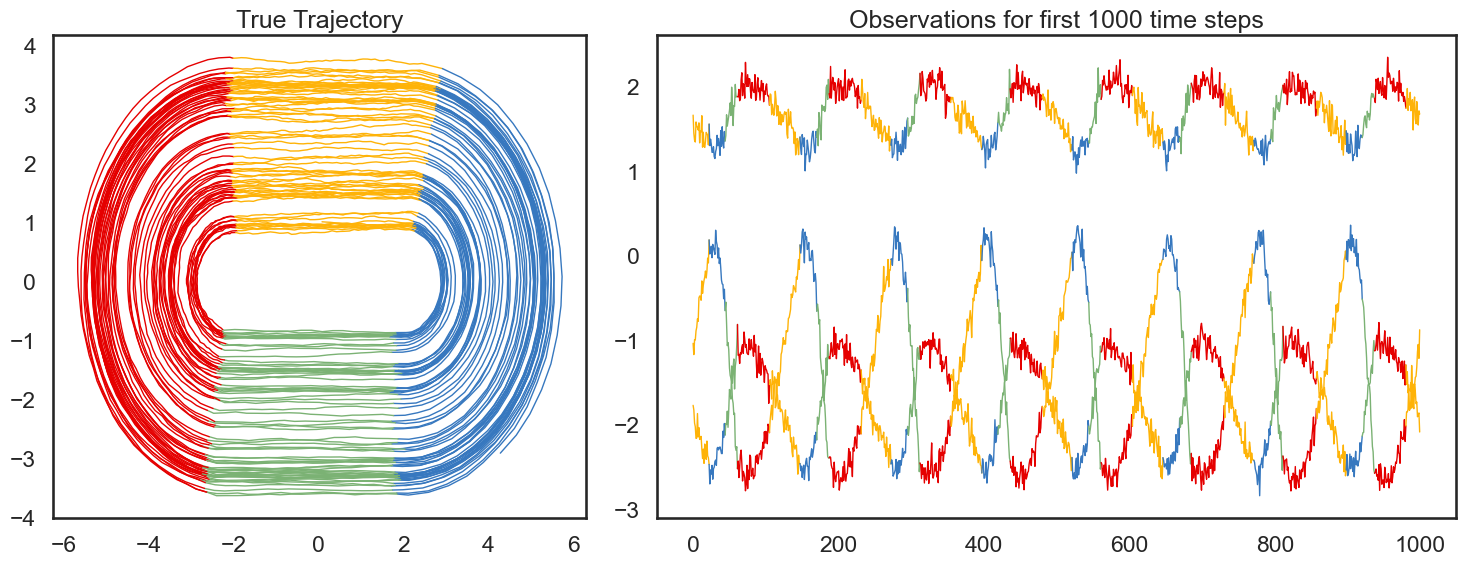

In [4]:
fig = plt.figure(figsize=(15, 6)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 3]) 
ax0 = plt.subplot(gs[0])
plot_trajectory(z, x, ax=ax0)
plt.title("True Trajectory")

ax1 = plt.subplot(gs[1])
plot_observations(z[:1000], y[:1000,:3], ax=ax1)
plt.title("Observations for first 1000 time steps")
plt.tight_layout()

## 3. Exercise

### 3.1 Linear vs. Non-Linear Systems
It's worth looking at the plot of the trajectories and considering the following: what behavior does the latent state show that could not be captured by a single linear dynamical system?

### 3.2 Understanding the discrete state transitions
Let's look again at the form of the discrete state transition probabilities:

$$
p(z_t = i \mid z_{t-1} = j, x_{t-1}) \propto
\exp{\left( \log (P_{j,i}) + w_i^T u_t + r_i ^T x_{t-1} \right)}
$$

In this case, we have used the **recurrent only** transitions class, which means we get rid of the transition matrix and replace it with a bias. Since we don't have any external inputs here, we can also leave out the input terms:


$$
p(z_t = i \mid z_{t-1} = j, x_{t-1}) \propto
\exp{\left( r_i + R_i ^T x_{t-1} \right)}
$$

What happens as the magnitude of the entries in $R_i$ become very large (compared to the entries of $R_j$ for the other states? Do the transitions become more or less random?  

## 4. Fitting an rSLDS
Below, we create a new rSLDS object and fit it to the data generated above (note that our new rSLDS will only have access to the observations $y$ and not the true states $z$ or $x$). 

### 4.1 Fitting Methods
The fitting methods available for the rSLDS are the same as those available for the SLDS. We've reproduced the section on fitting methods from the SLDS notebook below.

**Important Note:**  
 <span style="font-size:larger;">
Understanding the following section is not necessary to use SSM! _For practical purposes, it is almost always best to use the Laplace-EM method with the Structured Mean-Field Posterior, which is the default._ Running the below cells will be a bit slow on a typical laptop (around 5 minutes). We're working on speeding things up in future releases of SSM.
</span>

**Parameter Learning for rSLDS**  
Parameter learning in an rSLDS requires approximate methods. SSM provides two approximate inference algorithms: Black Box Variational Inference (`"bbvi"`) and Laplace Variational EM (`"laplace_em"`). We don't have the space to describe these methods in detail here, but Black Box Variational Inference was described in ["Variational Inference: A Review for Statisticians"](https://arxiv.org/pdf/1601.00670.pdf) by Blei et al. The Laplace Approximation is described in several sources, but a good reference for the context of state-space models is ["Estimating State and Parameters in state-space models of Spike Trains,"](https://pdfs.semanticscholar.org/a71e/bf112cabd47cc67284dc8c12ab7644195d60.pdf) a book chapter by Macke et al.  The specific method used in this notebook is described by ["Zoltowski et al (2020)"](https://arxiv.org/abs/2001.04571).



**Approximate Posterior Distributions**
When using approximate methods, we must choose the form of the distribution we use to approximate the posterior. Here, SSM provides three options:
1. `variational_posterior="meanfield"`
The mean-field approximation uses a factorized distribution as the approximating posterior. Compatible with the BBVI method.

2. `variational_posterior="tridiag"`
This approximates the posterior using a Gaussian with a block tridiagonal covariance matrix, which can be thought of as approximating the SLDS posterior with the posterior from an LDS. Compatible with the BBVI method.

3. `variational_posterior="structured_meanfield"`
This assumes a posterior where the join distribution over the continuous and discrete latent states factors as follows. If $q(z,x \mid y)$ is the joint posterior of the discrete and continuous states given the data, we use the approximation $q(z,x \mid y) \approx q(z \mid y)q(x \mid y)$, where $q(z \mid y)$ is the posterior for a Markov chain. Compatible with the Laplace-EM method.

**Calling the Fit function in SSM**  
All models in SSM share the same general syntax for fitting a model from data. Below, we call the fit function using three different methods and compare convergence. The syntax is as follows:
```python
elbos, posterior = slds.fit(data, method= "...",
                            variational_posterior="...",
                            num_iters= ...)
```
In the the call to `fit`, method should be one of {`"bbvi"`, `"laplace_em"`}.  
The `variational_posterior` argument should be one of {`"mf"`, `"structured_meanfield"`}. However, when using Laplace-EM _only_ structured mean field is supported.
Below, we fit using four methods, and compare convergence.


### 4.2 Getting the Inferred States
For every LDS, SLDS, and rSLDS model in SSM, calling `fit` returns a tuple of `(elbos, posterior)`.  `elbos` is a list containing a lower bound on the log-likelihood of the data at each iteration, used to check the convergence of the fitting algorithm. `posterior` is a posterior object (the exact type depends on which posterior is used). The posterior object is used to get an estimate of the latent variables (in this case $x$ and $z$) for each time step.

Below, we use the line:
```python
xhat_lem = q_lem.mean_continuous_states[0]
```

to get an estimate $\hat x$ of the continuous state over time. The reason for the index `[0]` is that `posterior.mean_continuous_states` will return a list, where each entry is the posterior for a given trial. In this case, we only have a single trial, so we get the first (and only) element of the list.

In [5]:
# Fit an rSLDS with its default initialization, using Laplace-EM with a structured variational posterior
rslds = ssm.SLDS(D_obs, K, D_latent,
             transitions="recurrent_only",
             dynamics="diagonal_gaussian",
             emissions="gaussian_orthog",
             single_subspace=True)
rslds.initialize(y)
q_elbos_lem, q_lem = rslds.fit(y, method="laplace_em",
                               variational_posterior="structured_meanfield",
                               initialize=False, num_iters=100, alpha=0.0)
xhat_lem = q_lem.mean_continuous_states[0]
rslds.permute(find_permutation(z, rslds.most_likely_states(xhat_lem, y)))
zhat_lem = rslds.most_likely_states(xhat_lem, y)

# store rslds
rslds_lem = copy.deepcopy(rslds)

  0%|                                                                                                             | 0/100 [00:00<?, ?it/s]

ELBO: 3267.3:   0%|                                                                                               | 0/100 [00:00<?, ?it/s]

ELBO: 80233.0:   0%|                                                                                              | 0/100 [00:00<?, ?it/s]

ELBO: 80233.0:   1%|▊                                                                                     | 1/100 [00:00<01:32,  1.07it/s]

ELBO: 81626.6:   1%|▊                                                                                     | 1/100 [00:01<01:32,  1.07it/s]

ELBO: 81626.6:   2%|█▋                                                                                    | 2/100 [00:01<01:22,  1.19it/s]

ELBO: 82043.2:   2%|█▋                                                                                    | 2/100 [00:02<01:22,  1.19it/s]

ELBO: 82043.2:   3%|██▌                                                                                   | 3/100 [00:02<01:17,  1.25it/s]

ELBO: 82386.6:   3%|██▌                                                                                   | 3/100 [00:03<01:17,  1.25it/s]

ELBO: 82386.6:   4%|███▍                                                                                  | 4/100 [00:03<01:16,  1.26it/s]

ELBO: 83031.0:   4%|███▍                                                                                  | 4/100 [00:04<01:16,  1.26it/s]

ELBO: 83031.0:   5%|████▎                                                                                 | 5/100 [00:04<01:15,  1.26it/s]

ELBO: 83683.2:   5%|████▎                                                                                 | 5/100 [00:04<01:15,  1.26it/s]

ELBO: 83683.2:   6%|█████▏                                                                                | 6/100 [00:04<01:14,  1.27it/s]

ELBO: 83744.9:   6%|█████▏                                                                                | 6/100 [00:05<01:14,  1.27it/s]

ELBO: 83744.9:   7%|██████                                                                                | 7/100 [00:05<01:10,  1.32it/s]

ELBO: 83786.7:   7%|██████                                                                                | 7/100 [00:06<01:10,  1.32it/s]

ELBO: 83786.7:   8%|██████▉                                                                               | 8/100 [00:06<01:08,  1.34it/s]

ELBO: 84093.7:   8%|██████▉                                                                               | 8/100 [00:06<01:08,  1.34it/s]

ELBO: 84093.7:   9%|███████▋                                                                              | 9/100 [00:06<01:07,  1.36it/s]

ELBO: 84241.4:   9%|███████▋                                                                              | 9/100 [00:07<01:07,  1.36it/s]

ELBO: 84241.4:  10%|████████▌                                                                            | 10/100 [00:07<01:13,  1.23it/s]

ELBO: 84535.5:  10%|████████▌                                                                            | 10/100 [00:08<01:13,  1.23it/s]

ELBO: 84535.5:  11%|█████████▎                                                                           | 11/100 [00:08<01:09,  1.28it/s]

ELBO: 84520.5:  11%|█████████▎                                                                           | 11/100 [00:09<01:09,  1.28it/s]

ELBO: 84520.5:  12%|██████████▏                                                                          | 12/100 [00:09<01:10,  1.25it/s]

ELBO: 84728.5:  12%|██████████▏                                                                          | 12/100 [00:10<01:10,  1.25it/s]

ELBO: 84728.5:  13%|███████████                                                                          | 13/100 [00:10<01:07,  1.30it/s]

ELBO: 84842.5:  13%|███████████                                                                          | 13/100 [00:10<01:07,  1.30it/s]

ELBO: 84842.5:  14%|███████████▉                                                                         | 14/100 [00:10<01:05,  1.32it/s]

ELBO: 84987.2:  14%|███████████▉                                                                         | 14/100 [00:11<01:05,  1.32it/s]

ELBO: 84987.2:  15%|████████████▊                                                                        | 15/100 [00:11<01:02,  1.36it/s]

ELBO: 85044.1:  15%|████████████▊                                                                        | 15/100 [00:12<01:02,  1.36it/s]

ELBO: 85044.1:  16%|█████████████▌                                                                       | 16/100 [00:12<01:00,  1.38it/s]

ELBO: 85193.3:  16%|█████████████▌                                                                       | 16/100 [00:13<01:00,  1.38it/s]

ELBO: 85193.3:  17%|██████████████▍                                                                      | 17/100 [00:13<01:00,  1.37it/s]

ELBO: 85295.2:  17%|██████████████▍                                                                      | 17/100 [00:13<01:00,  1.37it/s]

ELBO: 85295.2:  18%|███████████████▎                                                                     | 18/100 [00:13<00:59,  1.39it/s]

ELBO: 85366.7:  18%|███████████████▎                                                                     | 18/100 [00:14<00:59,  1.39it/s]

ELBO: 85366.7:  19%|████████████████▏                                                                    | 19/100 [00:14<00:57,  1.40it/s]

ELBO: 85390.6:  19%|████████████████▏                                                                    | 19/100 [00:15<00:57,  1.40it/s]

ELBO: 85390.6:  20%|█████████████████                                                                    | 20/100 [00:15<00:59,  1.35it/s]

ELBO: 85477.2:  20%|█████████████████                                                                    | 20/100 [00:16<00:59,  1.35it/s]

ELBO: 85477.2:  21%|█████████████████▊                                                                   | 21/100 [00:16<00:59,  1.33it/s]

ELBO: 85463.3:  21%|█████████████████▊                                                                   | 21/100 [00:16<00:59,  1.33it/s]

ELBO: 85463.3:  22%|██████████████████▋                                                                  | 22/100 [00:16<00:59,  1.32it/s]

ELBO: 85618.1:  22%|██████████████████▋                                                                  | 22/100 [00:17<00:59,  1.32it/s]

ELBO: 85618.1:  23%|███████████████████▌                                                                 | 23/100 [00:17<00:56,  1.36it/s]

ELBO: 85572.4:  23%|███████████████████▌                                                                 | 23/100 [00:18<00:56,  1.36it/s]

ELBO: 85572.4:  24%|████████████████████▍                                                                | 24/100 [00:18<00:55,  1.38it/s]

ELBO: 85556.8:  24%|████████████████████▍                                                                | 24/100 [00:18<00:55,  1.38it/s]

ELBO: 85556.8:  25%|█████████████████████▎                                                               | 25/100 [00:18<00:54,  1.39it/s]

ELBO: 85704.4:  25%|█████████████████████▎                                                               | 25/100 [00:19<00:54,  1.39it/s]

ELBO: 85704.4:  26%|██████████████████████                                                               | 26/100 [00:19<00:53,  1.39it/s]

ELBO: 85776.1:  26%|██████████████████████                                                               | 26/100 [00:20<00:53,  1.39it/s]

ELBO: 85776.1:  27%|██████████████████████▉                                                              | 27/100 [00:20<00:51,  1.41it/s]

ELBO: 85861.7:  27%|██████████████████████▉                                                              | 27/100 [00:20<00:51,  1.41it/s]

ELBO: 85861.7:  28%|███████████████████████▊                                                             | 28/100 [00:20<00:50,  1.42it/s]

ELBO: 85850.6:  28%|███████████████████████▊                                                             | 28/100 [00:21<00:50,  1.42it/s]

ELBO: 85850.6:  29%|████████████████████████▋                                                            | 29/100 [00:21<00:50,  1.42it/s]

ELBO: 85636.3:  29%|████████████████████████▋                                                            | 29/100 [00:22<00:50,  1.42it/s]

ELBO: 85636.3:  30%|█████████████████████████▌                                                           | 30/100 [00:22<00:49,  1.41it/s]

ELBO: 85991.1:  30%|█████████████████████████▌                                                           | 30/100 [00:23<00:49,  1.41it/s]

ELBO: 85991.1:  31%|██████████████████████████▎                                                          | 31/100 [00:23<00:48,  1.41it/s]

ELBO: 85959.5:  31%|██████████████████████████▎                                                          | 31/100 [00:23<00:48,  1.41it/s]

ELBO: 85959.5:  32%|███████████████████████████▏                                                         | 32/100 [00:23<00:47,  1.43it/s]

ELBO: 85780.2:  32%|███████████████████████████▏                                                         | 32/100 [00:24<00:47,  1.43it/s]

ELBO: 85780.2:  33%|████████████████████████████                                                         | 33/100 [00:24<00:46,  1.44it/s]

ELBO: 86047.7:  33%|████████████████████████████                                                         | 33/100 [00:25<00:46,  1.44it/s]

ELBO: 86047.7:  34%|████████████████████████████▉                                                        | 34/100 [00:25<00:46,  1.42it/s]

ELBO: 85939.9:  34%|████████████████████████████▉                                                        | 34/100 [00:25<00:46,  1.42it/s]

ELBO: 85939.9:  35%|█████████████████████████████▋                                                       | 35/100 [00:25<00:45,  1.43it/s]

ELBO: 85778.3:  35%|█████████████████████████████▋                                                       | 35/100 [00:26<00:45,  1.43it/s]

ELBO: 85778.3:  36%|██████████████████████████████▌                                                      | 36/100 [00:26<00:44,  1.44it/s]

ELBO: 85973.2:  36%|██████████████████████████████▌                                                      | 36/100 [00:27<00:44,  1.44it/s]

ELBO: 85973.2:  37%|███████████████████████████████▍                                                     | 37/100 [00:27<00:43,  1.45it/s]

ELBO: 86046.8:  37%|███████████████████████████████▍                                                     | 37/100 [00:27<00:43,  1.45it/s]

ELBO: 86046.8:  38%|████████████████████████████████▎                                                    | 38/100 [00:27<00:43,  1.43it/s]

ELBO: 86040.2:  38%|████████████████████████████████▎                                                    | 38/100 [00:28<00:43,  1.43it/s]

ELBO: 86040.2:  39%|█████████████████████████████████▏                                                   | 39/100 [00:28<00:42,  1.44it/s]

ELBO: 85934.7:  39%|█████████████████████████████████▏                                                   | 39/100 [00:29<00:42,  1.44it/s]

ELBO: 85934.7:  40%|██████████████████████████████████                                                   | 40/100 [00:29<00:41,  1.45it/s]

ELBO: 85921.3:  40%|██████████████████████████████████                                                   | 40/100 [00:30<00:41,  1.45it/s]

ELBO: 85921.3:  41%|██████████████████████████████████▊                                                  | 41/100 [00:30<00:40,  1.46it/s]

ELBO: 85940.6:  41%|██████████████████████████████████▊                                                  | 41/100 [00:30<00:40,  1.46it/s]

ELBO: 85940.6:  42%|███████████████████████████████████▋                                                 | 42/100 [00:30<00:39,  1.45it/s]

ELBO: 86106.7:  42%|███████████████████████████████████▋                                                 | 42/100 [00:31<00:39,  1.45it/s]

ELBO: 86106.7:  43%|████████████████████████████████████▌                                                | 43/100 [00:31<00:39,  1.46it/s]

ELBO: 86002.3:  43%|████████████████████████████████████▌                                                | 43/100 [00:32<00:39,  1.46it/s]

ELBO: 86002.3:  44%|█████████████████████████████████████▍                                               | 44/100 [00:32<00:38,  1.45it/s]

ELBO: 86052.3:  44%|█████████████████████████████████████▍                                               | 44/100 [00:32<00:38,  1.45it/s]

ELBO: 86052.3:  45%|██████████████████████████████████████▎                                              | 45/100 [00:32<00:38,  1.45it/s]

ELBO: 86062.2:  45%|██████████████████████████████████████▎                                              | 45/100 [00:33<00:38,  1.45it/s]

ELBO: 86062.2:  46%|███████████████████████████████████████                                              | 46/100 [00:33<00:37,  1.46it/s]

ELBO: 86083.8:  46%|███████████████████████████████████████                                              | 46/100 [00:34<00:37,  1.46it/s]

ELBO: 86083.8:  47%|███████████████████████████████████████▉                                             | 47/100 [00:34<00:36,  1.45it/s]

ELBO: 85914.6:  47%|███████████████████████████████████████▉                                             | 47/100 [00:34<00:36,  1.45it/s]

ELBO: 85914.6:  48%|████████████████████████████████████████▊                                            | 48/100 [00:34<00:35,  1.45it/s]

ELBO: 86082.0:  48%|████████████████████████████████████████▊                                            | 48/100 [00:35<00:35,  1.45it/s]

ELBO: 86082.0:  49%|█████████████████████████████████████████▋                                           | 49/100 [00:35<00:34,  1.46it/s]

ELBO: 86213.6:  49%|█████████████████████████████████████████▋                                           | 49/100 [00:36<00:34,  1.46it/s]

ELBO: 86213.6:  50%|██████████████████████████████████████████▌                                          | 50/100 [00:36<00:35,  1.42it/s]

ELBO: 86066.8:  50%|██████████████████████████████████████████▌                                          | 50/100 [00:36<00:35,  1.42it/s]

ELBO: 86066.8:  51%|███████████████████████████████████████████▎                                         | 51/100 [00:36<00:34,  1.43it/s]

ELBO: 86167.4:  51%|███████████████████████████████████████████▎                                         | 51/100 [00:37<00:34,  1.43it/s]

ELBO: 86167.4:  52%|████████████████████████████████████████████▏                                        | 52/100 [00:37<00:33,  1.43it/s]

ELBO: 86252.0:  52%|████████████████████████████████████████████▏                                        | 52/100 [00:38<00:33,  1.43it/s]

ELBO: 86252.0:  53%|█████████████████████████████████████████████                                        | 53/100 [00:38<00:33,  1.40it/s]

ELBO: 86397.8:  53%|█████████████████████████████████████████████                                        | 53/100 [00:39<00:33,  1.40it/s]

ELBO: 86397.8:  54%|█████████████████████████████████████████████▉                                       | 54/100 [00:39<00:32,  1.40it/s]

ELBO: 86081.4:  54%|█████████████████████████████████████████████▉                                       | 54/100 [00:39<00:32,  1.40it/s]

ELBO: 86081.4:  55%|██████████████████████████████████████████████▊                                      | 55/100 [00:39<00:32,  1.38it/s]

ELBO: 86243.6:  55%|██████████████████████████████████████████████▊                                      | 55/100 [00:40<00:32,  1.38it/s]

ELBO: 86243.6:  56%|███████████████████████████████████████████████▌                                     | 56/100 [00:40<00:32,  1.36it/s]

ELBO: 86012.2:  56%|███████████████████████████████████████████████▌                                     | 56/100 [00:41<00:32,  1.36it/s]

ELBO: 86012.2:  57%|████████████████████████████████████████████████▍                                    | 57/100 [00:41<00:31,  1.38it/s]

ELBO: 86151.8:  57%|████████████████████████████████████████████████▍                                    | 57/100 [00:42<00:31,  1.38it/s]

ELBO: 86151.8:  58%|█████████████████████████████████████████████████▎                                   | 58/100 [00:42<00:30,  1.39it/s]

ELBO: 86326.7:  58%|█████████████████████████████████████████████████▎                                   | 58/100 [00:42<00:30,  1.39it/s]

ELBO: 86326.7:  59%|██████████████████████████████████████████████████▏                                  | 59/100 [00:42<00:29,  1.40it/s]

ELBO: 86202.8:  59%|██████████████████████████████████████████████████▏                                  | 59/100 [00:43<00:29,  1.40it/s]

ELBO: 86202.8:  60%|███████████████████████████████████████████████████                                  | 60/100 [00:43<00:29,  1.35it/s]

ELBO: 85945.5:  60%|███████████████████████████████████████████████████                                  | 60/100 [00:44<00:29,  1.35it/s]

ELBO: 85945.5:  61%|███████████████████████████████████████████████████▊                                 | 61/100 [00:44<00:28,  1.39it/s]

ELBO: 86117.2:  61%|███████████████████████████████████████████████████▊                                 | 61/100 [00:44<00:28,  1.39it/s]

ELBO: 86117.2:  62%|████████████████████████████████████████████████████▋                                | 62/100 [00:44<00:26,  1.41it/s]

ELBO: 86085.0:  62%|████████████████████████████████████████████████████▋                                | 62/100 [00:45<00:26,  1.41it/s]

ELBO: 86085.0:  63%|█████████████████████████████████████████████████████▌                               | 63/100 [00:45<00:26,  1.37it/s]

ELBO: 86082.7:  63%|█████████████████████████████████████████████████████▌                               | 63/100 [00:46<00:26,  1.37it/s]

ELBO: 86082.7:  64%|██████████████████████████████████████████████████████▍                              | 64/100 [00:46<00:26,  1.35it/s]

ELBO: 86162.2:  64%|██████████████████████████████████████████████████████▍                              | 64/100 [00:47<00:26,  1.35it/s]

ELBO: 86162.2:  65%|███████████████████████████████████████████████████████▎                             | 65/100 [00:47<00:25,  1.36it/s]

ELBO: 86298.1:  65%|███████████████████████████████████████████████████████▎                             | 65/100 [00:47<00:25,  1.36it/s]

ELBO: 86298.1:  66%|████████████████████████████████████████████████████████                             | 66/100 [00:47<00:24,  1.38it/s]

ELBO: 86286.9:  66%|████████████████████████████████████████████████████████                             | 66/100 [00:48<00:24,  1.38it/s]

ELBO: 86286.9:  67%|████████████████████████████████████████████████████████▉                            | 67/100 [00:48<00:23,  1.40it/s]

ELBO: 86330.7:  67%|████████████████████████████████████████████████████████▉                            | 67/100 [00:49<00:23,  1.40it/s]

ELBO: 86330.7:  68%|█████████████████████████████████████████████████████████▊                           | 68/100 [00:49<00:22,  1.40it/s]

ELBO: 86078.5:  68%|█████████████████████████████████████████████████████████▊                           | 68/100 [00:49<00:22,  1.40it/s]

ELBO: 86078.5:  69%|██████████████████████████████████████████████████████████▋                          | 69/100 [00:49<00:22,  1.40it/s]

ELBO: 86226.9:  69%|██████████████████████████████████████████████████████████▋                          | 69/100 [00:50<00:22,  1.40it/s]

ELBO: 86226.9:  70%|███████████████████████████████████████████████████████████▍                         | 70/100 [00:50<00:21,  1.41it/s]

ELBO: 86296.4:  70%|███████████████████████████████████████████████████████████▍                         | 70/100 [00:51<00:21,  1.41it/s]

ELBO: 86296.4:  71%|████████████████████████████████████████████████████████████▎                        | 71/100 [00:51<00:20,  1.41it/s]

ELBO: 86146.0:  71%|████████████████████████████████████████████████████████████▎                        | 71/100 [00:52<00:20,  1.41it/s]

ELBO: 86146.0:  72%|█████████████████████████████████████████████████████████████▏                       | 72/100 [00:52<00:19,  1.42it/s]

ELBO: 86327.4:  72%|█████████████████████████████████████████████████████████████▏                       | 72/100 [00:52<00:19,  1.42it/s]

ELBO: 86327.4:  73%|██████████████████████████████████████████████████████████████                       | 73/100 [00:52<00:18,  1.43it/s]

ELBO: 86275.7:  73%|██████████████████████████████████████████████████████████████                       | 73/100 [00:53<00:18,  1.43it/s]

ELBO: 86275.7:  74%|██████████████████████████████████████████████████████████████▉                      | 74/100 [00:53<00:18,  1.42it/s]

ELBO: 86085.8:  74%|██████████████████████████████████████████████████████████████▉                      | 74/100 [00:54<00:18,  1.42it/s]

ELBO: 86085.8:  75%|███████████████████████████████████████████████████████████████▊                     | 75/100 [00:54<00:17,  1.43it/s]

ELBO: 85930.5:  75%|███████████████████████████████████████████████████████████████▊                     | 75/100 [00:54<00:17,  1.43it/s]

ELBO: 85930.5:  76%|████████████████████████████████████████████████████████████████▌                    | 76/100 [00:54<00:16,  1.43it/s]

ELBO: 86278.0:  76%|████████████████████████████████████████████████████████████████▌                    | 76/100 [00:55<00:16,  1.43it/s]

ELBO: 86278.0:  77%|█████████████████████████████████████████████████████████████████▍                   | 77/100 [00:55<00:15,  1.45it/s]

ELBO: 86190.7:  77%|█████████████████████████████████████████████████████████████████▍                   | 77/100 [00:56<00:15,  1.45it/s]

ELBO: 86190.7:  78%|██████████████████████████████████████████████████████████████████▎                  | 78/100 [00:56<00:15,  1.45it/s]

ELBO: 86244.1:  78%|██████████████████████████████████████████████████████████████████▎                  | 78/100 [00:56<00:15,  1.45it/s]

ELBO: 86244.1:  79%|███████████████████████████████████████████████████████████████████▏                 | 79/100 [00:56<00:14,  1.44it/s]

ELBO: 86195.6:  79%|███████████████████████████████████████████████████████████████████▏                 | 79/100 [00:57<00:14,  1.44it/s]

ELBO: 86195.6:  80%|████████████████████████████████████████████████████████████████████                 | 80/100 [00:57<00:13,  1.44it/s]

ELBO: 86373.0:  80%|████████████████████████████████████████████████████████████████████                 | 80/100 [00:58<00:13,  1.44it/s]

ELBO: 86373.0:  81%|████████████████████████████████████████████████████████████████████▊                | 81/100 [00:58<00:13,  1.43it/s]

ELBO: 86332.6:  81%|████████████████████████████████████████████████████████████████████▊                | 81/100 [00:59<00:13,  1.43it/s]

ELBO: 86332.6:  82%|█████████████████████████████████████████████████████████████████████▋               | 82/100 [00:59<00:12,  1.41it/s]

ELBO: 86267.2:  82%|█████████████████████████████████████████████████████████████████████▋               | 82/100 [01:00<00:12,  1.41it/s]

ELBO: 86267.2:  83%|██████████████████████████████████████████████████████████████████████▌              | 83/100 [01:00<00:13,  1.27it/s]

ELBO: 86434.5:  83%|██████████████████████████████████████████████████████████████████████▌              | 83/100 [01:00<00:13,  1.27it/s]

ELBO: 86434.5:  84%|███████████████████████████████████████████████████████████████████████▍             | 84/100 [01:00<00:12,  1.31it/s]

ELBO: 86292.5:  84%|███████████████████████████████████████████████████████████████████████▍             | 84/100 [01:01<00:12,  1.31it/s]

ELBO: 86292.5:  85%|████████████████████████████████████████████████████████████████████████▎            | 85/100 [01:01<00:11,  1.34it/s]

ELBO: 86163.2:  85%|████████████████████████████████████████████████████████████████████████▎            | 85/100 [01:02<00:11,  1.34it/s]

ELBO: 86163.2:  86%|█████████████████████████████████████████████████████████████████████████            | 86/100 [01:02<00:10,  1.33it/s]

ELBO: 86191.0:  86%|█████████████████████████████████████████████████████████████████████████            | 86/100 [01:02<00:10,  1.33it/s]

ELBO: 86191.0:  87%|█████████████████████████████████████████████████████████████████████████▉           | 87/100 [01:02<00:09,  1.33it/s]

ELBO: 86315.6:  87%|█████████████████████████████████████████████████████████████████████████▉           | 87/100 [01:03<00:09,  1.33it/s]

ELBO: 86315.6:  88%|██████████████████████████████████████████████████████████████████████████▊          | 88/100 [01:03<00:08,  1.36it/s]

ELBO: 86321.8:  88%|██████████████████████████████████████████████████████████████████████████▊          | 88/100 [01:04<00:08,  1.36it/s]

ELBO: 86321.8:  89%|███████████████████████████████████████████████████████████████████████████▋         | 89/100 [01:04<00:08,  1.37it/s]

ELBO: 86229.9:  89%|███████████████████████████████████████████████████████████████████████████▋         | 89/100 [01:05<00:08,  1.37it/s]

ELBO: 86229.9:  90%|████████████████████████████████████████████████████████████████████████████▌        | 90/100 [01:05<00:07,  1.39it/s]

ELBO: 86078.8:  90%|████████████████████████████████████████████████████████████████████████████▌        | 90/100 [01:05<00:07,  1.39it/s]

ELBO: 86078.8:  91%|█████████████████████████████████████████████████████████████████████████████▎       | 91/100 [01:05<00:06,  1.41it/s]

ELBO: 86421.2:  91%|█████████████████████████████████████████████████████████████████████████████▎       | 91/100 [01:06<00:06,  1.41it/s]

ELBO: 86421.2:  92%|██████████████████████████████████████████████████████████████████████████████▏      | 92/100 [01:06<00:05,  1.40it/s]

ELBO: 86209.0:  92%|██████████████████████████████████████████████████████████████████████████████▏      | 92/100 [01:07<00:05,  1.40it/s]

ELBO: 86209.0:  93%|███████████████████████████████████████████████████████████████████████████████      | 93/100 [01:07<00:04,  1.40it/s]

ELBO: 86448.2:  93%|███████████████████████████████████████████████████████████████████████████████      | 93/100 [01:07<00:04,  1.40it/s]

ELBO: 86448.2:  94%|███████████████████████████████████████████████████████████████████████████████▉     | 94/100 [01:07<00:04,  1.41it/s]

ELBO: 86236.9:  94%|███████████████████████████████████████████████████████████████████████████████▉     | 94/100 [01:08<00:04,  1.41it/s]

ELBO: 86236.9:  95%|████████████████████████████████████████████████████████████████████████████████▊    | 95/100 [01:08<00:03,  1.36it/s]

ELBO: 86427.5:  95%|████████████████████████████████████████████████████████████████████████████████▊    | 95/100 [01:09<00:03,  1.36it/s]

ELBO: 86427.5:  96%|█████████████████████████████████████████████████████████████████████████████████▌   | 96/100 [01:09<00:02,  1.38it/s]

ELBO: 86352.0:  96%|█████████████████████████████████████████████████████████████████████████████████▌   | 96/100 [01:10<00:02,  1.38it/s]

ELBO: 86352.0:  97%|██████████████████████████████████████████████████████████████████████████████████▍  | 97/100 [01:10<00:02,  1.36it/s]

ELBO: 86355.1:  97%|██████████████████████████████████████████████████████████████████████████████████▍  | 97/100 [01:10<00:02,  1.36it/s]

ELBO: 86355.1:  98%|███████████████████████████████████████████████████████████████████████████████████▎ | 98/100 [01:10<00:01,  1.35it/s]

ELBO: 86221.7:  98%|███████████████████████████████████████████████████████████████████████████████████▎ | 98/100 [01:11<00:01,  1.35it/s]

ELBO: 86221.7:  99%|████████████████████████████████████████████████████████████████████████████████████▏| 99/100 [01:11<00:00,  1.38it/s]

ELBO: 86377.1:  99%|████████████████████████████████████████████████████████████████████████████████████▏| 99/100 [01:12<00:00,  1.38it/s]

ELBO: 86377.1: 100%|████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:12<00:00,  1.32it/s]

ELBO: 86377.1: 100%|████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:12<00:00,  1.38it/s]

In [6]:
# Fit an rSLDS with its default initialization, using BBVI with a structured variational posterior
rslds = ssm.SLDS(D_obs, K, D_latent, 
             transitions="recurrent_only",
             dynamics="diagonal_gaussian",
             emissions="gaussian_orthog",
             single_subspace=True)
rslds.initialize(y)

q_elbos_bbvi, q_bbvi = rslds.fit(y, method="bbvi",
                                 variational_posterior="meanfield",
                                 initialize=False, num_iters=1000)

  0%|                                                                                                            | 0/1000 [00:00<?, ?it/s]

LP: 71078.0:   0%|                                                                                               | 0/1000 [00:00<?, ?it/s]

ELBO: 71547.5:   0%|                                                                                             | 0/1000 [00:00<?, ?it/s]

ELBO: 71250.0:   0%|                                                                                     | 1/1000 [00:00<02:17,  7.29it/s]

ELBO: 71250.0:   0%|▏                                                                                    | 2/1000 [00:00<01:08, 14.53it/s]

ELBO: 71039.0:   0%|▎                                                                                    | 4/1000 [00:00<01:08, 14.53it/s]

ELBO: 71781.7:   0%|▍                                                                                    | 5/1000 [00:00<01:08, 14.53it/s]

ELBO: 71781.7:   1%|▌                                                                                    | 6/1000 [00:00<00:42, 23.47it/s]

ELBO: 71972.3:   1%|▌                                                                                    | 6/1000 [00:00<00:42, 23.47it/s]

ELBO: 71683.4:   1%|▊                                                                                   | 10/1000 [00:00<00:42, 23.47it/s]

ELBO: 71683.4:   1%|▉                                                                                   | 11/1000 [00:00<00:33, 29.82it/s]

ELBO: 72045.8:   1%|▉                                                                                   | 11/1000 [00:00<00:33, 29.82it/s]

ELBO: 72219.1:   1%|█                                                                                   | 12/1000 [00:00<00:33, 29.82it/s]

ELBO: 72330.5:   1%|█                                                                                   | 13/1000 [00:00<00:33, 29.82it/s]

ELBO: 72330.5:   1%|█▏                                                                                  | 14/1000 [00:00<00:44, 22.34it/s]

ELBO: 72317.3:   2%|█▍                                                                                  | 17/1000 [00:00<00:44, 22.34it/s]

ELBO: 72503.2:   2%|█▌                                                                                  | 18/1000 [00:00<00:43, 22.34it/s]

ELBO: 72503.2:   2%|█▌                                                                                  | 19/1000 [00:00<00:36, 27.13it/s]

ELBO: 72526.3:   2%|█▌                                                                                  | 19/1000 [00:00<00:36, 27.13it/s]

ELBO: 72893.4:   2%|█▋                                                                                  | 20/1000 [00:00<00:36, 27.13it/s]

ELBO: 72663.2:   2%|█▊                                                                                  | 21/1000 [00:00<00:36, 27.13it/s]

ELBO: 72663.2:   2%|█▊                                                                                  | 22/1000 [00:00<00:44, 22.17it/s]

ELBO: 72779.7:   2%|█▊                                                                                  | 22/1000 [00:01<00:44, 22.17it/s]

ELBO: 72912.0:   2%|█▉                                                                                  | 23/1000 [00:01<00:44, 22.17it/s]

ELBO: 73258.1:   2%|██                                                                                  | 24/1000 [00:01<00:44, 22.17it/s]

ELBO: 73258.1:   2%|██                                                                                  | 25/1000 [00:01<00:49, 19.52it/s]

ELBO: 73150.7:   3%|██▎                                                                                 | 28/1000 [00:01<00:49, 19.52it/s]

ELBO: 73368.2:   3%|██▍                                                                                 | 29/1000 [00:01<00:49, 19.52it/s]

ELBO: 73368.2:   3%|██▌                                                                                 | 30/1000 [00:01<00:40, 24.17it/s]

ELBO: 73409.2:   3%|██▌                                                                                 | 30/1000 [00:01<00:40, 24.17it/s]

ELBO: 73197.4:   3%|██▌                                                                                 | 31/1000 [00:01<00:40, 24.17it/s]

ELBO: 73576.5:   3%|██▋                                                                                 | 32/1000 [00:01<00:40, 24.17it/s]

ELBO: 73576.5:   3%|██▊                                                                                 | 33/1000 [00:01<00:46, 20.82it/s]

ELBO: 73760.9:   3%|██▊                                                                                 | 33/1000 [00:01<00:46, 20.82it/s]

ELBO: 73475.2:   3%|██▊                                                                                 | 34/1000 [00:01<00:46, 20.82it/s]

ELBO: 73563.9:   4%|██▉                                                                                 | 35/1000 [00:01<00:46, 20.82it/s]

ELBO: 73563.9:   4%|███                                                                                 | 36/1000 [00:01<00:51, 18.85it/s]

ELBO: 73790.9:   4%|███                                                                                 | 36/1000 [00:01<00:51, 18.85it/s]

ELBO: 73980.9:   4%|███                                                                                 | 37/1000 [00:01<00:51, 18.85it/s]

ELBO: 73848.1:   4%|███▏                                                                                | 38/1000 [00:01<00:51, 18.85it/s]

ELBO: 73848.1:   4%|███▎                                                                                | 39/1000 [00:01<00:58, 16.55it/s]

ELBO: 73564.6:   4%|███▌                                                                                | 42/1000 [00:01<00:57, 16.55it/s]

ELBO: 73897.7:   4%|███▌                                                                                | 43/1000 [00:02<00:57, 16.55it/s]

ELBO: 73897.7:   4%|███▋                                                                                | 44/1000 [00:02<00:45, 21.14it/s]

ELBO: 74108.5:   4%|███▋                                                                                | 44/1000 [00:02<00:45, 21.14it/s]

ELBO: 74232.9:   4%|███▊                                                                                | 45/1000 [00:02<00:45, 21.14it/s]

ELBO: 73858.2:   5%|███▊                                                                                | 46/1000 [00:02<00:45, 21.14it/s]

ELBO: 73858.2:   5%|███▉                                                                                | 47/1000 [00:02<00:49, 19.07it/s]

ELBO: 74227.9:   5%|███▉                                                                                | 47/1000 [00:02<00:49, 19.07it/s]

ELBO: 73932.9:   5%|████                                                                                | 48/1000 [00:02<00:49, 19.07it/s]

ELBO: 74316.3:   5%|████                                                                                | 49/1000 [00:02<00:49, 19.07it/s]

ELBO: 74316.3:   5%|████▏                                                                               | 50/1000 [00:02<00:53, 17.65it/s]

ELBO: 74690.5:   5%|████▏                                                                               | 50/1000 [00:02<00:53, 17.65it/s]

ELBO: 74285.9:   5%|████▎                                                                               | 51/1000 [00:02<00:53, 17.65it/s]

ELBO: 74285.9:   5%|████▎                                                                               | 52/1000 [00:02<00:55, 16.99it/s]

ELBO: 74608.3:   5%|████▎                                                                               | 52/1000 [00:02<00:55, 16.99it/s]

ELBO: 74505.4:   5%|████▍                                                                               | 53/1000 [00:02<00:55, 16.99it/s]

ELBO: 74505.4:   5%|████▌                                                                               | 54/1000 [00:02<00:57, 16.41it/s]

ELBO: 74371.4:   5%|████▌                                                                               | 54/1000 [00:02<00:57, 16.41it/s]

ELBO: 74691.6:   6%|████▊                                                                               | 57/1000 [00:02<00:57, 16.41it/s]

ELBO: 74691.6:   6%|████▊                                                                               | 58/1000 [00:02<00:47, 19.93it/s]

ELBO: 74461.1:   6%|████▊                                                                               | 58/1000 [00:02<00:47, 19.93it/s]

ELBO: 74517.1:   6%|████▉                                                                               | 59/1000 [00:03<00:47, 19.93it/s]

ELBO: 74840.1:   6%|█████                                                                               | 60/1000 [00:03<00:47, 19.93it/s]

ELBO: 74840.1:   6%|█████                                                                               | 61/1000 [00:03<00:51, 18.09it/s]

ELBO: 74711.8:   6%|█████                                                                               | 61/1000 [00:03<00:51, 18.09it/s]

ELBO: 74997.8:   6%|█████▏                                                                              | 62/1000 [00:03<00:51, 18.09it/s]

ELBO: 74997.8:   6%|█████▎                                                                              | 63/1000 [00:03<00:54, 17.20it/s]

ELBO: 74760.8:   6%|█████▎                                                                              | 63/1000 [00:03<00:54, 17.20it/s]

ELBO: 75216.8:   6%|█████▍                                                                              | 64/1000 [00:03<00:54, 17.20it/s]

ELBO: 75216.8:   6%|█████▍                                                                              | 65/1000 [00:03<00:56, 16.54it/s]

ELBO: 75117.0:   6%|█████▍                                                                              | 65/1000 [00:03<00:56, 16.54it/s]

ELBO: 74913.9:   7%|█████▌                                                                              | 66/1000 [00:03<00:56, 16.54it/s]

ELBO: 74913.9:   7%|█████▋                                                                              | 67/1000 [00:03<00:58, 16.06it/s]

ELBO: 75141.3:   7%|█████▋                                                                              | 67/1000 [00:03<00:58, 16.06it/s]

ELBO: 74994.2:   7%|█████▋                                                                              | 68/1000 [00:03<00:58, 16.06it/s]

ELBO: 74994.2:   7%|█████▊                                                                              | 69/1000 [00:03<00:59, 15.76it/s]

ELBO: 75245.1:   7%|█████▊                                                                              | 69/1000 [00:03<00:59, 15.76it/s]

ELBO: 75290.0:   7%|█████▉                                                                              | 70/1000 [00:03<00:59, 15.76it/s]

ELBO: 75290.0:   7%|█████▉                                                                              | 71/1000 [00:03<00:59, 15.51it/s]

ELBO: 75164.7:   7%|█████▉                                                                              | 71/1000 [00:03<00:59, 15.51it/s]

ELBO: 75204.1:   7%|██████▏                                                                             | 74/1000 [00:03<00:59, 15.51it/s]

ELBO: 75204.1:   8%|██████▎                                                                             | 75/1000 [00:03<00:47, 19.63it/s]

ELBO: 75198.9:   8%|██████▎                                                                             | 75/1000 [00:03<00:47, 19.63it/s]

ELBO: 75500.3:   8%|██████▍                                                                             | 76/1000 [00:04<00:47, 19.63it/s]

ELBO: 75500.3:   8%|██████▍                                                                             | 77/1000 [00:04<00:50, 18.14it/s]

ELBO: 75444.5:   8%|██████▍                                                                             | 77/1000 [00:04<00:50, 18.14it/s]

ELBO: 75437.1:   8%|██████▌                                                                             | 78/1000 [00:04<00:50, 18.14it/s]

ELBO: 75437.1:   8%|██████▋                                                                             | 79/1000 [00:04<00:53, 17.09it/s]

ELBO: 75633.6:   8%|██████▋                                                                             | 79/1000 [00:04<00:53, 17.09it/s]

ELBO: 75446.3:   8%|██████▋                                                                             | 80/1000 [00:04<00:53, 17.09it/s]

ELBO: 75446.3:   8%|██████▊                                                                             | 81/1000 [00:04<00:55, 16.41it/s]

ELBO: 75700.9:   8%|██████▊                                                                             | 81/1000 [00:04<00:55, 16.41it/s]

ELBO: 75806.1:   8%|██████▉                                                                             | 82/1000 [00:04<00:55, 16.41it/s]

ELBO: 75806.1:   8%|██████▉                                                                             | 83/1000 [00:04<00:57, 15.89it/s]

ELBO: 75788.0:   8%|██████▉                                                                             | 83/1000 [00:04<00:57, 15.89it/s]

ELBO: 75495.4:   8%|███████                                                                             | 84/1000 [00:04<00:57, 15.89it/s]

ELBO: 75495.4:   8%|███████▏                                                                            | 85/1000 [00:04<00:58, 15.57it/s]

ELBO: 75492.7:   8%|███████▏                                                                            | 85/1000 [00:04<00:58, 15.57it/s]

ELBO: 75779.1:   9%|███████▏                                                                            | 86/1000 [00:04<00:58, 15.57it/s]

ELBO: 75779.1:   9%|███████▎                                                                            | 87/1000 [00:04<00:59, 15.40it/s]

ELBO: 75794.9:   9%|███████▎                                                                            | 87/1000 [00:04<00:59, 15.40it/s]

ELBO: 75788.8:   9%|███████▍                                                                            | 88/1000 [00:04<00:59, 15.40it/s]

ELBO: 75788.8:   9%|███████▍                                                                            | 89/1000 [00:04<00:59, 15.26it/s]

ELBO: 75829.0:   9%|███████▍                                                                            | 89/1000 [00:04<00:59, 15.26it/s]

ELBO: 75983.1:   9%|███████▌                                                                            | 90/1000 [00:04<00:59, 15.26it/s]

ELBO: 75983.1:   9%|███████▋                                                                            | 91/1000 [00:04<01:00, 15.10it/s]

ELBO: 75833.8:   9%|███████▊                                                                            | 93/1000 [00:05<01:00, 15.10it/s]

ELBO: 75868.0:   9%|███████▉                                                                            | 94/1000 [00:05<00:59, 15.10it/s]

ELBO: 75868.0:  10%|███████▉                                                                            | 95/1000 [00:05<00:46, 19.48it/s]

ELBO: 75800.1:  10%|███████▉                                                                            | 95/1000 [00:05<00:46, 19.48it/s]

ELBO: 75917.3:  10%|████████                                                                            | 96/1000 [00:05<00:46, 19.48it/s]

ELBO: 75917.3:  10%|████████▏                                                                           | 97/1000 [00:05<00:50, 18.00it/s]

ELBO: 75805.2:  10%|████████▏                                                                           | 97/1000 [00:05<00:50, 18.00it/s]

ELBO: 76052.3:  10%|████████▏                                                                           | 98/1000 [00:05<00:50, 18.00it/s]

ELBO: 76052.3:  10%|████████▎                                                                           | 99/1000 [00:05<00:52, 17.06it/s]

ELBO: 75991.2:  10%|████████▎                                                                           | 99/1000 [00:05<00:52, 17.06it/s]

ELBO: 76142.6:  10%|████████▎                                                                          | 100/1000 [00:05<00:52, 17.06it/s]

ELBO: 76142.6:  10%|████████▍                                                                          | 101/1000 [00:05<00:54, 16.37it/s]

ELBO: 76131.8:  10%|████████▍                                                                          | 101/1000 [00:05<00:54, 16.37it/s]

ELBO: 76074.4:  10%|████████▍                                                                          | 102/1000 [00:05<00:54, 16.37it/s]

ELBO: 76074.4:  10%|████████▌                                                                          | 103/1000 [00:05<00:56, 15.80it/s]

ELBO: 76077.7:  10%|████████▌                                                                          | 103/1000 [00:05<00:56, 15.80it/s]

ELBO: 76188.2:  10%|████████▋                                                                          | 104/1000 [00:05<00:56, 15.80it/s]

ELBO: 76188.2:  10%|████████▋                                                                          | 105/1000 [00:05<00:58, 15.35it/s]

ELBO: 76302.5:  10%|████████▋                                                                          | 105/1000 [00:05<00:58, 15.35it/s]

ELBO: 76224.3:  11%|████████▊                                                                          | 106/1000 [00:05<00:58, 15.35it/s]

ELBO: 76224.3:  11%|████████▉                                                                          | 107/1000 [00:05<00:59, 15.04it/s]

ELBO: 76089.3:  11%|████████▉                                                                          | 107/1000 [00:05<00:59, 15.04it/s]

ELBO: 76130.6:  11%|████████▉                                                                          | 108/1000 [00:06<00:59, 15.04it/s]

ELBO: 76130.6:  11%|█████████                                                                          | 109/1000 [00:06<01:00, 14.84it/s]

ELBO: 76254.7:  11%|█████████                                                                          | 109/1000 [00:06<01:00, 14.84it/s]

ELBO: 76337.1:  11%|█████████▏                                                                         | 110/1000 [00:06<00:59, 14.84it/s]

ELBO: 76337.1:  11%|█████████▏                                                                         | 111/1000 [00:06<01:00, 14.63it/s]

ELBO: 76177.5:  11%|█████████▏                                                                         | 111/1000 [00:06<01:00, 14.63it/s]

ELBO: 76169.3:  11%|█████████▎                                                                         | 112/1000 [00:06<01:00, 14.63it/s]

ELBO: 76169.3:  11%|█████████▍                                                                         | 113/1000 [00:06<01:00, 14.59it/s]

ELBO: 76369.1:  12%|█████████▌                                                                         | 115/1000 [00:06<01:00, 14.59it/s]

ELBO: 76238.6:  12%|█████████▋                                                                         | 116/1000 [00:06<01:00, 14.59it/s]

ELBO: 76238.6:  12%|█████████▋                                                                         | 117/1000 [00:06<00:47, 18.73it/s]

ELBO: 76263.0:  12%|█████████▋                                                                         | 117/1000 [00:06<00:47, 18.73it/s]

ELBO: 76385.4:  12%|█████████▊                                                                         | 118/1000 [00:06<00:47, 18.73it/s]

ELBO: 76385.4:  12%|█████████▉                                                                         | 119/1000 [00:06<00:51, 17.20it/s]

ELBO: 76436.2:  12%|█████████▉                                                                         | 119/1000 [00:06<00:51, 17.20it/s]

ELBO: 76404.9:  12%|█████████▉                                                                         | 120/1000 [00:06<00:51, 17.20it/s]

ELBO: 76404.9:  12%|██████████                                                                         | 121/1000 [00:06<00:53, 16.45it/s]

ELBO: 76423.4:  12%|██████████                                                                         | 121/1000 [00:06<00:53, 16.45it/s]

ELBO: 76625.8:  12%|██████████▏                                                                        | 122/1000 [00:06<00:53, 16.45it/s]

ELBO: 76625.8:  12%|██████████▏                                                                        | 123/1000 [00:06<00:54, 15.97it/s]

ELBO: 76384.4:  12%|██████████▏                                                                        | 123/1000 [00:06<00:54, 15.97it/s]

ELBO: 76200.2:  12%|██████████▎                                                                        | 124/1000 [00:07<00:54, 15.97it/s]

ELBO: 76200.2:  12%|██████████▍                                                                        | 125/1000 [00:07<01:00, 14.36it/s]

ELBO: 76293.3:  12%|██████████▍                                                                        | 125/1000 [00:07<01:00, 14.36it/s]

ELBO: 76500.6:  13%|██████████▍                                                                        | 126/1000 [00:07<01:00, 14.36it/s]

ELBO: 76500.6:  13%|██████████▌                                                                        | 127/1000 [00:07<01:00, 14.46it/s]

ELBO: 76451.1:  13%|██████████▌                                                                        | 127/1000 [00:07<01:00, 14.46it/s]

ELBO: 76749.0:  13%|██████████▌                                                                        | 128/1000 [00:07<01:00, 14.46it/s]

ELBO: 76749.0:  13%|██████████▋                                                                        | 129/1000 [00:07<00:59, 14.56it/s]

ELBO: 76536.2:  13%|██████████▋                                                                        | 129/1000 [00:07<00:59, 14.56it/s]

ELBO: 76703.5:  13%|██████████▊                                                                        | 130/1000 [00:07<00:59, 14.56it/s]

ELBO: 76703.5:  13%|██████████▊                                                                        | 131/1000 [00:07<00:59, 14.58it/s]

ELBO: 76634.0:  13%|██████████▊                                                                        | 131/1000 [00:07<00:59, 14.58it/s]

ELBO: 76327.1:  13%|██████████▉                                                                        | 132/1000 [00:07<00:59, 14.58it/s]

ELBO: 76327.1:  13%|███████████                                                                        | 133/1000 [00:07<00:59, 14.59it/s]

ELBO: 76570.2:  13%|███████████                                                                        | 133/1000 [00:07<00:59, 14.59it/s]

ELBO: 76700.1:  13%|███████████                                                                        | 134/1000 [00:07<00:59, 14.59it/s]

ELBO: 76700.1:  14%|███████████▏                                                                       | 135/1000 [00:07<00:58, 14.67it/s]

ELBO: 76637.3:  14%|███████████▏                                                                       | 135/1000 [00:07<00:58, 14.67it/s]

ELBO: 76675.0:  14%|███████████▎                                                                       | 136/1000 [00:07<00:58, 14.67it/s]

ELBO: 76675.0:  14%|███████████▎                                                                       | 137/1000 [00:07<00:58, 14.72it/s]

ELBO: 76756.3:  14%|███████████▌                                                                       | 139/1000 [00:07<00:58, 14.72it/s]

ELBO: 76619.1:  14%|███████████▌                                                                       | 140/1000 [00:08<00:58, 14.72it/s]

ELBO: 76619.1:  14%|███████████▋                                                                       | 141/1000 [00:08<00:44, 19.12it/s]

ELBO: 76692.6:  14%|███████████▋                                                                       | 141/1000 [00:08<00:44, 19.12it/s]

ELBO: 76779.9:  14%|███████████▊                                                                       | 142/1000 [00:08<00:44, 19.12it/s]

ELBO: 76779.9:  14%|███████████▊                                                                       | 143/1000 [00:08<00:48, 17.74it/s]

ELBO: 76642.4:  14%|███████████▊                                                                       | 143/1000 [00:08<00:48, 17.74it/s]

ELBO: 76834.5:  14%|███████████▉                                                                       | 144/1000 [00:08<00:48, 17.74it/s]

ELBO: 76834.5:  14%|████████████                                                                       | 145/1000 [00:08<00:50, 16.83it/s]

ELBO: 76677.6:  14%|████████████                                                                       | 145/1000 [00:08<00:50, 16.83it/s]

ELBO: 76584.0:  15%|████████████                                                                       | 146/1000 [00:08<00:50, 16.83it/s]

ELBO: 76584.0:  15%|████████████▏                                                                      | 147/1000 [00:08<00:52, 16.21it/s]

ELBO: 76562.8:  15%|████████████▏                                                                      | 147/1000 [00:08<00:52, 16.21it/s]

ELBO: 76823.0:  15%|████████████▎                                                                      | 148/1000 [00:08<00:52, 16.21it/s]

ELBO: 76823.0:  15%|████████████▎                                                                      | 149/1000 [00:08<00:54, 15.74it/s]

ELBO: 76695.6:  15%|████████████▎                                                                      | 149/1000 [00:08<00:54, 15.74it/s]

ELBO: 76808.3:  15%|████████████▍                                                                      | 150/1000 [00:08<00:54, 15.74it/s]

ELBO: 76808.3:  15%|████████████▌                                                                      | 151/1000 [00:08<00:55, 15.43it/s]

ELBO: 76959.7:  15%|████████████▌                                                                      | 151/1000 [00:08<00:55, 15.43it/s]

ELBO: 76836.1:  15%|████████████▌                                                                      | 152/1000 [00:08<00:54, 15.43it/s]

ELBO: 76836.1:  15%|████████████▋                                                                      | 153/1000 [00:08<00:55, 15.23it/s]

ELBO: 76779.5:  15%|████████████▋                                                                      | 153/1000 [00:08<00:55, 15.23it/s]

ELBO: 76893.7:  15%|████████████▊                                                                      | 154/1000 [00:08<00:55, 15.23it/s]

ELBO: 76893.7:  16%|████████████▊                                                                      | 155/1000 [00:08<00:55, 15.13it/s]

ELBO: 76806.2:  16%|████████████▊                                                                      | 155/1000 [00:09<00:55, 15.13it/s]

ELBO: 76925.9:  16%|████████████▉                                                                      | 156/1000 [00:09<00:55, 15.13it/s]

ELBO: 76925.9:  16%|█████████████                                                                      | 157/1000 [00:09<00:56, 14.99it/s]

ELBO: 76766.1:  16%|█████████████                                                                      | 157/1000 [00:09<00:56, 14.99it/s]

ELBO: 76809.0:  16%|█████████████                                                                      | 158/1000 [00:09<00:56, 14.99it/s]

ELBO: 76809.0:  16%|█████████████▏                                                                     | 159/1000 [00:09<00:56, 14.92it/s]

ELBO: 76808.5:  16%|█████████████▏                                                                     | 159/1000 [00:09<00:56, 14.92it/s]

ELBO: 76748.2:  16%|█████████████▎                                                                     | 160/1000 [00:09<00:56, 14.92it/s]

ELBO: 76748.2:  16%|█████████████▎                                                                     | 161/1000 [00:09<00:56, 14.90it/s]

ELBO: 76753.5:  16%|█████████████▎                                                                     | 161/1000 [00:09<00:56, 14.90it/s]

ELBO: 76754.4:  16%|█████████████▍                                                                     | 162/1000 [00:09<00:56, 14.90it/s]

ELBO: 76754.4:  16%|█████████████▌                                                                     | 163/1000 [00:09<00:56, 14.87it/s]

ELBO: 76949.8:  16%|█████████████▋                                                                     | 165/1000 [00:09<00:56, 14.87it/s]

ELBO: 76894.8:  17%|█████████████▊                                                                     | 166/1000 [00:09<00:56, 14.87it/s]

ELBO: 76894.8:  17%|█████████████▊                                                                     | 167/1000 [00:09<00:43, 19.36it/s]

ELBO: 76889.0:  17%|█████████████▊                                                                     | 167/1000 [00:09<00:43, 19.36it/s]

ELBO: 76674.6:  17%|█████████████▉                                                                     | 168/1000 [00:09<00:42, 19.36it/s]

ELBO: 76674.6:  17%|██████████████                                                                     | 169/1000 [00:09<00:46, 17.93it/s]

ELBO: 76745.7:  17%|██████████████                                                                     | 169/1000 [00:09<00:46, 17.93it/s]

ELBO: 76815.6:  17%|██████████████                                                                     | 170/1000 [00:09<00:46, 17.93it/s]

ELBO: 76815.6:  17%|██████████████▏                                                                    | 171/1000 [00:09<00:48, 17.07it/s]

ELBO: 76918.5:  17%|██████████████▏                                                                    | 171/1000 [00:09<00:48, 17.07it/s]

ELBO: 77099.2:  17%|██████████████▎                                                                    | 172/1000 [00:10<00:48, 17.07it/s]

ELBO: 77099.2:  17%|██████████████▎                                                                    | 173/1000 [00:10<00:50, 16.36it/s]

ELBO: 77015.1:  17%|██████████████▎                                                                    | 173/1000 [00:10<00:50, 16.36it/s]

ELBO: 77032.6:  17%|██████████████▍                                                                    | 174/1000 [00:10<00:50, 16.36it/s]

ELBO: 77032.6:  18%|██████████████▌                                                                    | 175/1000 [00:10<00:51, 15.88it/s]

ELBO: 77172.8:  18%|██████████████▌                                                                    | 175/1000 [00:10<00:51, 15.88it/s]

ELBO: 76905.4:  18%|██████████████▌                                                                    | 176/1000 [00:10<00:51, 15.88it/s]

ELBO: 76905.4:  18%|██████████████▋                                                                    | 177/1000 [00:10<00:52, 15.57it/s]

ELBO: 76903.3:  18%|██████████████▋                                                                    | 177/1000 [00:10<00:52, 15.57it/s]

ELBO: 76978.3:  18%|██████████████▊                                                                    | 178/1000 [00:10<00:52, 15.57it/s]

ELBO: 76978.3:  18%|██████████████▊                                                                    | 179/1000 [00:10<00:53, 15.31it/s]

ELBO: 76948.0:  18%|██████████████▊                                                                    | 179/1000 [00:10<00:53, 15.31it/s]

ELBO: 76873.8:  18%|██████████████▉                                                                    | 180/1000 [00:10<00:53, 15.31it/s]

ELBO: 76873.8:  18%|███████████████                                                                    | 181/1000 [00:10<00:54, 15.16it/s]

ELBO: 77131.2:  18%|███████████████                                                                    | 181/1000 [00:10<00:54, 15.16it/s]

ELBO: 76923.8:  18%|███████████████                                                                    | 182/1000 [00:10<00:53, 15.16it/s]

ELBO: 76923.8:  18%|███████████████▏                                                                   | 183/1000 [00:10<00:54, 15.08it/s]

ELBO: 76886.1:  18%|███████████████▏                                                                   | 183/1000 [00:10<00:54, 15.08it/s]

ELBO: 77078.8:  18%|███████████████▎                                                                   | 184/1000 [00:10<00:54, 15.08it/s]

ELBO: 77078.8:  18%|███████████████▎                                                                   | 185/1000 [00:10<00:54, 15.03it/s]

ELBO: 77027.1:  18%|███████████████▎                                                                   | 185/1000 [00:10<00:54, 15.03it/s]

ELBO: 77087.1:  19%|███████████████▍                                                                   | 186/1000 [00:11<00:54, 15.03it/s]

ELBO: 77087.1:  19%|███████████████▌                                                                   | 187/1000 [00:11<00:54, 14.97it/s]

ELBO: 76995.7:  19%|███████████████▌                                                                   | 187/1000 [00:11<00:54, 14.97it/s]

ELBO: 77057.3:  19%|███████████████▌                                                                   | 188/1000 [00:11<00:54, 14.97it/s]

ELBO: 77057.3:  19%|███████████████▋                                                                   | 189/1000 [00:11<00:54, 14.96it/s]

ELBO: 77129.5:  19%|███████████████▋                                                                   | 189/1000 [00:11<00:54, 14.96it/s]

ELBO: 77037.7:  19%|███████████████▊                                                                   | 190/1000 [00:11<00:54, 14.96it/s]

ELBO: 77037.7:  19%|███████████████▊                                                                   | 191/1000 [00:11<00:54, 14.88it/s]

ELBO: 77039.7:  19%|████████████████                                                                   | 193/1000 [00:11<00:54, 14.88it/s]

ELBO: 76889.9:  19%|████████████████                                                                   | 194/1000 [00:11<00:54, 14.88it/s]

ELBO: 76889.9:  20%|████████████████▏                                                                  | 195/1000 [00:11<00:41, 19.30it/s]

ELBO: 77178.5:  20%|████████████████▏                                                                  | 195/1000 [00:11<00:41, 19.30it/s]

ELBO: 77235.7:  20%|████████████████▎                                                                  | 196/1000 [00:11<00:41, 19.30it/s]

ELBO: 77235.7:  20%|████████████████▎                                                                  | 197/1000 [00:11<00:44, 17.93it/s]

ELBO: 77044.6:  20%|████████████████▎                                                                  | 197/1000 [00:11<00:44, 17.93it/s]

ELBO: 77082.9:  20%|████████████████▍                                                                  | 198/1000 [00:11<00:44, 17.93it/s]

ELBO: 77082.9:  20%|████████████████▌                                                                  | 199/1000 [00:11<00:47, 17.01it/s]

ELBO: 76933.4:  20%|████████████████▌                                                                  | 199/1000 [00:11<00:47, 17.01it/s]

ELBO: 77147.0:  20%|████████████████▌                                                                  | 200/1000 [00:11<00:47, 17.01it/s]

ELBO: 77147.0:  20%|████████████████▋                                                                  | 201/1000 [00:11<00:48, 16.32it/s]

ELBO: 77238.1:  20%|████████████████▋                                                                  | 201/1000 [00:11<00:48, 16.32it/s]

ELBO: 77168.2:  20%|████████████████▊                                                                  | 202/1000 [00:11<00:48, 16.32it/s]

ELBO: 77168.2:  20%|████████████████▊                                                                  | 203/1000 [00:11<00:50, 15.90it/s]

ELBO: 77085.0:  20%|████████████████▊                                                                  | 203/1000 [00:12<00:50, 15.90it/s]

ELBO: 77133.0:  20%|████████████████▉                                                                  | 204/1000 [00:12<00:50, 15.90it/s]

ELBO: 77133.0:  20%|█████████████████                                                                  | 205/1000 [00:12<00:51, 15.54it/s]

ELBO: 77169.2:  20%|█████████████████                                                                  | 205/1000 [00:12<00:51, 15.54it/s]

ELBO: 77205.5:  21%|█████████████████                                                                  | 206/1000 [00:12<00:51, 15.54it/s]

ELBO: 77205.5:  21%|█████████████████▏                                                                 | 207/1000 [00:12<00:51, 15.33it/s]

ELBO: 77066.8:  21%|█████████████████▏                                                                 | 207/1000 [00:12<00:51, 15.33it/s]

ELBO: 77315.5:  21%|█████████████████▎                                                                 | 208/1000 [00:12<00:51, 15.33it/s]

ELBO: 77315.5:  21%|█████████████████▎                                                                 | 209/1000 [00:12<00:52, 15.19it/s]

ELBO: 77027.2:  21%|█████████████████▎                                                                 | 209/1000 [00:12<00:52, 15.19it/s]

ELBO: 76972.7:  21%|█████████████████▍                                                                 | 210/1000 [00:12<00:51, 15.19it/s]

ELBO: 76972.7:  21%|█████████████████▌                                                                 | 211/1000 [00:12<00:52, 14.98it/s]

ELBO: 77214.3:  21%|█████████████████▌                                                                 | 211/1000 [00:12<00:52, 14.98it/s]

ELBO: 77000.8:  21%|█████████████████▌                                                                 | 212/1000 [00:12<00:52, 14.98it/s]

ELBO: 77000.8:  21%|█████████████████▋                                                                 | 213/1000 [00:12<00:52, 14.91it/s]

ELBO: 77254.2:  21%|█████████████████▋                                                                 | 213/1000 [00:12<00:52, 14.91it/s]

ELBO: 77166.5:  21%|█████████████████▊                                                                 | 214/1000 [00:12<00:52, 14.91it/s]

ELBO: 77166.5:  22%|█████████████████▊                                                                 | 215/1000 [00:12<00:52, 14.86it/s]

ELBO: 76938.7:  22%|█████████████████▊                                                                 | 215/1000 [00:12<00:52, 14.86it/s]

ELBO: 77092.0:  22%|█████████████████▉                                                                 | 216/1000 [00:12<00:52, 14.86it/s]

ELBO: 77092.0:  22%|██████████████████                                                                 | 217/1000 [00:12<00:52, 14.81it/s]

ELBO: 77114.8:  22%|██████████████████                                                                 | 217/1000 [00:13<00:52, 14.81it/s]

ELBO: 77179.1:  22%|██████████████████                                                                 | 218/1000 [00:13<00:52, 14.81it/s]

ELBO: 77179.1:  22%|██████████████████▏                                                                | 219/1000 [00:13<00:57, 13.63it/s]

ELBO: 77235.7:  22%|██████████████████▏                                                                | 219/1000 [00:13<00:57, 13.63it/s]

ELBO: 77306.9:  22%|██████████████████▎                                                                | 220/1000 [00:13<00:57, 13.63it/s]

ELBO: 77306.9:  22%|██████████████████▎                                                                | 221/1000 [00:13<00:55, 13.93it/s]

ELBO: 77265.5:  22%|██████████████████▌                                                                | 223/1000 [00:13<00:55, 13.93it/s]

ELBO: 77266.5:  22%|██████████████████▌                                                                | 224/1000 [00:13<00:55, 13.93it/s]

ELBO: 77266.5:  22%|██████████████████▋                                                                | 225/1000 [00:13<00:42, 18.36it/s]

ELBO: 77315.9:  22%|██████████████████▋                                                                | 225/1000 [00:13<00:42, 18.36it/s]

ELBO: 77137.9:  23%|██████████████████▊                                                                | 226/1000 [00:13<00:42, 18.36it/s]

ELBO: 77137.9:  23%|██████████████████▊                                                                | 227/1000 [00:13<00:44, 17.32it/s]

ELBO: 77464.0:  23%|██████████████████▊                                                                | 227/1000 [00:13<00:44, 17.32it/s]

ELBO: 77200.1:  23%|██████████████████▉                                                                | 228/1000 [00:13<00:44, 17.32it/s]

ELBO: 77200.1:  23%|███████████████████                                                                | 229/1000 [00:13<00:46, 16.55it/s]

ELBO: 77379.2:  23%|███████████████████                                                                | 229/1000 [00:13<00:46, 16.55it/s]

ELBO: 77197.4:  23%|███████████████████                                                                | 230/1000 [00:13<00:46, 16.55it/s]

ELBO: 77197.4:  23%|███████████████████▏                                                               | 231/1000 [00:13<00:47, 16.06it/s]

ELBO: 77104.3:  23%|███████████████████▏                                                               | 231/1000 [00:13<00:47, 16.06it/s]

ELBO: 77216.8:  23%|███████████████████▎                                                               | 232/1000 [00:13<00:47, 16.06it/s]

ELBO: 77216.8:  23%|███████████████████▎                                                               | 233/1000 [00:13<00:49, 15.65it/s]

ELBO: 77037.7:  23%|███████████████████▎                                                               | 233/1000 [00:13<00:49, 15.65it/s]

ELBO: 77231.4:  23%|███████████████████▍                                                               | 234/1000 [00:14<00:48, 15.65it/s]

ELBO: 77231.4:  24%|███████████████████▌                                                               | 235/1000 [00:14<00:49, 15.36it/s]

ELBO: 77190.4:  24%|███████████████████▌                                                               | 235/1000 [00:14<00:49, 15.36it/s]

ELBO: 77203.0:  24%|███████████████████▌                                                               | 236/1000 [00:14<00:49, 15.36it/s]

ELBO: 77203.0:  24%|███████████████████▋                                                               | 237/1000 [00:14<00:50, 15.18it/s]

ELBO: 77248.9:  24%|███████████████████▋                                                               | 237/1000 [00:14<00:50, 15.18it/s]

ELBO: 77238.3:  24%|███████████████████▊                                                               | 238/1000 [00:14<00:50, 15.18it/s]

ELBO: 77238.3:  24%|███████████████████▊                                                               | 239/1000 [00:14<00:50, 14.99it/s]

ELBO: 77055.3:  24%|███████████████████▊                                                               | 239/1000 [00:14<00:50, 14.99it/s]

ELBO: 77074.6:  24%|███████████████████▉                                                               | 240/1000 [00:14<00:50, 14.99it/s]

ELBO: 77074.6:  24%|████████████████████                                                               | 241/1000 [00:14<00:50, 14.93it/s]

ELBO: 77102.8:  24%|████████████████████                                                               | 241/1000 [00:14<00:50, 14.93it/s]

ELBO: 77443.5:  24%|████████████████████                                                               | 242/1000 [00:14<00:50, 14.93it/s]

ELBO: 77443.5:  24%|████████████████████▏                                                              | 243/1000 [00:14<00:50, 14.87it/s]

ELBO: 77106.3:  24%|████████████████████▏                                                              | 243/1000 [00:14<00:50, 14.87it/s]

ELBO: 77347.0:  24%|████████████████████▎                                                              | 244/1000 [00:14<00:50, 14.87it/s]

ELBO: 77347.0:  24%|████████████████████▎                                                              | 245/1000 [00:14<00:50, 14.87it/s]

ELBO: 77160.8:  24%|████████████████████▎                                                              | 245/1000 [00:14<00:50, 14.87it/s]

ELBO: 77245.5:  25%|████████████████████▍                                                              | 246/1000 [00:14<00:50, 14.87it/s]

ELBO: 77245.5:  25%|████████████████████▌                                                              | 247/1000 [00:14<00:50, 14.81it/s]

ELBO: 77375.4:  25%|████████████████████▌                                                              | 247/1000 [00:14<00:50, 14.81it/s]

ELBO: 77248.6:  25%|████████████████████▌                                                              | 248/1000 [00:14<00:50, 14.81it/s]

ELBO: 77248.6:  25%|████████████████████▋                                                              | 249/1000 [00:14<00:50, 14.77it/s]

ELBO: 77272.4:  25%|████████████████████▋                                                              | 249/1000 [00:15<00:50, 14.77it/s]

ELBO: 77303.6:  25%|████████████████████▊                                                              | 250/1000 [00:15<00:50, 14.77it/s]

ELBO: 77303.6:  25%|████████████████████▊                                                              | 251/1000 [00:15<00:50, 14.81it/s]

ELBO: 77275.8:  25%|████████████████████▊                                                              | 251/1000 [00:15<00:50, 14.81it/s]

ELBO: 77205.4:  25%|████████████████████▉                                                              | 252/1000 [00:15<00:50, 14.81it/s]

ELBO: 77205.4:  25%|████████████████████▉                                                              | 253/1000 [00:15<00:50, 14.76it/s]

ELBO: 77312.3:  26%|█████████████████████▏                                                             | 255/1000 [00:15<00:50, 14.76it/s]

ELBO: 77237.0:  26%|█████████████████████▏                                                             | 256/1000 [00:15<00:50, 14.76it/s]

ELBO: 77237.0:  26%|█████████████████████▎                                                             | 257/1000 [00:15<00:38, 19.23it/s]

ELBO: 77317.0:  26%|█████████████████████▎                                                             | 257/1000 [00:15<00:38, 19.23it/s]

ELBO: 77237.8:  26%|█████████████████████▍                                                             | 258/1000 [00:15<00:38, 19.23it/s]

ELBO: 77237.8:  26%|█████████████████████▍                                                             | 259/1000 [00:15<00:41, 17.84it/s]

ELBO: 77380.5:  26%|█████████████████████▍                                                             | 259/1000 [00:15<00:41, 17.84it/s]

ELBO: 77237.2:  26%|█████████████████████▌                                                             | 260/1000 [00:15<00:41, 17.84it/s]

ELBO: 77237.2:  26%|█████████████████████▋                                                             | 261/1000 [00:15<00:43, 16.89it/s]

ELBO: 77345.4:  26%|█████████████████████▋                                                             | 261/1000 [00:15<00:43, 16.89it/s]

ELBO: 77346.9:  26%|█████████████████████▋                                                             | 262/1000 [00:15<00:43, 16.89it/s]

ELBO: 77346.9:  26%|█████████████████████▊                                                             | 263/1000 [00:15<00:45, 16.27it/s]

ELBO: 77271.2:  26%|█████████████████████▊                                                             | 263/1000 [00:15<00:45, 16.27it/s]

ELBO: 77411.7:  26%|█████████████████████▉                                                             | 264/1000 [00:15<00:45, 16.27it/s]

ELBO: 77411.7:  26%|█████████████████████▉                                                             | 265/1000 [00:15<00:46, 15.79it/s]

ELBO: 77151.0:  26%|█████████████████████▉                                                             | 265/1000 [00:15<00:46, 15.79it/s]

ELBO: 77267.3:  27%|██████████████████████                                                             | 266/1000 [00:16<00:46, 15.79it/s]

ELBO: 77267.3:  27%|██████████████████████▏                                                            | 267/1000 [00:16<00:47, 15.48it/s]

ELBO: 77292.6:  27%|██████████████████████▏                                                            | 267/1000 [00:16<00:47, 15.48it/s]

ELBO: 77352.4:  27%|██████████████████████▏                                                            | 268/1000 [00:16<00:47, 15.48it/s]

ELBO: 77352.4:  27%|██████████████████████▎                                                            | 269/1000 [00:16<00:48, 15.22it/s]

ELBO: 77325.8:  27%|██████████████████████▎                                                            | 269/1000 [00:16<00:48, 15.22it/s]

ELBO: 77350.0:  27%|██████████████████████▍                                                            | 270/1000 [00:16<00:47, 15.22it/s]

ELBO: 77350.0:  27%|██████████████████████▍                                                            | 271/1000 [00:16<00:48, 15.06it/s]

ELBO: 77362.8:  27%|██████████████████████▍                                                            | 271/1000 [00:16<00:48, 15.06it/s]

ELBO: 77454.7:  27%|██████████████████████▌                                                            | 272/1000 [00:16<00:48, 15.06it/s]

ELBO: 77454.7:  27%|██████████████████████▋                                                            | 273/1000 [00:16<00:48, 15.03it/s]

ELBO: 77329.1:  27%|██████████████████████▋                                                            | 273/1000 [00:16<00:48, 15.03it/s]

ELBO: 77309.8:  27%|██████████████████████▋                                                            | 274/1000 [00:16<00:48, 15.03it/s]

ELBO: 77309.8:  28%|██████████████████████▊                                                            | 275/1000 [00:16<00:48, 14.91it/s]

ELBO: 77392.6:  28%|██████████████████████▊                                                            | 275/1000 [00:16<00:48, 14.91it/s]

ELBO: 77292.9:  28%|██████████████████████▉                                                            | 276/1000 [00:16<00:48, 14.91it/s]

ELBO: 77292.9:  28%|██████████████████████▉                                                            | 277/1000 [00:16<00:48, 14.89it/s]

ELBO: 77269.0:  28%|██████████████████████▉                                                            | 277/1000 [00:16<00:48, 14.89it/s]

ELBO: 77438.4:  28%|███████████████████████                                                            | 278/1000 [00:16<00:48, 14.89it/s]

ELBO: 77438.4:  28%|███████████████████████▏                                                           | 279/1000 [00:16<00:48, 14.81it/s]

ELBO: 77325.6:  28%|███████████████████████▏                                                           | 279/1000 [00:16<00:48, 14.81it/s]

ELBO: 77388.0:  28%|███████████████████████▏                                                           | 280/1000 [00:17<00:48, 14.81it/s]

ELBO: 77388.0:  28%|███████████████████████▎                                                           | 281/1000 [00:17<00:48, 14.82it/s]

ELBO: 77489.8:  28%|███████████████████████▎                                                           | 281/1000 [00:17<00:48, 14.82it/s]

ELBO: 77507.3:  28%|███████████████████████▍                                                           | 282/1000 [00:17<00:48, 14.82it/s]

ELBO: 77507.3:  28%|███████████████████████▍                                                           | 283/1000 [00:17<00:48, 14.80it/s]

ELBO: 77282.5:  28%|███████████████████████▍                                                           | 283/1000 [00:17<00:48, 14.80it/s]

ELBO: 77541.5:  28%|███████████████████████▌                                                           | 284/1000 [00:17<00:48, 14.80it/s]

ELBO: 77541.5:  28%|███████████████████████▋                                                           | 285/1000 [00:17<00:48, 14.76it/s]

ELBO: 77499.3:  28%|███████████████████████▋                                                           | 285/1000 [00:17<00:48, 14.76it/s]

ELBO: 77438.7:  29%|███████████████████████▋                                                           | 286/1000 [00:17<00:48, 14.76it/s]

ELBO: 77438.7:  29%|███████████████████████▊                                                           | 287/1000 [00:17<00:48, 14.82it/s]

ELBO: 77488.8:  29%|███████████████████████▉                                                           | 289/1000 [00:17<00:47, 14.82it/s]

ELBO: 77421.1:  29%|████████████████████████                                                           | 290/1000 [00:17<00:47, 14.82it/s]

ELBO: 77421.1:  29%|████████████████████████▏                                                          | 291/1000 [00:17<00:36, 19.25it/s]

ELBO: 77399.9:  29%|████████████████████████▏                                                          | 291/1000 [00:17<00:36, 19.25it/s]

ELBO: 77419.1:  29%|████████████████████████▏                                                          | 292/1000 [00:17<00:36, 19.25it/s]

ELBO: 77419.1:  29%|████████████████████████▎                                                          | 293/1000 [00:17<00:39, 17.91it/s]

ELBO: 77438.9:  29%|████████████████████████▎                                                          | 293/1000 [00:17<00:39, 17.91it/s]

ELBO: 77341.2:  29%|████████████████████████▍                                                          | 294/1000 [00:17<00:39, 17.91it/s]

ELBO: 77341.2:  30%|████████████████████████▍                                                          | 295/1000 [00:17<00:41, 17.01it/s]

ELBO: 77429.2:  30%|████████████████████████▍                                                          | 295/1000 [00:17<00:41, 17.01it/s]

ELBO: 77355.9:  30%|████████████████████████▌                                                          | 296/1000 [00:17<00:41, 17.01it/s]

ELBO: 77355.9:  30%|████████████████████████▋                                                          | 297/1000 [00:17<00:43, 16.34it/s]

ELBO: 77155.3:  30%|████████████████████████▋                                                          | 297/1000 [00:18<00:43, 16.34it/s]

ELBO: 77496.3:  30%|████████████████████████▋                                                          | 298/1000 [00:18<00:42, 16.34it/s]

ELBO: 77496.3:  30%|████████████████████████▊                                                          | 299/1000 [00:18<00:44, 15.83it/s]

ELBO: 77339.6:  30%|████████████████████████▊                                                          | 299/1000 [00:18<00:44, 15.83it/s]

ELBO: 77337.7:  30%|████████████████████████▉                                                          | 300/1000 [00:18<00:44, 15.83it/s]

ELBO: 77337.7:  30%|████████████████████████▉                                                          | 301/1000 [00:18<00:45, 15.50it/s]

ELBO: 77406.2:  30%|████████████████████████▉                                                          | 301/1000 [00:18<00:45, 15.50it/s]

ELBO: 77347.2:  30%|█████████████████████████                                                          | 302/1000 [00:18<00:45, 15.50it/s]

ELBO: 77347.2:  30%|█████████████████████████▏                                                         | 303/1000 [00:18<00:45, 15.33it/s]

ELBO: 77429.4:  30%|█████████████████████████▏                                                         | 303/1000 [00:18<00:45, 15.33it/s]

ELBO: 77596.1:  30%|█████████████████████████▏                                                         | 304/1000 [00:18<00:45, 15.33it/s]

ELBO: 77596.1:  30%|█████████████████████████▎                                                         | 305/1000 [00:18<00:46, 15.09it/s]

ELBO: 77389.6:  30%|█████████████████████████▎                                                         | 305/1000 [00:18<00:46, 15.09it/s]

ELBO: 77426.6:  31%|█████████████████████████▍                                                         | 306/1000 [00:18<00:45, 15.09it/s]

ELBO: 77426.6:  31%|█████████████████████████▍                                                         | 307/1000 [00:18<00:46, 14.98it/s]

ELBO: 77346.2:  31%|█████████████████████████▍                                                         | 307/1000 [00:18<00:46, 14.98it/s]

ELBO: 77471.2:  31%|█████████████████████████▌                                                         | 308/1000 [00:18<00:46, 14.98it/s]

ELBO: 77471.2:  31%|█████████████████████████▋                                                         | 309/1000 [00:18<00:50, 13.72it/s]

ELBO: 77399.5:  31%|█████████████████████████▋                                                         | 309/1000 [00:18<00:50, 13.72it/s]

ELBO: 77480.3:  31%|█████████████████████████▋                                                         | 310/1000 [00:18<00:50, 13.72it/s]

ELBO: 77480.3:  31%|█████████████████████████▊                                                         | 311/1000 [00:18<00:49, 14.04it/s]

ELBO: 77367.2:  31%|█████████████████████████▊                                                         | 311/1000 [00:19<00:49, 14.04it/s]

ELBO: 77385.6:  31%|█████████████████████████▉                                                         | 312/1000 [00:19<00:48, 14.04it/s]

ELBO: 77385.6:  31%|█████████████████████████▉                                                         | 313/1000 [00:19<00:48, 14.30it/s]

ELBO: 77470.4:  31%|█████████████████████████▉                                                         | 313/1000 [00:19<00:48, 14.30it/s]

ELBO: 77516.6:  31%|██████████████████████████                                                         | 314/1000 [00:19<00:47, 14.30it/s]

ELBO: 77516.6:  32%|██████████████████████████▏                                                        | 315/1000 [00:19<00:47, 14.41it/s]

ELBO: 77335.9:  32%|██████████████████████████▏                                                        | 315/1000 [00:19<00:47, 14.41it/s]

ELBO: 77425.6:  32%|██████████████████████████▏                                                        | 316/1000 [00:19<00:47, 14.41it/s]

ELBO: 77425.6:  32%|██████████████████████████▎                                                        | 317/1000 [00:19<00:46, 14.54it/s]

ELBO: 77380.2:  32%|██████████████████████████▎                                                        | 317/1000 [00:19<00:46, 14.54it/s]

ELBO: 77434.7:  32%|██████████████████████████▍                                                        | 318/1000 [00:19<00:46, 14.54it/s]

ELBO: 77434.7:  32%|██████████████████████████▍                                                        | 319/1000 [00:19<00:46, 14.62it/s]

ELBO: 77408.5:  32%|██████████████████████████▍                                                        | 319/1000 [00:19<00:46, 14.62it/s]

ELBO: 77396.1:  32%|██████████████████████████▌                                                        | 320/1000 [00:19<00:46, 14.62it/s]

ELBO: 77396.1:  32%|██████████████████████████▋                                                        | 321/1000 [00:19<00:46, 14.65it/s]

ELBO: 77582.2:  32%|██████████████████████████▋                                                        | 321/1000 [00:19<00:46, 14.65it/s]

ELBO: 77489.8:  32%|██████████████████████████▋                                                        | 322/1000 [00:19<00:46, 14.65it/s]

ELBO: 77489.8:  32%|██████████████████████████▊                                                        | 323/1000 [00:19<00:46, 14.69it/s]

ELBO: 77454.9:  32%|██████████████████████████▉                                                        | 325/1000 [00:19<00:45, 14.69it/s]

ELBO: 77376.3:  33%|███████████████████████████                                                        | 326/1000 [00:19<00:45, 14.69it/s]

ELBO: 77376.3:  33%|███████████████████████████▏                                                       | 327/1000 [00:19<00:35, 19.12it/s]

ELBO: 77402.4:  33%|███████████████████████████▏                                                       | 327/1000 [00:19<00:35, 19.12it/s]

ELBO: 77538.2:  33%|███████████████████████████▏                                                       | 328/1000 [00:20<00:35, 19.12it/s]

ELBO: 77538.2:  33%|███████████████████████████▎                                                       | 329/1000 [00:20<00:37, 17.78it/s]

ELBO: 77376.6:  33%|███████████████████████████▎                                                       | 329/1000 [00:20<00:37, 17.78it/s]

ELBO: 77401.5:  33%|███████████████████████████▍                                                       | 330/1000 [00:20<00:37, 17.78it/s]

ELBO: 77401.5:  33%|███████████████████████████▍                                                       | 331/1000 [00:20<00:39, 16.91it/s]

ELBO: 77401.9:  33%|███████████████████████████▍                                                       | 331/1000 [00:20<00:39, 16.91it/s]

ELBO: 77431.7:  33%|███████████████████████████▌                                                       | 332/1000 [00:20<00:39, 16.91it/s]

ELBO: 77431.7:  33%|███████████████████████████▋                                                       | 333/1000 [00:20<00:40, 16.29it/s]

ELBO: 77448.0:  33%|███████████████████████████▋                                                       | 333/1000 [00:20<00:40, 16.29it/s]

ELBO: 77538.6:  33%|███████████████████████████▋                                                       | 334/1000 [00:20<00:40, 16.29it/s]

ELBO: 77538.6:  34%|███████████████████████████▊                                                       | 335/1000 [00:20<00:42, 15.82it/s]

ELBO: 77589.4:  34%|███████████████████████████▊                                                       | 335/1000 [00:20<00:42, 15.82it/s]

ELBO: 77509.4:  34%|███████████████████████████▉                                                       | 336/1000 [00:20<00:41, 15.82it/s]

ELBO: 77509.4:  34%|███████████████████████████▉                                                       | 337/1000 [00:20<00:42, 15.49it/s]

ELBO: 77608.9:  34%|███████████████████████████▉                                                       | 337/1000 [00:20<00:42, 15.49it/s]

ELBO: 77618.0:  34%|████████████████████████████                                                       | 338/1000 [00:20<00:42, 15.49it/s]

ELBO: 77618.0:  34%|████████████████████████████▏                                                      | 339/1000 [00:20<00:43, 15.22it/s]

ELBO: 77466.7:  34%|████████████████████████████▏                                                      | 339/1000 [00:20<00:43, 15.22it/s]

ELBO: 77442.6:  34%|████████████████████████████▏                                                      | 340/1000 [00:20<00:43, 15.22it/s]

ELBO: 77442.6:  34%|████████████████████████████▎                                                      | 341/1000 [00:20<00:43, 15.11it/s]

ELBO: 77515.8:  34%|████████████████████████████▎                                                      | 341/1000 [00:20<00:43, 15.11it/s]

ELBO: 77357.6:  34%|████████████████████████████▍                                                      | 342/1000 [00:20<00:43, 15.11it/s]

ELBO: 77357.6:  34%|████████████████████████████▍                                                      | 343/1000 [00:20<00:43, 14.97it/s]

ELBO: 77670.7:  34%|████████████████████████████▍                                                      | 343/1000 [00:21<00:43, 14.97it/s]

ELBO: 77534.0:  34%|████████████████████████████▌                                                      | 344/1000 [00:21<00:43, 14.97it/s]

ELBO: 77534.0:  34%|████████████████████████████▋                                                      | 345/1000 [00:21<00:43, 14.92it/s]

ELBO: 77581.8:  34%|████████████████████████████▋                                                      | 345/1000 [00:21<00:43, 14.92it/s]

ELBO: 77621.1:  35%|████████████████████████████▋                                                      | 346/1000 [00:21<00:43, 14.92it/s]

ELBO: 77621.1:  35%|████████████████████████████▊                                                      | 347/1000 [00:21<00:43, 14.85it/s]

ELBO: 77560.0:  35%|████████████████████████████▊                                                      | 347/1000 [00:21<00:43, 14.85it/s]

ELBO: 77551.8:  35%|████████████████████████████▉                                                      | 348/1000 [00:21<00:43, 14.85it/s]

ELBO: 77551.8:  35%|████████████████████████████▉                                                      | 349/1000 [00:21<00:44, 14.79it/s]

ELBO: 77490.9:  35%|████████████████████████████▉                                                      | 349/1000 [00:21<00:44, 14.79it/s]

ELBO: 77516.5:  35%|█████████████████████████████                                                      | 350/1000 [00:21<00:43, 14.79it/s]

ELBO: 77516.5:  35%|█████████████████████████████▏                                                     | 351/1000 [00:21<00:43, 14.79it/s]

ELBO: 77497.9:  35%|█████████████████████████████▏                                                     | 351/1000 [00:21<00:43, 14.79it/s]

ELBO: 77699.0:  35%|█████████████████████████████▏                                                     | 352/1000 [00:21<00:43, 14.79it/s]

ELBO: 77699.0:  35%|█████████████████████████████▎                                                     | 353/1000 [00:21<00:43, 14.78it/s]

ELBO: 77497.1:  35%|█████████████████████████████▎                                                     | 353/1000 [00:21<00:43, 14.78it/s]

ELBO: 77459.3:  35%|█████████████████████████████▍                                                     | 354/1000 [00:21<00:43, 14.78it/s]

ELBO: 77459.3:  36%|█████████████████████████████▍                                                     | 355/1000 [00:21<00:43, 14.74it/s]

ELBO: 77454.8:  36%|█████████████████████████████▍                                                     | 355/1000 [00:21<00:43, 14.74it/s]

ELBO: 77475.3:  36%|█████████████████████████████▌                                                     | 356/1000 [00:21<00:43, 14.74it/s]

ELBO: 77475.3:  36%|█████████████████████████████▋                                                     | 357/1000 [00:21<00:43, 14.75it/s]

ELBO: 77455.5:  36%|█████████████████████████████▋                                                     | 357/1000 [00:21<00:43, 14.75it/s]

ELBO: 77518.4:  36%|█████████████████████████████▋                                                     | 358/1000 [00:22<00:43, 14.75it/s]

ELBO: 77518.4:  36%|█████████████████████████████▊                                                     | 359/1000 [00:22<00:43, 14.74it/s]

ELBO: 77371.9:  36%|█████████████████████████████▊                                                     | 359/1000 [00:22<00:43, 14.74it/s]

ELBO: 77564.0:  36%|█████████████████████████████▉                                                     | 360/1000 [00:22<00:43, 14.74it/s]

ELBO: 77564.0:  36%|█████████████████████████████▉                                                     | 361/1000 [00:22<00:43, 14.74it/s]

ELBO: 77562.9:  36%|██████████████████████████████▏                                                    | 363/1000 [00:22<00:43, 14.74it/s]

ELBO: 77545.0:  36%|██████████████████████████████▏                                                    | 364/1000 [00:22<00:43, 14.74it/s]

ELBO: 77545.0:  36%|██████████████████████████████▎                                                    | 365/1000 [00:22<00:33, 19.20it/s]

ELBO: 77399.4:  36%|██████████████████████████████▎                                                    | 365/1000 [00:22<00:33, 19.20it/s]

ELBO: 77553.7:  37%|██████████████████████████████▍                                                    | 366/1000 [00:22<00:33, 19.20it/s]

ELBO: 77553.7:  37%|██████████████████████████████▍                                                    | 367/1000 [00:22<00:35, 17.88it/s]

ELBO: 77503.0:  37%|██████████████████████████████▍                                                    | 367/1000 [00:22<00:35, 17.88it/s]

ELBO: 77428.1:  37%|██████████████████████████████▌                                                    | 368/1000 [00:22<00:35, 17.88it/s]

ELBO: 77428.1:  37%|██████████████████████████████▋                                                    | 369/1000 [00:22<00:37, 16.98it/s]

ELBO: 77510.8:  37%|██████████████████████████████▋                                                    | 369/1000 [00:22<00:37, 16.98it/s]

ELBO: 77678.5:  37%|██████████████████████████████▋                                                    | 370/1000 [00:22<00:37, 16.98it/s]

ELBO: 77678.5:  37%|██████████████████████████████▊                                                    | 371/1000 [00:22<00:38, 16.28it/s]

ELBO: 77445.2:  37%|██████████████████████████████▊                                                    | 371/1000 [00:22<00:38, 16.28it/s]

ELBO: 77642.8:  37%|██████████████████████████████▉                                                    | 372/1000 [00:22<00:38, 16.28it/s]

ELBO: 77642.8:  37%|██████████████████████████████▉                                                    | 373/1000 [00:22<00:39, 15.82it/s]

ELBO: 77404.8:  37%|██████████████████████████████▉                                                    | 373/1000 [00:22<00:39, 15.82it/s]

ELBO: 77564.6:  37%|███████████████████████████████                                                    | 374/1000 [00:23<00:39, 15.82it/s]

ELBO: 77564.6:  38%|███████████████████████████████▏                                                   | 375/1000 [00:23<00:40, 15.50it/s]

ELBO: 77571.3:  38%|███████████████████████████████▏                                                   | 375/1000 [00:23<00:40, 15.50it/s]

ELBO: 77512.4:  38%|███████████████████████████████▏                                                   | 376/1000 [00:23<00:40, 15.50it/s]

ELBO: 77512.4:  38%|███████████████████████████████▎                                                   | 377/1000 [00:23<00:40, 15.32it/s]

ELBO: 77375.2:  38%|███████████████████████████████▎                                                   | 377/1000 [00:23<00:40, 15.32it/s]

ELBO: 77461.7:  38%|███████████████████████████████▎                                                   | 378/1000 [00:23<00:40, 15.32it/s]

ELBO: 77461.7:  38%|███████████████████████████████▍                                                   | 379/1000 [00:23<00:41, 15.10it/s]

ELBO: 77423.7:  38%|███████████████████████████████▍                                                   | 379/1000 [00:23<00:41, 15.10it/s]

ELBO: 77565.9:  38%|███████████████████████████████▌                                                   | 380/1000 [00:23<00:41, 15.10it/s]

ELBO: 77565.9:  38%|███████████████████████████████▌                                                   | 381/1000 [00:23<00:41, 15.04it/s]

ELBO: 77592.6:  38%|███████████████████████████████▌                                                   | 381/1000 [00:23<00:41, 15.04it/s]

ELBO: 77700.2:  38%|███████████████████████████████▋                                                   | 382/1000 [00:23<00:41, 15.04it/s]

ELBO: 77700.2:  38%|███████████████████████████████▊                                                   | 383/1000 [00:23<00:41, 14.94it/s]

ELBO: 77470.4:  38%|███████████████████████████████▊                                                   | 383/1000 [00:23<00:41, 14.94it/s]

ELBO: 77742.5:  38%|███████████████████████████████▊                                                   | 384/1000 [00:23<00:41, 14.94it/s]

ELBO: 77742.5:  38%|███████████████████████████████▉                                                   | 385/1000 [00:23<00:41, 14.89it/s]

ELBO: 77711.2:  38%|███████████████████████████████▉                                                   | 385/1000 [00:23<00:41, 14.89it/s]

ELBO: 77611.5:  39%|████████████████████████████████                                                   | 386/1000 [00:23<00:41, 14.89it/s]

ELBO: 77611.5:  39%|████████████████████████████████                                                   | 387/1000 [00:23<00:41, 14.83it/s]

ELBO: 77786.2:  39%|████████████████████████████████                                                   | 387/1000 [00:23<00:41, 14.83it/s]

ELBO: 77444.7:  39%|████████████████████████████████▏                                                  | 388/1000 [00:23<00:41, 14.83it/s]

ELBO: 77444.7:  39%|████████████████████████████████▎                                                  | 389/1000 [00:23<00:41, 14.85it/s]

ELBO: 77607.7:  39%|████████████████████████████████▎                                                  | 389/1000 [00:24<00:41, 14.85it/s]

ELBO: 77588.1:  39%|████████████████████████████████▎                                                  | 390/1000 [00:24<00:41, 14.85it/s]

ELBO: 77588.1:  39%|████████████████████████████████▍                                                  | 391/1000 [00:24<00:41, 14.85it/s]

ELBO: 77624.0:  39%|████████████████████████████████▍                                                  | 391/1000 [00:24<00:41, 14.85it/s]

ELBO: 77569.4:  39%|████████████████████████████████▌                                                  | 392/1000 [00:24<00:40, 14.85it/s]

ELBO: 77569.4:  39%|████████████████████████████████▌                                                  | 393/1000 [00:24<00:40, 14.86it/s]

ELBO: 77739.3:  39%|████████████████████████████████▌                                                  | 393/1000 [00:24<00:40, 14.86it/s]

ELBO: 77686.6:  39%|████████████████████████████████▋                                                  | 394/1000 [00:24<00:40, 14.86it/s]

ELBO: 77686.6:  40%|████████████████████████████████▊                                                  | 395/1000 [00:24<00:40, 14.78it/s]

ELBO: 77659.7:  40%|████████████████████████████████▊                                                  | 395/1000 [00:24<00:40, 14.78it/s]

ELBO: 77668.5:  40%|████████████████████████████████▊                                                  | 396/1000 [00:24<00:40, 14.78it/s]

ELBO: 77668.5:  40%|████████████████████████████████▉                                                  | 397/1000 [00:24<00:40, 14.80it/s]

ELBO: 77642.8:  40%|████████████████████████████████▉                                                  | 397/1000 [00:24<00:40, 14.80it/s]

ELBO: 77602.6:  40%|█████████████████████████████████                                                  | 398/1000 [00:24<00:40, 14.80it/s]

ELBO: 77602.6:  40%|█████████████████████████████████                                                  | 399/1000 [00:24<00:40, 14.76it/s]

ELBO: 77516.9:  40%|█████████████████████████████████                                                  | 399/1000 [00:24<00:40, 14.76it/s]

ELBO: 77590.8:  40%|█████████████████████████████████▏                                                 | 400/1000 [00:24<00:40, 14.76it/s]

ELBO: 77590.8:  40%|█████████████████████████████████▎                                                 | 401/1000 [00:24<00:40, 14.76it/s]

ELBO: 77595.6:  40%|█████████████████████████████████▍                                                 | 403/1000 [00:24<00:40, 14.76it/s]

ELBO: 77499.6:  40%|█████████████████████████████████▌                                                 | 404/1000 [00:24<00:40, 14.76it/s]

ELBO: 77499.6:  40%|█████████████████████████████████▌                                                 | 405/1000 [00:24<00:31, 19.17it/s]

ELBO: 77536.1:  40%|█████████████████████████████████▌                                                 | 405/1000 [00:24<00:31, 19.17it/s]

ELBO: 77535.9:  41%|█████████████████████████████████▋                                                 | 406/1000 [00:25<00:30, 19.17it/s]

ELBO: 77535.9:  41%|█████████████████████████████████▊                                                 | 407/1000 [00:25<00:33, 17.89it/s]

ELBO: 77664.5:  41%|█████████████████████████████████▊                                                 | 407/1000 [00:25<00:33, 17.89it/s]

ELBO: 77487.1:  41%|█████████████████████████████████▊                                                 | 408/1000 [00:25<00:33, 17.89it/s]

ELBO: 77487.1:  41%|█████████████████████████████████▉                                                 | 409/1000 [00:25<00:34, 16.90it/s]

ELBO: 77694.3:  41%|█████████████████████████████████▉                                                 | 409/1000 [00:25<00:34, 16.90it/s]

ELBO: 77566.9:  41%|██████████████████████████████████                                                 | 410/1000 [00:25<00:34, 16.90it/s]

ELBO: 77566.9:  41%|██████████████████████████████████                                                 | 411/1000 [00:25<00:36, 16.25it/s]

ELBO: 77521.4:  41%|██████████████████████████████████                                                 | 411/1000 [00:25<00:36, 16.25it/s]

ELBO: 77597.3:  41%|██████████████████████████████████▏                                                | 412/1000 [00:25<00:36, 16.25it/s]

ELBO: 77597.3:  41%|██████████████████████████████████▎                                                | 413/1000 [00:25<00:37, 15.80it/s]

ELBO: 77516.7:  41%|██████████████████████████████████▎                                                | 413/1000 [00:25<00:37, 15.80it/s]

ELBO: 77636.4:  41%|██████████████████████████████████▎                                                | 414/1000 [00:25<00:37, 15.80it/s]

ELBO: 77636.4:  42%|██████████████████████████████████▍                                                | 415/1000 [00:25<00:37, 15.43it/s]

ELBO: 77565.7:  42%|██████████████████████████████████▍                                                | 415/1000 [00:25<00:37, 15.43it/s]

ELBO: 77577.8:  42%|██████████████████████████████████▌                                                | 416/1000 [00:25<00:37, 15.43it/s]

ELBO: 77577.8:  42%|██████████████████████████████████▌                                                | 417/1000 [00:25<00:38, 15.24it/s]

ELBO: 77468.8:  42%|██████████████████████████████████▌                                                | 417/1000 [00:25<00:38, 15.24it/s]

ELBO: 77607.6:  42%|██████████████████████████████████▋                                                | 418/1000 [00:25<00:38, 15.24it/s]

ELBO: 77607.6:  42%|██████████████████████████████████▊                                                | 419/1000 [00:25<00:38, 15.13it/s]

ELBO: 77637.9:  42%|██████████████████████████████████▊                                                | 419/1000 [00:25<00:38, 15.13it/s]

ELBO: 77733.5:  42%|██████████████████████████████████▊                                                | 420/1000 [00:25<00:38, 15.13it/s]

ELBO: 77733.5:  42%|██████████████████████████████████▉                                                | 421/1000 [00:25<00:38, 15.01it/s]

ELBO: 77600.5:  42%|██████████████████████████████████▉                                                | 421/1000 [00:26<00:38, 15.01it/s]

ELBO: 77571.2:  42%|███████████████████████████████████                                                | 422/1000 [00:26<00:38, 15.01it/s]

ELBO: 77571.2:  42%|███████████████████████████████████                                                | 423/1000 [00:26<00:38, 14.93it/s]

ELBO: 77605.6:  42%|███████████████████████████████████                                                | 423/1000 [00:26<00:38, 14.93it/s]

ELBO: 77605.2:  42%|███████████████████████████████████▏                                               | 424/1000 [00:26<00:38, 14.93it/s]

ELBO: 77605.2:  42%|███████████████████████████████████▎                                               | 425/1000 [00:26<00:38, 14.85it/s]

ELBO: 77754.7:  42%|███████████████████████████████████▎                                               | 425/1000 [00:26<00:38, 14.85it/s]

ELBO: 77543.8:  43%|███████████████████████████████████▎                                               | 426/1000 [00:26<00:38, 14.85it/s]

ELBO: 77543.8:  43%|███████████████████████████████████▍                                               | 427/1000 [00:26<00:38, 14.86it/s]

ELBO: 77703.6:  43%|███████████████████████████████████▍                                               | 427/1000 [00:26<00:38, 14.86it/s]

ELBO: 77693.1:  43%|███████████████████████████████████▌                                               | 428/1000 [00:26<00:38, 14.86it/s]

ELBO: 77693.1:  43%|███████████████████████████████████▌                                               | 429/1000 [00:26<00:38, 14.84it/s]

ELBO: 77664.6:  43%|███████████████████████████████████▌                                               | 429/1000 [00:26<00:38, 14.84it/s]

ELBO: 77584.2:  43%|███████████████████████████████████▋                                               | 430/1000 [00:26<00:38, 14.84it/s]

ELBO: 77584.2:  43%|███████████████████████████████████▊                                               | 431/1000 [00:26<00:38, 14.85it/s]

ELBO: 77579.0:  43%|███████████████████████████████████▊                                               | 431/1000 [00:26<00:38, 14.85it/s]

ELBO: 77629.9:  43%|███████████████████████████████████▊                                               | 432/1000 [00:26<00:38, 14.85it/s]

ELBO: 77629.9:  43%|███████████████████████████████████▉                                               | 433/1000 [00:26<00:38, 14.82it/s]

ELBO: 77609.8:  43%|███████████████████████████████████▉                                               | 433/1000 [00:26<00:38, 14.82it/s]

ELBO: 77707.4:  43%|████████████████████████████████████                                               | 434/1000 [00:26<00:38, 14.82it/s]

ELBO: 77707.4:  44%|████████████████████████████████████                                               | 435/1000 [00:26<00:38, 14.77it/s]

ELBO: 77708.3:  44%|████████████████████████████████████                                               | 435/1000 [00:27<00:38, 14.77it/s]

ELBO: 77568.3:  44%|████████████████████████████████████▏                                              | 436/1000 [00:27<00:38, 14.77it/s]

ELBO: 77568.3:  44%|████████████████████████████████████▎                                              | 437/1000 [00:27<00:38, 14.73it/s]

ELBO: 77531.7:  44%|████████████████████████████████████▎                                              | 437/1000 [00:27<00:38, 14.73it/s]

ELBO: 77611.6:  44%|████████████████████████████████████▎                                              | 438/1000 [00:27<00:38, 14.73it/s]

ELBO: 77611.6:  44%|████████████████████████████████████▍                                              | 439/1000 [00:27<00:37, 14.78it/s]

ELBO: 77574.3:  44%|████████████████████████████████████▍                                              | 439/1000 [00:27<00:37, 14.78it/s]

ELBO: 77614.5:  44%|████████████████████████████████████▌                                              | 440/1000 [00:27<00:37, 14.78it/s]

ELBO: 77614.5:  44%|████████████████████████████████████▌                                              | 441/1000 [00:27<00:37, 14.83it/s]

ELBO: 77716.1:  44%|████████████████████████████████████▌                                              | 441/1000 [00:27<00:37, 14.83it/s]

ELBO: 77626.4:  44%|████████████████████████████████████▋                                              | 442/1000 [00:27<00:37, 14.83it/s]

ELBO: 77626.4:  44%|████████████████████████████████████▊                                              | 443/1000 [00:27<00:37, 14.82it/s]

ELBO: 77494.6:  44%|████████████████████████████████████▉                                              | 445/1000 [00:27<00:37, 14.82it/s]

ELBO: 77495.5:  45%|█████████████████████████████████████                                              | 446/1000 [00:27<00:37, 14.82it/s]

ELBO: 77495.5:  45%|█████████████████████████████████████                                              | 447/1000 [00:27<00:28, 19.20it/s]

ELBO: 77719.4:  45%|█████████████████████████████████████                                              | 447/1000 [00:27<00:28, 19.20it/s]

ELBO: 77517.0:  45%|█████████████████████████████████████▏                                             | 448/1000 [00:27<00:28, 19.20it/s]

ELBO: 77517.0:  45%|█████████████████████████████████████▎                                             | 449/1000 [00:27<00:30, 17.86it/s]

ELBO: 77624.0:  45%|█████████████████████████████████████▎                                             | 449/1000 [00:27<00:30, 17.86it/s]

ELBO: 77579.8:  45%|█████████████████████████████████████▎                                             | 450/1000 [00:27<00:30, 17.86it/s]

ELBO: 77579.8:  45%|█████████████████████████████████████▍                                             | 451/1000 [00:27<00:32, 16.82it/s]

ELBO: 77636.0:  45%|█████████████████████████████████████▍                                             | 451/1000 [00:27<00:32, 16.82it/s]

ELBO: 77757.2:  45%|█████████████████████████████████████▌                                             | 452/1000 [00:28<00:32, 16.82it/s]

ELBO: 77757.2:  45%|█████████████████████████████████████▌                                             | 453/1000 [00:28<00:33, 16.19it/s]

ELBO: 77740.2:  45%|█████████████████████████████████████▌                                             | 453/1000 [00:28<00:33, 16.19it/s]

ELBO: 77822.8:  45%|█████████████████████████████████████▋                                             | 454/1000 [00:28<00:33, 16.19it/s]

ELBO: 77822.8:  46%|█████████████████████████████████████▊                                             | 455/1000 [00:28<00:34, 15.78it/s]

ELBO: 77646.3:  46%|█████████████████████████████████████▊                                             | 455/1000 [00:28<00:34, 15.78it/s]

ELBO: 77616.3:  46%|█████████████████████████████████████▊                                             | 456/1000 [00:28<00:34, 15.78it/s]

ELBO: 77616.3:  46%|█████████████████████████████████████▉                                             | 457/1000 [00:28<00:35, 15.45it/s]

ELBO: 77731.7:  46%|█████████████████████████████████████▉                                             | 457/1000 [00:28<00:35, 15.45it/s]

ELBO: 77656.1:  46%|██████████████████████████████████████                                             | 458/1000 [00:28<00:35, 15.45it/s]

ELBO: 77656.1:  46%|██████████████████████████████████████                                             | 459/1000 [00:28<00:35, 15.26it/s]

ELBO: 77789.1:  46%|██████████████████████████████████████                                             | 459/1000 [00:28<00:35, 15.26it/s]

ELBO: 77764.1:  46%|██████████████████████████████████████▏                                            | 460/1000 [00:28<00:35, 15.26it/s]

ELBO: 77764.1:  46%|██████████████████████████████████████▎                                            | 461/1000 [00:28<00:35, 15.07it/s]

ELBO: 77745.2:  46%|██████████████████████████████████████▎                                            | 461/1000 [00:28<00:35, 15.07it/s]

ELBO: 77635.9:  46%|██████████████████████████████████████▎                                            | 462/1000 [00:28<00:35, 15.07it/s]

ELBO: 77635.9:  46%|██████████████████████████████████████▍                                            | 463/1000 [00:28<00:35, 14.97it/s]

ELBO: 77710.2:  46%|██████████████████████████████████████▍                                            | 463/1000 [00:28<00:35, 14.97it/s]

ELBO: 77725.7:  46%|██████████████████████████████████████▌                                            | 464/1000 [00:28<00:35, 14.97it/s]

ELBO: 77725.7:  46%|██████████████████████████████████████▌                                            | 465/1000 [00:28<00:35, 14.87it/s]

ELBO: 77548.9:  46%|██████████████████████████████████████▌                                            | 465/1000 [00:28<00:35, 14.87it/s]

ELBO: 77632.4:  47%|██████████████████████████████████████▋                                            | 466/1000 [00:28<00:35, 14.87it/s]

ELBO: 77632.4:  47%|██████████████████████████████████████▊                                            | 467/1000 [00:28<00:35, 14.89it/s]

ELBO: 77851.6:  47%|██████████████████████████████████████▊                                            | 467/1000 [00:29<00:35, 14.89it/s]

ELBO: 77773.8:  47%|██████████████████████████████████████▊                                            | 468/1000 [00:29<00:35, 14.89it/s]

ELBO: 77773.8:  47%|██████████████████████████████████████▉                                            | 469/1000 [00:29<00:35, 14.86it/s]

ELBO: 77658.5:  47%|██████████████████████████████████████▉                                            | 469/1000 [00:29<00:35, 14.86it/s]

ELBO: 77559.5:  47%|███████████████████████████████████████                                            | 470/1000 [00:29<00:35, 14.86it/s]

ELBO: 77559.5:  47%|███████████████████████████████████████                                            | 471/1000 [00:29<00:35, 14.82it/s]

ELBO: 77760.6:  47%|███████████████████████████████████████                                            | 471/1000 [00:29<00:35, 14.82it/s]

ELBO: 77661.9:  47%|███████████████████████████████████████▏                                           | 472/1000 [00:29<00:35, 14.82it/s]

ELBO: 77661.9:  47%|███████████████████████████████████████▎                                           | 473/1000 [00:29<00:38, 13.66it/s]

ELBO: 77805.5:  47%|███████████████████████████████████████▎                                           | 473/1000 [00:29<00:38, 13.66it/s]

ELBO: 77633.7:  47%|███████████████████████████████████████▎                                           | 474/1000 [00:29<00:38, 13.66it/s]

ELBO: 77633.7:  48%|███████████████████████████████████████▍                                           | 475/1000 [00:29<00:37, 13.97it/s]

ELBO: 77836.4:  48%|███████████████████████████████████████▍                                           | 475/1000 [00:29<00:37, 13.97it/s]

ELBO: 77768.5:  48%|███████████████████████████████████████▌                                           | 476/1000 [00:29<00:37, 13.97it/s]

ELBO: 77768.5:  48%|███████████████████████████████████████▌                                           | 477/1000 [00:29<00:36, 14.19it/s]

ELBO: 77637.0:  48%|███████████████████████████████████████▌                                           | 477/1000 [00:29<00:36, 14.19it/s]

ELBO: 77700.8:  48%|███████████████████████████████████████▋                                           | 478/1000 [00:29<00:36, 14.19it/s]

ELBO: 77700.8:  48%|███████████████████████████████████████▊                                           | 479/1000 [00:29<00:36, 14.36it/s]

ELBO: 77718.1:  48%|███████████████████████████████████████▊                                           | 479/1000 [00:29<00:36, 14.36it/s]

ELBO: 77752.7:  48%|███████████████████████████████████████▊                                           | 480/1000 [00:29<00:36, 14.36it/s]

ELBO: 77752.7:  48%|███████████████████████████████████████▉                                           | 481/1000 [00:29<00:35, 14.49it/s]

ELBO: 77653.2:  48%|███████████████████████████████████████▉                                           | 481/1000 [00:30<00:35, 14.49it/s]

ELBO: 77756.6:  48%|████████████████████████████████████████                                           | 482/1000 [00:30<00:35, 14.49it/s]

ELBO: 77756.6:  48%|████████████████████████████████████████                                           | 483/1000 [00:30<00:35, 14.60it/s]

ELBO: 77710.4:  48%|████████████████████████████████████████                                           | 483/1000 [00:30<00:35, 14.60it/s]

ELBO: 77811.0:  48%|████████████████████████████████████████▏                                          | 484/1000 [00:30<00:35, 14.60it/s]

ELBO: 77811.0:  48%|████████████████████████████████████████▎                                          | 485/1000 [00:30<00:35, 14.65it/s]

ELBO: 77735.2:  48%|████████████████████████████████████████▎                                          | 485/1000 [00:30<00:35, 14.65it/s]

ELBO: 77616.2:  49%|████████████████████████████████████████▎                                          | 486/1000 [00:30<00:35, 14.65it/s]

ELBO: 77616.2:  49%|████████████████████████████████████████▍                                          | 487/1000 [00:30<00:34, 14.67it/s]

ELBO: 77600.9:  49%|████████████████████████████████████████▌                                          | 489/1000 [00:30<00:34, 14.67it/s]

ELBO: 77908.0:  49%|████████████████████████████████████████▋                                          | 490/1000 [00:30<00:34, 14.67it/s]

ELBO: 77908.0:  49%|████████████████████████████████████████▊                                          | 491/1000 [00:30<00:26, 19.12it/s]

ELBO: 77790.9:  49%|████████████████████████████████████████▊                                          | 491/1000 [00:30<00:26, 19.12it/s]

ELBO: 77814.7:  49%|████████████████████████████████████████▊                                          | 492/1000 [00:30<00:26, 19.12it/s]

ELBO: 77814.7:  49%|████████████████████████████████████████▉                                          | 493/1000 [00:30<00:28, 17.85it/s]

ELBO: 77910.8:  49%|████████████████████████████████████████▉                                          | 493/1000 [00:30<00:28, 17.85it/s]

ELBO: 77791.2:  49%|█████████████████████████████████████████                                          | 494/1000 [00:30<00:28, 17.85it/s]

ELBO: 77791.2:  50%|█████████████████████████████████████████                                          | 495/1000 [00:30<00:29, 16.93it/s]

ELBO: 77784.5:  50%|█████████████████████████████████████████                                          | 495/1000 [00:30<00:29, 16.93it/s]

ELBO: 77739.9:  50%|█████████████████████████████████████████▏                                         | 496/1000 [00:30<00:29, 16.93it/s]

ELBO: 77739.9:  50%|█████████████████████████████████████████▎                                         | 497/1000 [00:30<00:30, 16.28it/s]

ELBO: 77605.5:  50%|█████████████████████████████████████████▎                                         | 497/1000 [00:30<00:30, 16.28it/s]

ELBO: 77655.7:  50%|█████████████████████████████████████████▎                                         | 498/1000 [00:31<00:30, 16.28it/s]

ELBO: 77655.7:  50%|█████████████████████████████████████████▍                                         | 499/1000 [00:31<00:31, 15.85it/s]

ELBO: 77854.3:  50%|█████████████████████████████████████████▍                                         | 499/1000 [00:31<00:31, 15.85it/s]

ELBO: 77694.6:  50%|█████████████████████████████████████████▌                                         | 500/1000 [00:31<00:31, 15.85it/s]

ELBO: 77694.6:  50%|█████████████████████████████████████████▌                                         | 501/1000 [00:31<00:32, 15.54it/s]

ELBO: 77741.1:  50%|█████████████████████████████████████████▌                                         | 501/1000 [00:31<00:32, 15.54it/s]

ELBO: 77603.6:  50%|█████████████████████████████████████████▋                                         | 502/1000 [00:31<00:32, 15.54it/s]

ELBO: 77603.6:  50%|█████████████████████████████████████████▋                                         | 503/1000 [00:31<00:32, 15.27it/s]

ELBO: 77638.0:  50%|█████████████████████████████████████████▋                                         | 503/1000 [00:31<00:32, 15.27it/s]

ELBO: 77815.2:  50%|█████████████████████████████████████████▊                                         | 504/1000 [00:31<00:32, 15.27it/s]

ELBO: 77815.2:  50%|█████████████████████████████████████████▉                                         | 505/1000 [00:31<00:32, 15.13it/s]

ELBO: 77703.0:  50%|█████████████████████████████████████████▉                                         | 505/1000 [00:31<00:32, 15.13it/s]

ELBO: 77762.9:  51%|█████████████████████████████████████████▉                                         | 506/1000 [00:31<00:32, 15.13it/s]

ELBO: 77762.9:  51%|██████████████████████████████████████████                                         | 507/1000 [00:31<00:32, 14.97it/s]

ELBO: 77850.6:  51%|██████████████████████████████████████████                                         | 507/1000 [00:31<00:32, 14.97it/s]

ELBO: 77756.9:  51%|██████████████████████████████████████████▏                                        | 508/1000 [00:31<00:32, 14.97it/s]

ELBO: 77756.9:  51%|██████████████████████████████████████████▏                                        | 509/1000 [00:31<00:33, 14.86it/s]

ELBO: 77699.4:  51%|██████████████████████████████████████████▏                                        | 509/1000 [00:31<00:33, 14.86it/s]

ELBO: 77850.5:  51%|██████████████████████████████████████████▎                                        | 510/1000 [00:31<00:32, 14.86it/s]

ELBO: 77850.5:  51%|██████████████████████████████████████████▍                                        | 511/1000 [00:31<00:32, 14.86it/s]

ELBO: 77801.7:  51%|██████████████████████████████████████████▍                                        | 511/1000 [00:31<00:32, 14.86it/s]

ELBO: 77747.7:  51%|██████████████████████████████████████████▍                                        | 512/1000 [00:31<00:32, 14.86it/s]

ELBO: 77747.7:  51%|██████████████████████████████████████████▌                                        | 513/1000 [00:31<00:32, 14.81it/s]

ELBO: 77770.6:  51%|██████████████████████████████████████████▌                                        | 513/1000 [00:32<00:32, 14.81it/s]

ELBO: 77881.7:  51%|██████████████████████████████████████████▋                                        | 514/1000 [00:32<00:32, 14.81it/s]

ELBO: 77881.7:  52%|██████████████████████████████████████████▋                                        | 515/1000 [00:32<00:32, 14.77it/s]

ELBO: 77758.0:  52%|██████████████████████████████████████████▋                                        | 515/1000 [00:32<00:32, 14.77it/s]

ELBO: 77776.7:  52%|██████████████████████████████████████████▊                                        | 516/1000 [00:32<00:32, 14.77it/s]

ELBO: 77776.7:  52%|██████████████████████████████████████████▉                                        | 517/1000 [00:32<00:32, 14.79it/s]

ELBO: 77795.4:  52%|██████████████████████████████████████████▉                                        | 517/1000 [00:32<00:32, 14.79it/s]

ELBO: 77693.5:  52%|██████████████████████████████████████████▉                                        | 518/1000 [00:32<00:32, 14.79it/s]

ELBO: 77693.5:  52%|███████████████████████████████████████████                                        | 519/1000 [00:32<00:32, 14.74it/s]

ELBO: 77854.2:  52%|███████████████████████████████████████████                                        | 519/1000 [00:32<00:32, 14.74it/s]

ELBO: 77717.4:  52%|███████████████████████████████████████████▏                                       | 520/1000 [00:32<00:32, 14.74it/s]

ELBO: 77717.4:  52%|███████████████████████████████████████████▏                                       | 521/1000 [00:32<00:32, 14.73it/s]

ELBO: 77941.2:  52%|███████████████████████████████████████████▏                                       | 521/1000 [00:32<00:32, 14.73it/s]

ELBO: 77689.1:  52%|███████████████████████████████████████████▎                                       | 522/1000 [00:32<00:32, 14.73it/s]

ELBO: 77689.1:  52%|███████████████████████████████████████████▍                                       | 523/1000 [00:32<00:32, 14.71it/s]

ELBO: 77727.2:  52%|███████████████████████████████████████████▍                                       | 523/1000 [00:32<00:32, 14.71it/s]

ELBO: 77883.5:  52%|███████████████████████████████████████████▍                                       | 524/1000 [00:32<00:32, 14.71it/s]

ELBO: 77883.5:  52%|███████████████████████████████████████████▌                                       | 525/1000 [00:32<00:32, 14.73it/s]

ELBO: 77732.6:  52%|███████████████████████████████████████████▌                                       | 525/1000 [00:32<00:32, 14.73it/s]

ELBO: 77735.8:  53%|███████████████████████████████████████████▋                                       | 526/1000 [00:32<00:32, 14.73it/s]

ELBO: 77735.8:  53%|███████████████████████████████████████████▋                                       | 527/1000 [00:32<00:32, 14.70it/s]

ELBO: 77777.6:  53%|███████████████████████████████████████████▋                                       | 527/1000 [00:33<00:32, 14.70it/s]

ELBO: 77625.9:  53%|███████████████████████████████████████████▊                                       | 528/1000 [00:33<00:32, 14.70it/s]

ELBO: 77625.9:  53%|███████████████████████████████████████████▉                                       | 529/1000 [00:33<00:32, 14.70it/s]

ELBO: 77874.9:  53%|███████████████████████████████████████████▉                                       | 529/1000 [00:33<00:32, 14.70it/s]

ELBO: 77828.7:  53%|███████████████████████████████████████████▉                                       | 530/1000 [00:33<00:31, 14.70it/s]

ELBO: 77828.7:  53%|████████████████████████████████████████████                                       | 531/1000 [00:33<00:31, 14.71it/s]

ELBO: 77803.6:  53%|████████████████████████████████████████████                                       | 531/1000 [00:33<00:31, 14.71it/s]

ELBO: 77819.3:  53%|████████████████████████████████████████████▏                                      | 532/1000 [00:33<00:31, 14.71it/s]

ELBO: 77819.3:  53%|████████████████████████████████████████████▏                                      | 533/1000 [00:33<00:31, 14.72it/s]

ELBO: 77745.5:  54%|████████████████████████████████████████████▍                                      | 535/1000 [00:33<00:31, 14.72it/s]

ELBO: 77792.3:  54%|████████████████████████████████████████████▍                                      | 536/1000 [00:33<00:31, 14.72it/s]

ELBO: 77792.3:  54%|████████████████████████████████████████████▌                                      | 537/1000 [00:33<00:24, 19.16it/s]

ELBO: 77800.8:  54%|████████████████████████████████████████████▌                                      | 537/1000 [00:33<00:24, 19.16it/s]

ELBO: 77812.4:  54%|████████████████████████████████████████████▋                                      | 538/1000 [00:33<00:24, 19.16it/s]

ELBO: 77812.4:  54%|████████████████████████████████████████████▋                                      | 539/1000 [00:33<00:25, 17.79it/s]

ELBO: 77765.1:  54%|████████████████████████████████████████████▋                                      | 539/1000 [00:33<00:25, 17.79it/s]

ELBO: 77889.4:  54%|████████████████████████████████████████████▊                                      | 540/1000 [00:33<00:25, 17.79it/s]

ELBO: 77889.4:  54%|████████████████████████████████████████████▉                                      | 541/1000 [00:33<00:27, 16.88it/s]

ELBO: 77691.4:  54%|████████████████████████████████████████████▉                                      | 541/1000 [00:33<00:27, 16.88it/s]

ELBO: 77826.1:  54%|████████████████████████████████████████████▉                                      | 542/1000 [00:33<00:27, 16.88it/s]

ELBO: 77826.1:  54%|█████████████████████████████████████████████                                      | 543/1000 [00:33<00:28, 16.24it/s]

ELBO: 77671.3:  54%|█████████████████████████████████████████████                                      | 543/1000 [00:33<00:28, 16.24it/s]

ELBO: 77667.0:  54%|█████████████████████████████████████████████▏                                     | 544/1000 [00:34<00:28, 16.24it/s]

ELBO: 77667.0:  55%|█████████████████████████████████████████████▏                                     | 545/1000 [00:34<00:28, 15.76it/s]

ELBO: 77670.7:  55%|█████████████████████████████████████████████▏                                     | 545/1000 [00:34<00:28, 15.76it/s]

ELBO: 77716.2:  55%|█████████████████████████████████████████████▎                                     | 546/1000 [00:34<00:28, 15.76it/s]

ELBO: 77716.2:  55%|█████████████████████████████████████████████▍                                     | 547/1000 [00:34<00:29, 15.40it/s]

ELBO: 77841.1:  55%|█████████████████████████████████████████████▍                                     | 547/1000 [00:34<00:29, 15.40it/s]

ELBO: 77808.2:  55%|█████████████████████████████████████████████▍                                     | 548/1000 [00:34<00:29, 15.40it/s]

ELBO: 77808.2:  55%|█████████████████████████████████████████████▌                                     | 549/1000 [00:34<00:29, 15.20it/s]

ELBO: 77819.7:  55%|█████████████████████████████████████████████▌                                     | 549/1000 [00:34<00:29, 15.20it/s]

ELBO: 77789.8:  55%|█████████████████████████████████████████████▋                                     | 550/1000 [00:34<00:29, 15.20it/s]

ELBO: 77789.8:  55%|█████████████████████████████████████████████▋                                     | 551/1000 [00:34<00:29, 15.07it/s]

ELBO: 77965.3:  55%|█████████████████████████████████████████████▋                                     | 551/1000 [00:34<00:29, 15.07it/s]

ELBO: 77835.5:  55%|█████████████████████████████████████████████▊                                     | 552/1000 [00:34<00:29, 15.07it/s]

ELBO: 77835.5:  55%|█████████████████████████████████████████████▉                                     | 553/1000 [00:34<00:29, 14.92it/s]

ELBO: 77807.5:  55%|█████████████████████████████████████████████▉                                     | 553/1000 [00:34<00:29, 14.92it/s]

ELBO: 77866.5:  55%|█████████████████████████████████████████████▉                                     | 554/1000 [00:34<00:29, 14.92it/s]

ELBO: 77866.5:  56%|██████████████████████████████████████████████                                     | 555/1000 [00:34<00:29, 14.87it/s]

ELBO: 77905.2:  56%|██████████████████████████████████████████████                                     | 555/1000 [00:34<00:29, 14.87it/s]

ELBO: 78003.3:  56%|██████████████████████████████████████████████▏                                    | 556/1000 [00:34<00:29, 14.87it/s]

ELBO: 78003.3:  56%|██████████████████████████████████████████████▏                                    | 557/1000 [00:34<00:29, 14.82it/s]

ELBO: 77816.5:  56%|██████████████████████████████████████████████▏                                    | 557/1000 [00:34<00:29, 14.82it/s]

ELBO: 77795.7:  56%|██████████████████████████████████████████████▎                                    | 558/1000 [00:34<00:29, 14.82it/s]

ELBO: 77795.7:  56%|██████████████████████████████████████████████▍                                    | 559/1000 [00:34<00:29, 14.77it/s]

ELBO: 77766.1:  56%|██████████████████████████████████████████████▍                                    | 559/1000 [00:35<00:29, 14.77it/s]

ELBO: 77913.0:  56%|██████████████████████████████████████████████▍                                    | 560/1000 [00:35<00:29, 14.77it/s]

ELBO: 77913.0:  56%|██████████████████████████████████████████████▌                                    | 561/1000 [00:35<00:29, 14.74it/s]

ELBO: 77735.2:  56%|██████████████████████████████████████████████▌                                    | 561/1000 [00:35<00:29, 14.74it/s]

ELBO: 77901.9:  56%|██████████████████████████████████████████████▋                                    | 562/1000 [00:35<00:29, 14.74it/s]

ELBO: 77901.9:  56%|██████████████████████████████████████████████▋                                    | 563/1000 [00:35<00:29, 14.77it/s]

ELBO: 77785.0:  56%|██████████████████████████████████████████████▋                                    | 563/1000 [00:35<00:29, 14.77it/s]

ELBO: 77811.3:  56%|██████████████████████████████████████████████▊                                    | 564/1000 [00:35<00:29, 14.77it/s]

ELBO: 77811.3:  56%|██████████████████████████████████████████████▉                                    | 565/1000 [00:35<00:31, 13.62it/s]

ELBO: 77907.3:  56%|██████████████████████████████████████████████▉                                    | 565/1000 [00:35<00:31, 13.62it/s]

ELBO: 77747.1:  57%|██████████████████████████████████████████████▉                                    | 566/1000 [00:35<00:31, 13.62it/s]

ELBO: 77747.1:  57%|███████████████████████████████████████████████                                    | 567/1000 [00:35<00:31, 13.92it/s]

ELBO: 77825.2:  57%|███████████████████████████████████████████████                                    | 567/1000 [00:35<00:31, 13.92it/s]

ELBO: 77865.7:  57%|███████████████████████████████████████████████▏                                   | 568/1000 [00:35<00:31, 13.92it/s]

ELBO: 77865.7:  57%|███████████████████████████████████████████████▏                                   | 569/1000 [00:35<00:30, 14.17it/s]

ELBO: 77835.4:  57%|███████████████████████████████████████████████▏                                   | 569/1000 [00:35<00:30, 14.17it/s]

ELBO: 77843.0:  57%|███████████████████████████████████████████████▎                                   | 570/1000 [00:35<00:30, 14.17it/s]

ELBO: 77843.0:  57%|███████████████████████████████████████████████▍                                   | 571/1000 [00:35<00:30, 14.30it/s]

ELBO: 77728.5:  57%|███████████████████████████████████████████████▍                                   | 571/1000 [00:35<00:30, 14.30it/s]

ELBO: 77919.4:  57%|███████████████████████████████████████████████▍                                   | 572/1000 [00:35<00:29, 14.30it/s]

ELBO: 77919.4:  57%|███████████████████████████████████████████████▌                                   | 573/1000 [00:35<00:29, 14.42it/s]

ELBO: 78095.0:  57%|███████████████████████████████████████████████▌                                   | 573/1000 [00:36<00:29, 14.42it/s]

ELBO: 77821.6:  57%|███████████████████████████████████████████████▋                                   | 574/1000 [00:36<00:29, 14.42it/s]

ELBO: 77821.6:  57%|███████████████████████████████████████████████▋                                   | 575/1000 [00:36<00:29, 14.47it/s]

ELBO: 77780.2:  57%|███████████████████████████████████████████████▋                                   | 575/1000 [00:36<00:29, 14.47it/s]

ELBO: 77897.8:  58%|███████████████████████████████████████████████▊                                   | 576/1000 [00:36<00:29, 14.47it/s]

ELBO: 77897.8:  58%|███████████████████████████████████████████████▉                                   | 577/1000 [00:36<00:29, 14.52it/s]

ELBO: 77946.0:  58%|███████████████████████████████████████████████▉                                   | 577/1000 [00:36<00:29, 14.52it/s]

ELBO: 77821.8:  58%|███████████████████████████████████████████████▉                                   | 578/1000 [00:36<00:29, 14.52it/s]

ELBO: 77821.8:  58%|████████████████████████████████████████████████                                   | 579/1000 [00:36<00:28, 14.53it/s]

ELBO: 77889.2:  58%|████████████████████████████████████████████████                                   | 579/1000 [00:36<00:28, 14.53it/s]

ELBO: 77708.6:  58%|████████████████████████████████████████████████▏                                  | 580/1000 [00:36<00:28, 14.53it/s]

ELBO: 77708.6:  58%|████████████████████████████████████████████████▏                                  | 581/1000 [00:36<00:28, 14.56it/s]

ELBO: 77899.6:  58%|████████████████████████████████████████████████▍                                  | 583/1000 [00:36<00:28, 14.56it/s]

ELBO: 77953.4:  58%|████████████████████████████████████████████████▍                                  | 584/1000 [00:36<00:28, 14.56it/s]

ELBO: 77953.4:  58%|████████████████████████████████████████████████▌                                  | 585/1000 [00:36<00:21, 19.03it/s]

ELBO: 77885.5:  58%|████████████████████████████████████████████████▌                                  | 585/1000 [00:36<00:21, 19.03it/s]

ELBO: 77944.9:  59%|████████████████████████████████████████████████▋                                  | 586/1000 [00:36<00:21, 19.03it/s]

ELBO: 77944.9:  59%|████████████████████████████████████████████████▋                                  | 587/1000 [00:36<00:23, 17.73it/s]

ELBO: 78034.1:  59%|████████████████████████████████████████████████▋                                  | 587/1000 [00:36<00:23, 17.73it/s]

ELBO: 77851.1:  59%|████████████████████████████████████████████████▊                                  | 588/1000 [00:36<00:23, 17.73it/s]

ELBO: 77851.1:  59%|████████████████████████████████████████████████▉                                  | 589/1000 [00:36<00:24, 16.87it/s]

ELBO: 78045.6:  59%|████████████████████████████████████████████████▉                                  | 589/1000 [00:36<00:24, 16.87it/s]

ELBO: 77928.9:  59%|████████████████████████████████████████████████▉                                  | 590/1000 [00:37<00:24, 16.87it/s]

ELBO: 77928.9:  59%|█████████████████████████████████████████████████                                  | 591/1000 [00:37<00:25, 16.23it/s]

ELBO: 77945.5:  59%|█████████████████████████████████████████████████                                  | 591/1000 [00:37<00:25, 16.23it/s]

ELBO: 78008.0:  59%|█████████████████████████████████████████████████▏                                 | 592/1000 [00:37<00:25, 16.23it/s]

ELBO: 78008.0:  59%|█████████████████████████████████████████████████▏                                 | 593/1000 [00:37<00:25, 15.80it/s]

ELBO: 77929.0:  59%|█████████████████████████████████████████████████▏                                 | 593/1000 [00:37<00:25, 15.80it/s]

ELBO: 77926.7:  59%|█████████████████████████████████████████████████▎                                 | 594/1000 [00:37<00:25, 15.80it/s]

ELBO: 77926.7:  60%|█████████████████████████████████████████████████▍                                 | 595/1000 [00:37<00:26, 15.52it/s]

ELBO: 77838.8:  60%|█████████████████████████████████████████████████▍                                 | 595/1000 [00:37<00:26, 15.52it/s]

ELBO: 77898.5:  60%|█████████████████████████████████████████████████▍                                 | 596/1000 [00:37<00:26, 15.52it/s]

ELBO: 77898.5:  60%|█████████████████████████████████████████████████▌                                 | 597/1000 [00:37<00:26, 15.28it/s]

ELBO: 77840.9:  60%|█████████████████████████████████████████████████▌                                 | 597/1000 [00:37<00:26, 15.28it/s]

ELBO: 77881.6:  60%|█████████████████████████████████████████████████▋                                 | 598/1000 [00:37<00:26, 15.28it/s]

ELBO: 77881.6:  60%|█████████████████████████████████████████████████▋                                 | 599/1000 [00:37<00:26, 15.10it/s]

ELBO: 77963.7:  60%|█████████████████████████████████████████████████▋                                 | 599/1000 [00:37<00:26, 15.10it/s]

ELBO: 77744.1:  60%|█████████████████████████████████████████████████▊                                 | 600/1000 [00:37<00:26, 15.10it/s]

ELBO: 77744.1:  60%|█████████████████████████████████████████████████▉                                 | 601/1000 [00:37<00:26, 14.95it/s]

ELBO: 77897.7:  60%|█████████████████████████████████████████████████▉                                 | 601/1000 [00:37<00:26, 14.95it/s]

ELBO: 77892.0:  60%|█████████████████████████████████████████████████▉                                 | 602/1000 [00:37<00:26, 14.95it/s]

ELBO: 77892.0:  60%|██████████████████████████████████████████████████                                 | 603/1000 [00:37<00:26, 14.92it/s]

ELBO: 77867.4:  60%|██████████████████████████████████████████████████                                 | 603/1000 [00:37<00:26, 14.92it/s]

ELBO: 77702.6:  60%|██████████████████████████████████████████████████▏                                | 604/1000 [00:38<00:26, 14.92it/s]

ELBO: 77702.6:  60%|██████████████████████████████████████████████████▏                                | 605/1000 [00:38<00:26, 14.85it/s]

ELBO: 77901.2:  60%|██████████████████████████████████████████████████▏                                | 605/1000 [00:38<00:26, 14.85it/s]

ELBO: 77861.5:  61%|██████████████████████████████████████████████████▎                                | 606/1000 [00:38<00:26, 14.85it/s]

ELBO: 77861.5:  61%|██████████████████████████████████████████████████▍                                | 607/1000 [00:38<00:26, 14.80it/s]

ELBO: 77910.5:  61%|██████████████████████████████████████████████████▍                                | 607/1000 [00:38<00:26, 14.80it/s]

ELBO: 77889.4:  61%|██████████████████████████████████████████████████▍                                | 608/1000 [00:38<00:26, 14.80it/s]

ELBO: 77889.4:  61%|██████████████████████████████████████████████████▌                                | 609/1000 [00:38<00:26, 14.81it/s]

ELBO: 77925.5:  61%|██████████████████████████████████████████████████▌                                | 609/1000 [00:38<00:26, 14.81it/s]

ELBO: 78035.0:  61%|██████████████████████████████████████████████████▋                                | 610/1000 [00:38<00:26, 14.81it/s]

ELBO: 78035.0:  61%|██████████████████████████████████████████████████▋                                | 611/1000 [00:38<00:26, 14.78it/s]

ELBO: 77917.9:  61%|██████████████████████████████████████████████████▋                                | 611/1000 [00:38<00:26, 14.78it/s]

ELBO: 77929.1:  61%|██████████████████████████████████████████████████▊                                | 612/1000 [00:38<00:26, 14.78it/s]

ELBO: 77929.1:  61%|██████████████████████████████████████████████████▉                                | 613/1000 [00:38<00:26, 14.72it/s]

ELBO: 77910.4:  61%|██████████████████████████████████████████████████▉                                | 613/1000 [00:38<00:26, 14.72it/s]

ELBO: 77965.4:  61%|██████████████████████████████████████████████████▉                                | 614/1000 [00:38<00:26, 14.72it/s]

ELBO: 77965.4:  62%|███████████████████████████████████████████████████                                | 615/1000 [00:38<00:26, 14.72it/s]

ELBO: 77864.7:  62%|███████████████████████████████████████████████████                                | 615/1000 [00:38<00:26, 14.72it/s]

ELBO: 77936.7:  62%|███████████████████████████████████████████████████▏                               | 616/1000 [00:38<00:26, 14.72it/s]

ELBO: 77936.7:  62%|███████████████████████████████████████████████████▏                               | 617/1000 [00:38<00:25, 14.75it/s]

ELBO: 77936.7:  62%|███████████████████████████████████████████████████▏                               | 617/1000 [00:38<00:25, 14.75it/s]

ELBO: 77820.0:  62%|███████████████████████████████████████████████████▎                               | 618/1000 [00:38<00:25, 14.75it/s]

ELBO: 77820.0:  62%|███████████████████████████████████████████████████▍                               | 619/1000 [00:38<00:25, 14.70it/s]

ELBO: 77903.0:  62%|███████████████████████████████████████████████████▍                               | 619/1000 [00:39<00:25, 14.70it/s]

ELBO: 78067.8:  62%|███████████████████████████████████████████████████▍                               | 620/1000 [00:39<00:25, 14.70it/s]

ELBO: 78067.8:  62%|███████████████████████████████████████████████████▌                               | 621/1000 [00:39<00:25, 14.71it/s]

ELBO: 77914.8:  62%|███████████████████████████████████████████████████▌                               | 621/1000 [00:39<00:25, 14.71it/s]

ELBO: 77978.7:  62%|███████████████████████████████████████████████████▋                               | 622/1000 [00:39<00:25, 14.71it/s]

ELBO: 77978.7:  62%|███████████████████████████████████████████████████▋                               | 623/1000 [00:39<00:25, 14.68it/s]

ELBO: 77870.5:  62%|███████████████████████████████████████████████████▋                               | 623/1000 [00:39<00:25, 14.68it/s]

ELBO: 77973.3:  62%|███████████████████████████████████████████████████▊                               | 624/1000 [00:39<00:25, 14.68it/s]

ELBO: 77973.3:  62%|███████████████████████████████████████████████████▉                               | 625/1000 [00:39<00:25, 14.75it/s]

ELBO: 77976.2:  62%|███████████████████████████████████████████████████▉                               | 625/1000 [00:39<00:25, 14.75it/s]

ELBO: 78021.2:  63%|███████████████████████████████████████████████████▉                               | 626/1000 [00:39<00:25, 14.75it/s]

ELBO: 78021.2:  63%|████████████████████████████████████████████████████                               | 627/1000 [00:39<00:25, 14.79it/s]

ELBO: 77835.9:  63%|████████████████████████████████████████████████████                               | 627/1000 [00:39<00:25, 14.79it/s]

ELBO: 78005.4:  63%|████████████████████████████████████████████████████                               | 628/1000 [00:39<00:25, 14.79it/s]

ELBO: 78005.4:  63%|████████████████████████████████████████████████████▏                              | 629/1000 [00:39<00:25, 14.73it/s]

ELBO: 78091.2:  63%|████████████████████████████████████████████████████▏                              | 629/1000 [00:39<00:25, 14.73it/s]

ELBO: 77796.9:  63%|████████████████████████████████████████████████████▎                              | 630/1000 [00:39<00:25, 14.73it/s]

ELBO: 77796.9:  63%|████████████████████████████████████████████████████▎                              | 631/1000 [00:39<00:25, 14.69it/s]

ELBO: 78084.9:  63%|████████████████████████████████████████████████████▌                              | 633/1000 [00:39<00:24, 14.69it/s]

ELBO: 77868.4:  63%|████████████████████████████████████████████████████▌                              | 634/1000 [00:39<00:24, 14.69it/s]

ELBO: 77868.4:  64%|████████████████████████████████████████████████████▋                              | 635/1000 [00:39<00:19, 19.17it/s]

ELBO: 77992.3:  64%|████████████████████████████████████████████████████▋                              | 635/1000 [00:39<00:19, 19.17it/s]

ELBO: 78016.1:  64%|████████████████████████████████████████████████████▊                              | 636/1000 [00:40<00:18, 19.17it/s]

ELBO: 78016.1:  64%|████████████████████████████████████████████████████▊                              | 637/1000 [00:40<00:20, 17.82it/s]

ELBO: 78074.4:  64%|████████████████████████████████████████████████████▊                              | 637/1000 [00:40<00:20, 17.82it/s]

ELBO: 77929.5:  64%|████████████████████████████████████████████████████▉                              | 638/1000 [00:40<00:20, 17.82it/s]

ELBO: 77929.5:  64%|█████████████████████████████████████████████████████                              | 639/1000 [00:40<00:21, 16.88it/s]

ELBO: 77890.5:  64%|█████████████████████████████████████████████████████                              | 639/1000 [00:40<00:21, 16.88it/s]

ELBO: 77884.2:  64%|█████████████████████████████████████████████████████                              | 640/1000 [00:40<00:21, 16.88it/s]

ELBO: 77884.2:  64%|█████████████████████████████████████████████████████▏                             | 641/1000 [00:40<00:24, 14.81it/s]

ELBO: 77957.9:  64%|█████████████████████████████████████████████████████▏                             | 641/1000 [00:40<00:24, 14.81it/s]

ELBO: 78044.5:  64%|█████████████████████████████████████████████████████▎                             | 642/1000 [00:40<00:24, 14.81it/s]

ELBO: 78044.5:  64%|█████████████████████████████████████████████████████▎                             | 643/1000 [00:40<00:24, 14.83it/s]

ELBO: 77818.3:  64%|█████████████████████████████████████████████████████▎                             | 643/1000 [00:40<00:24, 14.83it/s]

ELBO: 78013.2:  64%|█████████████████████████████████████████████████████▍                             | 644/1000 [00:40<00:24, 14.83it/s]

ELBO: 78013.2:  64%|█████████████████████████████████████████████████████▌                             | 645/1000 [00:40<00:23, 14.82it/s]

ELBO: 77964.5:  64%|█████████████████████████████████████████████████████▌                             | 645/1000 [00:40<00:23, 14.82it/s]

ELBO: 78120.4:  65%|█████████████████████████████████████████████████████▌                             | 646/1000 [00:40<00:23, 14.82it/s]

ELBO: 78120.4:  65%|█████████████████████████████████████████████████████▋                             | 647/1000 [00:40<00:23, 14.81it/s]

ELBO: 78081.7:  65%|█████████████████████████████████████████████████████▋                             | 647/1000 [00:40<00:23, 14.81it/s]

ELBO: 78120.6:  65%|█████████████████████████████████████████████████████▊                             | 648/1000 [00:40<00:23, 14.81it/s]

ELBO: 78120.6:  65%|█████████████████████████████████████████████████████▊                             | 649/1000 [00:40<00:23, 14.78it/s]

ELBO: 78084.6:  65%|█████████████████████████████████████████████████████▊                             | 649/1000 [00:40<00:23, 14.78it/s]

ELBO: 78064.9:  65%|█████████████████████████████████████████████████████▉                             | 650/1000 [00:41<00:23, 14.78it/s]

ELBO: 78064.9:  65%|██████████████████████████████████████████████████████                             | 651/1000 [00:41<00:23, 14.76it/s]

ELBO: 78004.5:  65%|██████████████████████████████████████████████████████                             | 651/1000 [00:41<00:23, 14.76it/s]

ELBO: 78089.2:  65%|██████████████████████████████████████████████████████                             | 652/1000 [00:41<00:23, 14.76it/s]

ELBO: 78089.2:  65%|██████████████████████████████████████████████████████▏                            | 653/1000 [00:41<00:23, 14.74it/s]

ELBO: 77963.8:  65%|██████████████████████████████████████████████████████▏                            | 653/1000 [00:41<00:23, 14.74it/s]

ELBO: 77897.2:  65%|██████████████████████████████████████████████████████▎                            | 654/1000 [00:41<00:23, 14.74it/s]

ELBO: 77897.2:  66%|██████████████████████████████████████████████████████▎                            | 655/1000 [00:41<00:23, 14.76it/s]

ELBO: 77949.8:  66%|██████████████████████████████████████████████████████▎                            | 655/1000 [00:41<00:23, 14.76it/s]

ELBO: 78150.7:  66%|██████████████████████████████████████████████████████▍                            | 656/1000 [00:41<00:23, 14.76it/s]

ELBO: 78150.7:  66%|██████████████████████████████████████████████████████▌                            | 657/1000 [00:41<00:23, 14.75it/s]

ELBO: 78091.9:  66%|██████████████████████████████████████████████████████▌                            | 657/1000 [00:41<00:23, 14.75it/s]

ELBO: 78056.5:  66%|██████████████████████████████████████████████████████▌                            | 658/1000 [00:41<00:23, 14.75it/s]

ELBO: 78056.5:  66%|██████████████████████████████████████████████████████▋                            | 659/1000 [00:41<00:23, 14.76it/s]

ELBO: 78051.9:  66%|██████████████████████████████████████████████████████▋                            | 659/1000 [00:41<00:23, 14.76it/s]

ELBO: 77955.9:  66%|██████████████████████████████████████████████████████▊                            | 660/1000 [00:41<00:23, 14.76it/s]

ELBO: 77955.9:  66%|██████████████████████████████████████████████████████▊                            | 661/1000 [00:41<00:22, 14.77it/s]

ELBO: 78130.5:  66%|██████████████████████████████████████████████████████▊                            | 661/1000 [00:41<00:22, 14.77it/s]

ELBO: 78060.7:  66%|██████████████████████████████████████████████████████▉                            | 662/1000 [00:41<00:22, 14.77it/s]

ELBO: 78060.7:  66%|███████████████████████████████████████████████████████                            | 663/1000 [00:41<00:22, 14.76it/s]

ELBO: 78038.7:  66%|███████████████████████████████████████████████████████                            | 663/1000 [00:41<00:22, 14.76it/s]

ELBO: 78051.4:  66%|███████████████████████████████████████████████████████                            | 664/1000 [00:41<00:22, 14.76it/s]

ELBO: 78051.4:  66%|███████████████████████████████████████████████████████▏                           | 665/1000 [00:41<00:22, 14.79it/s]

ELBO: 78111.0:  66%|███████████████████████████████████████████████████████▏                           | 665/1000 [00:42<00:22, 14.79it/s]

ELBO: 78033.2:  67%|███████████████████████████████████████████████████████▎                           | 666/1000 [00:42<00:22, 14.79it/s]

ELBO: 78033.2:  67%|███████████████████████████████████████████████████████▎                           | 667/1000 [00:42<00:22, 14.75it/s]

ELBO: 77944.0:  67%|███████████████████████████████████████████████████████▎                           | 667/1000 [00:42<00:22, 14.75it/s]

ELBO: 77926.4:  67%|███████████████████████████████████████████████████████▍                           | 668/1000 [00:42<00:22, 14.75it/s]

ELBO: 77926.4:  67%|███████████████████████████████████████████████████████▌                           | 669/1000 [00:42<00:22, 14.78it/s]

ELBO: 78004.5:  67%|███████████████████████████████████████████████████████▌                           | 669/1000 [00:42<00:22, 14.78it/s]

ELBO: 78010.7:  67%|███████████████████████████████████████████████████████▌                           | 670/1000 [00:42<00:22, 14.78it/s]

ELBO: 78010.7:  67%|███████████████████████████████████████████████████████▋                           | 671/1000 [00:42<00:22, 14.78it/s]

ELBO: 78092.6:  67%|███████████████████████████████████████████████████████▋                           | 671/1000 [00:42<00:22, 14.78it/s]

ELBO: 78086.8:  67%|███████████████████████████████████████████████████████▊                           | 672/1000 [00:42<00:22, 14.78it/s]

ELBO: 78086.8:  67%|███████████████████████████████████████████████████████▊                           | 673/1000 [00:42<00:22, 14.76it/s]

ELBO: 77995.4:  67%|███████████████████████████████████████████████████████▊                           | 673/1000 [00:42<00:22, 14.76it/s]

ELBO: 78123.6:  67%|███████████████████████████████████████████████████████▉                           | 674/1000 [00:42<00:22, 14.76it/s]

ELBO: 78123.6:  68%|████████████████████████████████████████████████████████                           | 675/1000 [00:42<00:22, 14.74it/s]

ELBO: 77908.7:  68%|████████████████████████████████████████████████████████                           | 675/1000 [00:42<00:22, 14.74it/s]

ELBO: 78144.1:  68%|████████████████████████████████████████████████████████                           | 676/1000 [00:42<00:21, 14.74it/s]

ELBO: 78144.1:  68%|████████████████████████████████████████████████████████▏                          | 677/1000 [00:42<00:21, 14.73it/s]

ELBO: 77836.3:  68%|████████████████████████████████████████████████████████▏                          | 677/1000 [00:42<00:21, 14.73it/s]

ELBO: 78120.4:  68%|████████████████████████████████████████████████████████▎                          | 678/1000 [00:42<00:21, 14.73it/s]

ELBO: 78120.4:  68%|████████████████████████████████████████████████████████▎                          | 679/1000 [00:42<00:21, 14.61it/s]

ELBO: 78062.6:  68%|████████████████████████████████████████████████████████▎                          | 679/1000 [00:43<00:21, 14.61it/s]

ELBO: 78065.7:  68%|████████████████████████████████████████████████████████▍                          | 680/1000 [00:43<00:21, 14.61it/s]

ELBO: 78065.7:  68%|████████████████████████████████████████████████████████▌                          | 681/1000 [00:43<00:21, 14.64it/s]

ELBO: 78148.9:  68%|████████████████████████████████████████████████████████▌                          | 681/1000 [00:43<00:21, 14.64it/s]

ELBO: 78123.9:  68%|████████████████████████████████████████████████████████▌                          | 682/1000 [00:43<00:21, 14.64it/s]

ELBO: 78123.9:  68%|████████████████████████████████████████████████████████▋                          | 683/1000 [00:43<00:21, 14.64it/s]

ELBO: 78059.3:  68%|████████████████████████████████████████████████████████▊                          | 685/1000 [00:43<00:21, 14.64it/s]

ELBO: 78008.8:  69%|████████████████████████████████████████████████████████▉                          | 686/1000 [00:43<00:21, 14.64it/s]

ELBO: 78008.8:  69%|█████████████████████████████████████████████████████████                          | 687/1000 [00:43<00:16, 19.07it/s]

ELBO: 78041.0:  69%|█████████████████████████████████████████████████████████                          | 687/1000 [00:43<00:16, 19.07it/s]

ELBO: 78024.3:  69%|█████████████████████████████████████████████████████████                          | 688/1000 [00:43<00:16, 19.07it/s]

ELBO: 78024.3:  69%|█████████████████████████████████████████████████████████▏                         | 689/1000 [00:43<00:17, 17.77it/s]

ELBO: 78035.5:  69%|█████████████████████████████████████████████████████████▏                         | 689/1000 [00:43<00:17, 17.77it/s]

ELBO: 78060.0:  69%|█████████████████████████████████████████████████████████▎                         | 690/1000 [00:43<00:17, 17.77it/s]

ELBO: 78060.0:  69%|█████████████████████████████████████████████████████████▎                         | 691/1000 [00:43<00:18, 16.84it/s]

ELBO: 78221.1:  69%|█████████████████████████████████████████████████████████▎                         | 691/1000 [00:43<00:18, 16.84it/s]

ELBO: 78067.5:  69%|█████████████████████████████████████████████████████████▍                         | 692/1000 [00:43<00:18, 16.84it/s]

ELBO: 78067.5:  69%|█████████████████████████████████████████████████████████▌                         | 693/1000 [00:43<00:18, 16.23it/s]

ELBO: 78123.4:  69%|█████████████████████████████████████████████████████████▌                         | 693/1000 [00:43<00:18, 16.23it/s]

ELBO: 77980.4:  69%|█████████████████████████████████████████████████████████▌                         | 694/1000 [00:43<00:18, 16.23it/s]

ELBO: 77980.4:  70%|█████████████████████████████████████████████████████████▋                         | 695/1000 [00:43<00:19, 15.78it/s]

ELBO: 77976.0:  70%|█████████████████████████████████████████████████████████▋                         | 695/1000 [00:43<00:19, 15.78it/s]

ELBO: 78019.8:  70%|█████████████████████████████████████████████████████████▊                         | 696/1000 [00:44<00:19, 15.78it/s]

ELBO: 78019.8:  70%|█████████████████████████████████████████████████████████▊                         | 697/1000 [00:44<00:19, 15.47it/s]

ELBO: 78089.6:  70%|█████████████████████████████████████████████████████████▊                         | 697/1000 [00:44<00:19, 15.47it/s]

ELBO: 78117.7:  70%|█████████████████████████████████████████████████████████▉                         | 698/1000 [00:44<00:19, 15.47it/s]

ELBO: 78117.7:  70%|██████████████████████████████████████████████████████████                         | 699/1000 [00:44<00:19, 15.22it/s]

ELBO: 77984.6:  70%|██████████████████████████████████████████████████████████                         | 699/1000 [00:44<00:19, 15.22it/s]

ELBO: 77945.1:  70%|██████████████████████████████████████████████████████████                         | 700/1000 [00:44<00:19, 15.22it/s]

ELBO: 77945.1:  70%|██████████████████████████████████████████████████████████▏                        | 701/1000 [00:44<00:19, 15.06it/s]

ELBO: 78108.1:  70%|██████████████████████████████████████████████████████████▏                        | 701/1000 [00:44<00:19, 15.06it/s]

ELBO: 78163.9:  70%|██████████████████████████████████████████████████████████▎                        | 702/1000 [00:44<00:19, 15.06it/s]

ELBO: 78163.9:  70%|██████████████████████████████████████████████████████████▎                        | 703/1000 [00:44<00:19, 14.96it/s]

ELBO: 77991.4:  70%|██████████████████████████████████████████████████████████▎                        | 703/1000 [00:44<00:19, 14.96it/s]

ELBO: 77995.1:  70%|██████████████████████████████████████████████████████████▍                        | 704/1000 [00:44<00:19, 14.96it/s]

ELBO: 77995.1:  70%|██████████████████████████████████████████████████████████▌                        | 705/1000 [00:44<00:19, 14.93it/s]

ELBO: 78150.3:  70%|██████████████████████████████████████████████████████████▌                        | 705/1000 [00:44<00:19, 14.93it/s]

ELBO: 78026.0:  71%|██████████████████████████████████████████████████████████▌                        | 706/1000 [00:44<00:19, 14.93it/s]

ELBO: 78026.0:  71%|██████████████████████████████████████████████████████████▋                        | 707/1000 [00:44<00:19, 14.91it/s]

ELBO: 77992.1:  71%|██████████████████████████████████████████████████████████▋                        | 707/1000 [00:44<00:19, 14.91it/s]

ELBO: 77945.1:  71%|██████████████████████████████████████████████████████████▊                        | 708/1000 [00:44<00:19, 14.91it/s]

ELBO: 77945.1:  71%|██████████████████████████████████████████████████████████▊                        | 709/1000 [00:44<00:19, 14.82it/s]

ELBO: 77893.6:  71%|██████████████████████████████████████████████████████████▊                        | 709/1000 [00:44<00:19, 14.82it/s]

ELBO: 78054.7:  71%|██████████████████████████████████████████████████████████▉                        | 710/1000 [00:44<00:19, 14.82it/s]

ELBO: 78054.7:  71%|███████████████████████████████████████████████████████████                        | 711/1000 [00:44<00:19, 14.83it/s]

ELBO: 78024.3:  71%|███████████████████████████████████████████████████████████                        | 711/1000 [00:45<00:19, 14.83it/s]

ELBO: 78120.1:  71%|███████████████████████████████████████████████████████████                        | 712/1000 [00:45<00:19, 14.83it/s]

ELBO: 78120.1:  71%|███████████████████████████████████████████████████████████▏                       | 713/1000 [00:45<00:19, 14.85it/s]

ELBO: 78117.8:  71%|███████████████████████████████████████████████████████████▏                       | 713/1000 [00:45<00:19, 14.85it/s]

ELBO: 78101.1:  71%|███████████████████████████████████████████████████████████▎                       | 714/1000 [00:45<00:19, 14.85it/s]

ELBO: 78101.1:  72%|███████████████████████████████████████████████████████████▎                       | 715/1000 [00:45<00:19, 14.83it/s]

ELBO: 78132.6:  72%|███████████████████████████████████████████████████████████▎                       | 715/1000 [00:45<00:19, 14.83it/s]

ELBO: 78236.9:  72%|███████████████████████████████████████████████████████████▍                       | 716/1000 [00:45<00:19, 14.83it/s]

ELBO: 78236.9:  72%|███████████████████████████████████████████████████████████▌                       | 717/1000 [00:45<00:19, 14.85it/s]

ELBO: 78036.1:  72%|███████████████████████████████████████████████████████████▌                       | 717/1000 [00:45<00:19, 14.85it/s]

ELBO: 78190.6:  72%|███████████████████████████████████████████████████████████▌                       | 718/1000 [00:45<00:18, 14.85it/s]

ELBO: 78190.6:  72%|███████████████████████████████████████████████████████████▋                       | 719/1000 [00:45<00:18, 14.79it/s]

ELBO: 78024.9:  72%|███████████████████████████████████████████████████████████▋                       | 719/1000 [00:45<00:18, 14.79it/s]

ELBO: 77951.5:  72%|███████████████████████████████████████████████████████████▊                       | 720/1000 [00:45<00:18, 14.79it/s]

ELBO: 77951.5:  72%|███████████████████████████████████████████████████████████▊                       | 721/1000 [00:45<00:18, 14.80it/s]

ELBO: 78071.9:  72%|███████████████████████████████████████████████████████████▊                       | 721/1000 [00:45<00:18, 14.80it/s]

ELBO: 78130.9:  72%|███████████████████████████████████████████████████████████▉                       | 722/1000 [00:45<00:18, 14.80it/s]

ELBO: 78130.9:  72%|████████████████████████████████████████████████████████████                       | 723/1000 [00:45<00:18, 14.77it/s]

ELBO: 78179.0:  72%|████████████████████████████████████████████████████████████                       | 723/1000 [00:45<00:18, 14.77it/s]

ELBO: 78219.7:  72%|████████████████████████████████████████████████████████████                       | 724/1000 [00:45<00:18, 14.77it/s]

ELBO: 78219.7:  72%|████████████████████████████████████████████████████████████▏                      | 725/1000 [00:45<00:18, 14.73it/s]

ELBO: 78074.4:  72%|████████████████████████████████████████████████████████████▏                      | 725/1000 [00:45<00:18, 14.73it/s]

ELBO: 78166.5:  73%|████████████████████████████████████████████████████████████▎                      | 726/1000 [00:46<00:18, 14.73it/s]

ELBO: 78166.5:  73%|████████████████████████████████████████████████████████████▎                      | 727/1000 [00:46<00:18, 14.77it/s]

ELBO: 78007.1:  73%|████████████████████████████████████████████████████████████▎                      | 727/1000 [00:46<00:18, 14.77it/s]

ELBO: 78170.6:  73%|████████████████████████████████████████████████████████████▍                      | 728/1000 [00:46<00:18, 14.77it/s]

ELBO: 78170.6:  73%|████████████████████████████████████████████████████████████▌                      | 729/1000 [00:46<00:18, 14.74it/s]

ELBO: 78129.5:  73%|████████████████████████████████████████████████████████████▌                      | 729/1000 [00:46<00:18, 14.74it/s]

ELBO: 78202.0:  73%|████████████████████████████████████████████████████████████▌                      | 730/1000 [00:46<00:18, 14.74it/s]

ELBO: 78202.0:  73%|████████████████████████████████████████████████████████████▋                      | 731/1000 [00:46<00:18, 14.78it/s]

ELBO: 78155.1:  73%|████████████████████████████████████████████████████████████▋                      | 731/1000 [00:46<00:18, 14.78it/s]

ELBO: 78114.0:  73%|████████████████████████████████████████████████████████████▊                      | 732/1000 [00:46<00:18, 14.78it/s]

ELBO: 78114.0:  73%|████████████████████████████████████████████████████████████▊                      | 733/1000 [00:46<00:18, 14.76it/s]

ELBO: 78113.5:  73%|████████████████████████████████████████████████████████████▊                      | 733/1000 [00:46<00:18, 14.76it/s]

ELBO: 78109.1:  73%|████████████████████████████████████████████████████████████▉                      | 734/1000 [00:46<00:18, 14.76it/s]

ELBO: 78109.1:  74%|█████████████████████████████████████████████████████████████                      | 735/1000 [00:46<00:17, 14.75it/s]

ELBO: 78212.6:  74%|█████████████████████████████████████████████████████████████                      | 735/1000 [00:46<00:17, 14.75it/s]

ELBO: 78092.9:  74%|█████████████████████████████████████████████████████████████                      | 736/1000 [00:46<00:17, 14.75it/s]

ELBO: 78092.9:  74%|█████████████████████████████████████████████████████████████▏                     | 737/1000 [00:46<00:17, 14.70it/s]

ELBO: 78172.2:  74%|█████████████████████████████████████████████████████████████▎                     | 739/1000 [00:46<00:17, 14.70it/s]

ELBO: 78035.1:  74%|█████████████████████████████████████████████████████████████▍                     | 740/1000 [00:46<00:17, 14.70it/s]

ELBO: 78035.1:  74%|█████████████████████████████████████████████████████████████▌                     | 741/1000 [00:46<00:13, 19.09it/s]

ELBO: 78251.6:  74%|█████████████████████████████████████████████████████████████▌                     | 741/1000 [00:46<00:13, 19.09it/s]

ELBO: 78154.5:  74%|█████████████████████████████████████████████████████████████▌                     | 742/1000 [00:47<00:13, 19.09it/s]

ELBO: 78154.5:  74%|█████████████████████████████████████████████████████████████▋                     | 743/1000 [00:47<00:14, 17.84it/s]

ELBO: 78059.5:  74%|█████████████████████████████████████████████████████████████▋                     | 743/1000 [00:47<00:14, 17.84it/s]

ELBO: 78178.9:  74%|█████████████████████████████████████████████████████████████▊                     | 744/1000 [00:47<00:14, 17.84it/s]

ELBO: 78178.9:  74%|█████████████████████████████████████████████████████████████▊                     | 745/1000 [00:47<00:16, 15.60it/s]

ELBO: 78174.6:  74%|█████████████████████████████████████████████████████████████▊                     | 745/1000 [00:47<00:16, 15.60it/s]

ELBO: 78121.4:  75%|█████████████████████████████████████████████████████████████▉                     | 746/1000 [00:47<00:16, 15.60it/s]

ELBO: 78121.4:  75%|██████████████████████████████████████████████████████████████                     | 747/1000 [00:47<00:16, 15.34it/s]

ELBO: 78098.8:  75%|██████████████████████████████████████████████████████████████                     | 747/1000 [00:47<00:16, 15.34it/s]

ELBO: 78213.4:  75%|██████████████████████████████████████████████████████████████                     | 748/1000 [00:47<00:16, 15.34it/s]

ELBO: 78213.4:  75%|██████████████████████████████████████████████████████████████▏                    | 749/1000 [00:47<00:16, 15.12it/s]

ELBO: 78121.5:  75%|██████████████████████████████████████████████████████████████▏                    | 749/1000 [00:47<00:16, 15.12it/s]

ELBO: 78135.5:  75%|██████████████████████████████████████████████████████████████▎                    | 750/1000 [00:47<00:16, 15.12it/s]

ELBO: 78135.5:  75%|██████████████████████████████████████████████████████████████▎                    | 751/1000 [00:47<00:16, 15.04it/s]

ELBO: 78090.5:  75%|██████████████████████████████████████████████████████████████▎                    | 751/1000 [00:47<00:16, 15.04it/s]

ELBO: 78188.4:  75%|██████████████████████████████████████████████████████████████▍                    | 752/1000 [00:47<00:16, 15.04it/s]

ELBO: 78188.4:  75%|██████████████████████████████████████████████████████████████▍                    | 753/1000 [00:47<00:16, 14.96it/s]

ELBO: 78186.5:  75%|██████████████████████████████████████████████████████████████▍                    | 753/1000 [00:47<00:16, 14.96it/s]

ELBO: 78098.8:  75%|██████████████████████████████████████████████████████████████▌                    | 754/1000 [00:47<00:16, 14.96it/s]

ELBO: 78098.8:  76%|██████████████████████████████████████████████████████████████▋                    | 755/1000 [00:47<00:16, 14.90it/s]

ELBO: 78120.6:  76%|██████████████████████████████████████████████████████████████▋                    | 755/1000 [00:47<00:16, 14.90it/s]

ELBO: 78035.6:  76%|██████████████████████████████████████████████████████████████▋                    | 756/1000 [00:48<00:16, 14.90it/s]

ELBO: 78035.6:  76%|██████████████████████████████████████████████████████████████▊                    | 757/1000 [00:48<00:16, 14.85it/s]

ELBO: 78157.4:  76%|██████████████████████████████████████████████████████████████▊                    | 757/1000 [00:48<00:16, 14.85it/s]

ELBO: 78306.4:  76%|██████████████████████████████████████████████████████████████▉                    | 758/1000 [00:48<00:16, 14.85it/s]

ELBO: 78306.4:  76%|██████████████████████████████████████████████████████████████▉                    | 759/1000 [00:48<00:16, 14.77it/s]

ELBO: 78194.3:  76%|██████████████████████████████████████████████████████████████▉                    | 759/1000 [00:48<00:16, 14.77it/s]

ELBO: 78086.9:  76%|███████████████████████████████████████████████████████████████                    | 760/1000 [00:48<00:16, 14.77it/s]

ELBO: 78086.9:  76%|███████████████████████████████████████████████████████████████▏                   | 761/1000 [00:48<00:16, 14.76it/s]

ELBO: 78285.5:  76%|███████████████████████████████████████████████████████████████▏                   | 761/1000 [00:48<00:16, 14.76it/s]

ELBO: 78101.4:  76%|███████████████████████████████████████████████████████████████▏                   | 762/1000 [00:48<00:16, 14.76it/s]

ELBO: 78101.4:  76%|███████████████████████████████████████████████████████████████▎                   | 763/1000 [00:48<00:16, 14.74it/s]

ELBO: 78153.5:  76%|███████████████████████████████████████████████████████████████▎                   | 763/1000 [00:48<00:16, 14.74it/s]

ELBO: 78030.9:  76%|███████████████████████████████████████████████████████████████▍                   | 764/1000 [00:48<00:16, 14.74it/s]

ELBO: 78030.9:  76%|███████████████████████████████████████████████████████████████▍                   | 765/1000 [00:48<00:15, 14.72it/s]

ELBO: 78142.7:  76%|███████████████████████████████████████████████████████████████▍                   | 765/1000 [00:48<00:15, 14.72it/s]

ELBO: 78207.8:  77%|███████████████████████████████████████████████████████████████▌                   | 766/1000 [00:48<00:15, 14.72it/s]

ELBO: 78207.8:  77%|███████████████████████████████████████████████████████████████▋                   | 767/1000 [00:48<00:15, 14.75it/s]

ELBO: 78069.4:  77%|███████████████████████████████████████████████████████████████▋                   | 767/1000 [00:48<00:15, 14.75it/s]

ELBO: 78203.1:  77%|███████████████████████████████████████████████████████████████▋                   | 768/1000 [00:48<00:15, 14.75it/s]

ELBO: 78203.1:  77%|███████████████████████████████████████████████████████████████▊                   | 769/1000 [00:48<00:15, 14.68it/s]

ELBO: 78293.8:  77%|███████████████████████████████████████████████████████████████▊                   | 769/1000 [00:48<00:15, 14.68it/s]

ELBO: 78166.3:  77%|███████████████████████████████████████████████████████████████▉                   | 770/1000 [00:48<00:15, 14.68it/s]

ELBO: 78166.3:  77%|███████████████████████████████████████████████████████████████▉                   | 771/1000 [00:48<00:15, 14.69it/s]

ELBO: 78208.5:  77%|███████████████████████████████████████████████████████████████▉                   | 771/1000 [00:49<00:15, 14.69it/s]

ELBO: 78074.3:  77%|████████████████████████████████████████████████████████████████                   | 772/1000 [00:49<00:15, 14.69it/s]

ELBO: 78074.3:  77%|████████████████████████████████████████████████████████████████▏                  | 773/1000 [00:49<00:15, 14.70it/s]

ELBO: 78105.8:  77%|████████████████████████████████████████████████████████████████▏                  | 773/1000 [00:49<00:15, 14.70it/s]

ELBO: 78234.0:  77%|████████████████████████████████████████████████████████████████▏                  | 774/1000 [00:49<00:15, 14.70it/s]

ELBO: 78234.0:  78%|████████████████████████████████████████████████████████████████▎                  | 775/1000 [00:49<00:15, 14.73it/s]

ELBO: 78199.4:  78%|████████████████████████████████████████████████████████████████▎                  | 775/1000 [00:49<00:15, 14.73it/s]

ELBO: 78089.9:  78%|████████████████████████████████████████████████████████████████▍                  | 776/1000 [00:49<00:15, 14.73it/s]

ELBO: 78089.9:  78%|████████████████████████████████████████████████████████████████▍                  | 777/1000 [00:49<00:15, 14.72it/s]

ELBO: 78097.5:  78%|████████████████████████████████████████████████████████████████▍                  | 777/1000 [00:49<00:15, 14.72it/s]

ELBO: 78079.2:  78%|████████████████████████████████████████████████████████████████▌                  | 778/1000 [00:49<00:15, 14.72it/s]

ELBO: 78079.2:  78%|████████████████████████████████████████████████████████████████▋                  | 779/1000 [00:49<00:15, 14.72it/s]

ELBO: 78195.6:  78%|████████████████████████████████████████████████████████████████▋                  | 779/1000 [00:49<00:15, 14.72it/s]

ELBO: 78210.3:  78%|████████████████████████████████████████████████████████████████▋                  | 780/1000 [00:49<00:14, 14.72it/s]

ELBO: 78210.3:  78%|████████████████████████████████████████████████████████████████▊                  | 781/1000 [00:49<00:14, 14.75it/s]

ELBO: 78226.4:  78%|████████████████████████████████████████████████████████████████▊                  | 781/1000 [00:49<00:14, 14.75it/s]

ELBO: 78015.8:  78%|████████████████████████████████████████████████████████████████▉                  | 782/1000 [00:49<00:14, 14.75it/s]

ELBO: 78015.8:  78%|████████████████████████████████████████████████████████████████▉                  | 783/1000 [00:49<00:14, 14.77it/s]

ELBO: 78289.2:  78%|████████████████████████████████████████████████████████████████▉                  | 783/1000 [00:49<00:14, 14.77it/s]

ELBO: 78303.3:  78%|█████████████████████████████████████████████████████████████████                  | 784/1000 [00:49<00:14, 14.77it/s]

ELBO: 78303.3:  78%|█████████████████████████████████████████████████████████████████▏                 | 785/1000 [00:49<00:14, 14.74it/s]

ELBO: 78106.5:  78%|█████████████████████████████████████████████████████████████████▏                 | 785/1000 [00:49<00:14, 14.74it/s]

ELBO: 78204.7:  79%|█████████████████████████████████████████████████████████████████▏                 | 786/1000 [00:50<00:14, 14.74it/s]

ELBO: 78204.7:  79%|█████████████████████████████████████████████████████████████████▎                 | 787/1000 [00:50<00:14, 14.74it/s]

ELBO: 78098.0:  79%|█████████████████████████████████████████████████████████████████▎                 | 787/1000 [00:50<00:14, 14.74it/s]

ELBO: 78214.1:  79%|█████████████████████████████████████████████████████████████████▍                 | 788/1000 [00:50<00:14, 14.74it/s]

ELBO: 78214.1:  79%|█████████████████████████████████████████████████████████████████▍                 | 789/1000 [00:50<00:14, 14.68it/s]

ELBO: 78184.3:  79%|█████████████████████████████████████████████████████████████████▍                 | 789/1000 [00:50<00:14, 14.68it/s]

ELBO: 78261.0:  79%|█████████████████████████████████████████████████████████████████▌                 | 790/1000 [00:50<00:14, 14.68it/s]

ELBO: 78261.0:  79%|█████████████████████████████████████████████████████████████████▋                 | 791/1000 [00:50<00:14, 14.70it/s]

ELBO: 78146.2:  79%|█████████████████████████████████████████████████████████████████▋                 | 791/1000 [00:50<00:14, 14.70it/s]

ELBO: 78230.5:  79%|█████████████████████████████████████████████████████████████████▋                 | 792/1000 [00:50<00:14, 14.70it/s]

ELBO: 78230.5:  79%|█████████████████████████████████████████████████████████████████▊                 | 793/1000 [00:50<00:14, 14.71it/s]

ELBO: 78150.8:  80%|█████████████████████████████████████████████████████████████████▉                 | 795/1000 [00:50<00:13, 14.71it/s]

ELBO: 78144.1:  80%|██████████████████████████████████████████████████████████████████                 | 796/1000 [00:50<00:13, 14.71it/s]

ELBO: 78144.1:  80%|██████████████████████████████████████████████████████████████████▏                | 797/1000 [00:50<00:10, 19.07it/s]

ELBO: 78234.0:  80%|██████████████████████████████████████████████████████████████████▏                | 797/1000 [00:50<00:10, 19.07it/s]

ELBO: 78257.9:  80%|██████████████████████████████████████████████████████████████████▏                | 798/1000 [00:50<00:10, 19.07it/s]

ELBO: 78257.9:  80%|██████████████████████████████████████████████████████████████████▎                | 799/1000 [00:50<00:11, 17.77it/s]

ELBO: 78127.0:  80%|██████████████████████████████████████████████████████████████████▎                | 799/1000 [00:50<00:11, 17.77it/s]

ELBO: 78252.2:  80%|██████████████████████████████████████████████████████████████████▍                | 800/1000 [00:50<00:11, 17.77it/s]

ELBO: 78252.2:  80%|██████████████████████████████████████████████████████████████████▍                | 801/1000 [00:50<00:11, 16.84it/s]

ELBO: 78300.9:  80%|██████████████████████████████████████████████████████████████████▍                | 801/1000 [00:50<00:11, 16.84it/s]

ELBO: 78266.3:  80%|██████████████████████████████████████████████████████████████████▌                | 802/1000 [00:50<00:11, 16.84it/s]

ELBO: 78266.3:  80%|██████████████████████████████████████████████████████████████████▋                | 803/1000 [00:50<00:12, 16.18it/s]

ELBO: 78263.0:  80%|██████████████████████████████████████████████████████████████████▋                | 803/1000 [00:51<00:12, 16.18it/s]

ELBO: 78146.0:  80%|██████████████████████████████████████████████████████████████████▋                | 804/1000 [00:51<00:12, 16.18it/s]

ELBO: 78146.0:  80%|██████████████████████████████████████████████████████████████████▊                | 805/1000 [00:51<00:12, 15.79it/s]

ELBO: 78151.7:  80%|██████████████████████████████████████████████████████████████████▊                | 805/1000 [00:51<00:12, 15.79it/s]

ELBO: 78269.9:  81%|██████████████████████████████████████████████████████████████████▉                | 806/1000 [00:51<00:12, 15.79it/s]

ELBO: 78269.9:  81%|██████████████████████████████████████████████████████████████████▉                | 807/1000 [00:51<00:12, 15.46it/s]

ELBO: 78246.2:  81%|██████████████████████████████████████████████████████████████████▉                | 807/1000 [00:51<00:12, 15.46it/s]

ELBO: 78268.8:  81%|███████████████████████████████████████████████████████████████████                | 808/1000 [00:51<00:12, 15.46it/s]

ELBO: 78268.8:  81%|███████████████████████████████████████████████████████████████████▏               | 809/1000 [00:51<00:12, 15.24it/s]

ELBO: 78248.4:  81%|███████████████████████████████████████████████████████████████████▏               | 809/1000 [00:51<00:12, 15.24it/s]

ELBO: 78300.3:  81%|███████████████████████████████████████████████████████████████████▏               | 810/1000 [00:51<00:12, 15.24it/s]

ELBO: 78300.3:  81%|███████████████████████████████████████████████████████████████████▎               | 811/1000 [00:51<00:12, 15.12it/s]

ELBO: 78229.6:  81%|███████████████████████████████████████████████████████████████████▎               | 811/1000 [00:51<00:12, 15.12it/s]

ELBO: 77971.3:  81%|███████████████████████████████████████████████████████████████████▍               | 812/1000 [00:51<00:12, 15.12it/s]

ELBO: 77971.3:  81%|███████████████████████████████████████████████████████████████████▍               | 813/1000 [00:51<00:12, 14.98it/s]

ELBO: 78229.4:  81%|███████████████████████████████████████████████████████████████████▍               | 813/1000 [00:51<00:12, 14.98it/s]

ELBO: 78247.0:  81%|███████████████████████████████████████████████████████████████████▌               | 814/1000 [00:51<00:12, 14.98it/s]

ELBO: 78247.0:  82%|███████████████████████████████████████████████████████████████████▋               | 815/1000 [00:51<00:12, 14.88it/s]

ELBO: 78195.8:  82%|███████████████████████████████████████████████████████████████████▋               | 815/1000 [00:51<00:12, 14.88it/s]

ELBO: 78303.3:  82%|███████████████████████████████████████████████████████████████████▋               | 816/1000 [00:51<00:12, 14.88it/s]

ELBO: 78303.3:  82%|███████████████████████████████████████████████████████████████████▊               | 817/1000 [00:51<00:12, 14.80it/s]

ELBO: 78352.7:  82%|███████████████████████████████████████████████████████████████████▊               | 817/1000 [00:52<00:12, 14.80it/s]

ELBO: 78143.1:  82%|███████████████████████████████████████████████████████████████████▉               | 818/1000 [00:52<00:12, 14.80it/s]

ELBO: 78143.1:  82%|███████████████████████████████████████████████████████████████████▉               | 819/1000 [00:52<00:12, 14.80it/s]

ELBO: 78183.3:  82%|███████████████████████████████████████████████████████████████████▉               | 819/1000 [00:52<00:12, 14.80it/s]

ELBO: 78136.1:  82%|████████████████████████████████████████████████████████████████████               | 820/1000 [00:52<00:12, 14.80it/s]

ELBO: 78136.1:  82%|████████████████████████████████████████████████████████████████████▏              | 821/1000 [00:52<00:12, 14.71it/s]

ELBO: 78375.8:  82%|████████████████████████████████████████████████████████████████████▏              | 821/1000 [00:52<00:12, 14.71it/s]

ELBO: 78204.7:  82%|████████████████████████████████████████████████████████████████████▏              | 822/1000 [00:52<00:12, 14.71it/s]

ELBO: 78204.7:  82%|████████████████████████████████████████████████████████████████████▎              | 823/1000 [00:52<00:12, 13.64it/s]

ELBO: 78247.6:  82%|████████████████████████████████████████████████████████████████████▎              | 823/1000 [00:52<00:12, 13.64it/s]

ELBO: 78247.9:  82%|████████████████████████████████████████████████████████████████████▍              | 824/1000 [00:52<00:12, 13.64it/s]

ELBO: 78247.9:  82%|████████████████████████████████████████████████████████████████████▍              | 825/1000 [00:52<00:12, 13.93it/s]

ELBO: 78261.7:  82%|████████████████████████████████████████████████████████████████████▍              | 825/1000 [00:52<00:12, 13.93it/s]

ELBO: 78299.0:  83%|████████████████████████████████████████████████████████████████████▌              | 826/1000 [00:52<00:12, 13.93it/s]

ELBO: 78299.0:  83%|████████████████████████████████████████████████████████████████████▋              | 827/1000 [00:52<00:12, 14.14it/s]

ELBO: 78133.1:  83%|████████████████████████████████████████████████████████████████████▋              | 827/1000 [00:52<00:12, 14.14it/s]

ELBO: 78303.8:  83%|████████████████████████████████████████████████████████████████████▋              | 828/1000 [00:52<00:12, 14.14it/s]

ELBO: 78303.8:  83%|████████████████████████████████████████████████████████████████████▊              | 829/1000 [00:52<00:11, 14.31it/s]

ELBO: 78257.2:  83%|████████████████████████████████████████████████████████████████████▊              | 829/1000 [00:52<00:11, 14.31it/s]

ELBO: 78332.1:  83%|████████████████████████████████████████████████████████████████████▉              | 830/1000 [00:52<00:11, 14.31it/s]

ELBO: 78332.1:  83%|████████████████████████████████████████████████████████████████████▉              | 831/1000 [00:52<00:11, 14.40it/s]

ELBO: 78277.7:  83%|████████████████████████████████████████████████████████████████████▉              | 831/1000 [00:53<00:11, 14.40it/s]

ELBO: 78417.3:  83%|█████████████████████████████████████████████████████████████████████              | 832/1000 [00:53<00:11, 14.40it/s]

ELBO: 78417.3:  83%|█████████████████████████████████████████████████████████████████████▏             | 833/1000 [00:53<00:11, 14.53it/s]

ELBO: 78269.3:  83%|█████████████████████████████████████████████████████████████████████▏             | 833/1000 [00:53<00:11, 14.53it/s]

ELBO: 78299.8:  83%|█████████████████████████████████████████████████████████████████████▏             | 834/1000 [00:53<00:11, 14.53it/s]

ELBO: 78299.8:  84%|█████████████████████████████████████████████████████████████████████▎             | 835/1000 [00:53<00:11, 14.62it/s]

ELBO: 78324.3:  84%|█████████████████████████████████████████████████████████████████████▎             | 835/1000 [00:53<00:11, 14.62it/s]

ELBO: 78316.2:  84%|█████████████████████████████████████████████████████████████████████▍             | 836/1000 [00:53<00:11, 14.62it/s]

ELBO: 78316.2:  84%|█████████████████████████████████████████████████████████████████████▍             | 837/1000 [00:53<00:11, 14.64it/s]

ELBO: 78358.7:  84%|█████████████████████████████████████████████████████████████████████▍             | 837/1000 [00:53<00:11, 14.64it/s]

ELBO: 78235.4:  84%|█████████████████████████████████████████████████████████████████████▌             | 838/1000 [00:53<00:11, 14.64it/s]

ELBO: 78235.4:  84%|█████████████████████████████████████████████████████████████████████▋             | 839/1000 [00:53<00:10, 14.67it/s]

ELBO: 78372.1:  84%|█████████████████████████████████████████████████████████████████████▋             | 839/1000 [00:53<00:10, 14.67it/s]

ELBO: 78332.8:  84%|█████████████████████████████████████████████████████████████████████▋             | 840/1000 [00:53<00:10, 14.67it/s]

ELBO: 78332.8:  84%|█████████████████████████████████████████████████████████████████████▊             | 841/1000 [00:53<00:10, 14.66it/s]

ELBO: 78371.0:  84%|█████████████████████████████████████████████████████████████████████▊             | 841/1000 [00:53<00:10, 14.66it/s]

ELBO: 78341.3:  84%|█████████████████████████████████████████████████████████████████████▉             | 842/1000 [00:53<00:10, 14.66it/s]

ELBO: 78341.3:  84%|█████████████████████████████████████████████████████████████████████▉             | 843/1000 [00:53<00:10, 14.67it/s]

ELBO: 78134.6:  84%|█████████████████████████████████████████████████████████████████████▉             | 843/1000 [00:53<00:10, 14.67it/s]

ELBO: 78351.0:  84%|██████████████████████████████████████████████████████████████████████             | 844/1000 [00:53<00:10, 14.67it/s]

ELBO: 78351.0:  84%|██████████████████████████████████████████████████████████████████████▏            | 845/1000 [00:53<00:10, 14.63it/s]

ELBO: 78263.8:  84%|██████████████████████████████████████████████████████████████████████▏            | 845/1000 [00:53<00:10, 14.63it/s]

ELBO: 78332.9:  85%|██████████████████████████████████████████████████████████████████████▏            | 846/1000 [00:54<00:10, 14.63it/s]

ELBO: 78332.9:  85%|██████████████████████████████████████████████████████████████████████▎            | 847/1000 [00:54<00:10, 14.69it/s]

ELBO: 78277.1:  85%|██████████████████████████████████████████████████████████████████████▎            | 847/1000 [00:54<00:10, 14.69it/s]

ELBO: 78280.0:  85%|██████████████████████████████████████████████████████████████████████▍            | 848/1000 [00:54<00:10, 14.69it/s]

ELBO: 78280.0:  85%|██████████████████████████████████████████████████████████████████████▍            | 849/1000 [00:54<00:10, 14.70it/s]

ELBO: 78129.3:  85%|██████████████████████████████████████████████████████████████████████▍            | 849/1000 [00:54<00:10, 14.70it/s]

ELBO: 78163.6:  85%|██████████████████████████████████████████████████████████████████████▌            | 850/1000 [00:54<00:10, 14.70it/s]

ELBO: 78163.6:  85%|██████████████████████████████████████████████████████████████████████▋            | 851/1000 [00:54<00:10, 14.72it/s]

ELBO: 78287.8:  85%|██████████████████████████████████████████████████████████████████████▊            | 853/1000 [00:54<00:09, 14.72it/s]

ELBO: 78293.8:  85%|██████████████████████████████████████████████████████████████████████▉            | 854/1000 [00:54<00:09, 14.72it/s]

ELBO: 78293.8:  86%|██████████████████████████████████████████████████████████████████████▉            | 855/1000 [00:54<00:07, 19.14it/s]

ELBO: 78275.3:  86%|██████████████████████████████████████████████████████████████████████▉            | 855/1000 [00:54<00:07, 19.14it/s]

ELBO: 78299.5:  86%|███████████████████████████████████████████████████████████████████████            | 856/1000 [00:54<00:07, 19.14it/s]

ELBO: 78299.5:  86%|███████████████████████████████████████████████████████████████████████▏           | 857/1000 [00:54<00:08, 17.80it/s]

ELBO: 78280.0:  86%|███████████████████████████████████████████████████████████████████████▏           | 857/1000 [00:54<00:08, 17.80it/s]

ELBO: 78324.2:  86%|███████████████████████████████████████████████████████████████████████▏           | 858/1000 [00:54<00:07, 17.80it/s]

ELBO: 78324.2:  86%|███████████████████████████████████████████████████████████████████████▎           | 859/1000 [00:54<00:08, 16.85it/s]

ELBO: 78303.8:  86%|███████████████████████████████████████████████████████████████████████▎           | 859/1000 [00:54<00:08, 16.85it/s]

ELBO: 78242.9:  86%|███████████████████████████████████████████████████████████████████████▍           | 860/1000 [00:54<00:08, 16.85it/s]

ELBO: 78242.9:  86%|███████████████████████████████████████████████████████████████████████▍           | 861/1000 [00:54<00:08, 16.21it/s]

ELBO: 78253.4:  86%|███████████████████████████████████████████████████████████████████████▍           | 861/1000 [00:54<00:08, 16.21it/s]

ELBO: 78382.9:  86%|███████████████████████████████████████████████████████████████████████▌           | 862/1000 [00:54<00:08, 16.21it/s]

ELBO: 78382.9:  86%|███████████████████████████████████████████████████████████████████████▋           | 863/1000 [00:54<00:08, 15.76it/s]

ELBO: 78279.1:  86%|███████████████████████████████████████████████████████████████████████▋           | 863/1000 [00:55<00:08, 15.76it/s]

ELBO: 78308.5:  86%|███████████████████████████████████████████████████████████████████████▋           | 864/1000 [00:55<00:08, 15.76it/s]

ELBO: 78308.5:  86%|███████████████████████████████████████████████████████████████████████▊           | 865/1000 [00:55<00:08, 15.46it/s]

ELBO: 78259.3:  86%|███████████████████████████████████████████████████████████████████████▊           | 865/1000 [00:55<00:08, 15.46it/s]

ELBO: 78171.8:  87%|███████████████████████████████████████████████████████████████████████▉           | 866/1000 [00:55<00:08, 15.46it/s]

ELBO: 78171.8:  87%|███████████████████████████████████████████████████████████████████████▉           | 867/1000 [00:55<00:08, 15.20it/s]

ELBO: 78324.4:  87%|███████████████████████████████████████████████████████████████████████▉           | 867/1000 [00:55<00:08, 15.20it/s]

ELBO: 78403.5:  87%|████████████████████████████████████████████████████████████████████████           | 868/1000 [00:55<00:08, 15.20it/s]

ELBO: 78403.5:  87%|████████████████████████████████████████████████████████████████████████▏          | 869/1000 [00:55<00:08, 15.04it/s]

ELBO: 78248.1:  87%|████████████████████████████████████████████████████████████████████████▏          | 869/1000 [00:55<00:08, 15.04it/s]

ELBO: 78280.1:  87%|████████████████████████████████████████████████████████████████████████▏          | 870/1000 [00:55<00:08, 15.04it/s]

ELBO: 78280.1:  87%|████████████████████████████████████████████████████████████████████████▎          | 871/1000 [00:55<00:08, 14.92it/s]

ELBO: 78200.5:  87%|████████████████████████████████████████████████████████████████████████▎          | 871/1000 [00:55<00:08, 14.92it/s]

ELBO: 78356.1:  87%|████████████████████████████████████████████████████████████████████████▍          | 872/1000 [00:55<00:08, 14.92it/s]

ELBO: 78356.1:  87%|████████████████████████████████████████████████████████████████████████▍          | 873/1000 [00:55<00:08, 14.87it/s]

ELBO: 78484.7:  87%|████████████████████████████████████████████████████████████████████████▍          | 873/1000 [00:55<00:08, 14.87it/s]

ELBO: 78264.7:  87%|████████████████████████████████████████████████████████████████████████▌          | 874/1000 [00:55<00:08, 14.87it/s]

ELBO: 78264.7:  88%|████████████████████████████████████████████████████████████████████████▋          | 875/1000 [00:55<00:08, 14.79it/s]

ELBO: 78313.0:  88%|████████████████████████████████████████████████████████████████████████▋          | 875/1000 [00:55<00:08, 14.79it/s]

ELBO: 78312.7:  88%|████████████████████████████████████████████████████████████████████████▋          | 876/1000 [00:55<00:08, 14.79it/s]

ELBO: 78312.7:  88%|████████████████████████████████████████████████████████████████████████▊          | 877/1000 [00:55<00:08, 14.77it/s]

ELBO: 78290.4:  88%|████████████████████████████████████████████████████████████████████████▊          | 877/1000 [00:55<00:08, 14.77it/s]

ELBO: 78254.1:  88%|████████████████████████████████████████████████████████████████████████▊          | 878/1000 [00:56<00:08, 14.77it/s]

ELBO: 78254.1:  88%|████████████████████████████████████████████████████████████████████████▉          | 879/1000 [00:56<00:08, 14.76it/s]

ELBO: 78419.8:  88%|████████████████████████████████████████████████████████████████████████▉          | 879/1000 [00:56<00:08, 14.76it/s]

ELBO: 78393.5:  88%|█████████████████████████████████████████████████████████████████████████          | 880/1000 [00:56<00:08, 14.76it/s]

ELBO: 78393.5:  88%|█████████████████████████████████████████████████████████████████████████          | 881/1000 [00:56<00:08, 14.75it/s]

ELBO: 78295.5:  88%|█████████████████████████████████████████████████████████████████████████          | 881/1000 [00:56<00:08, 14.75it/s]

ELBO: 78330.6:  88%|█████████████████████████████████████████████████████████████████████████▏         | 882/1000 [00:56<00:08, 14.75it/s]

ELBO: 78330.6:  88%|█████████████████████████████████████████████████████████████████████████▎         | 883/1000 [00:56<00:07, 14.74it/s]

ELBO: 78333.4:  88%|█████████████████████████████████████████████████████████████████████████▎         | 883/1000 [00:56<00:07, 14.74it/s]

ELBO: 78420.2:  88%|█████████████████████████████████████████████████████████████████████████▎         | 884/1000 [00:56<00:07, 14.74it/s]

ELBO: 78420.2:  88%|█████████████████████████████████████████████████████████████████████████▍         | 885/1000 [00:56<00:07, 14.73it/s]

ELBO: 78210.7:  88%|█████████████████████████████████████████████████████████████████████████▍         | 885/1000 [00:56<00:07, 14.73it/s]

ELBO: 78333.2:  89%|█████████████████████████████████████████████████████████████████████████▌         | 886/1000 [00:56<00:07, 14.73it/s]

ELBO: 78333.2:  89%|█████████████████████████████████████████████████████████████████████████▌         | 887/1000 [00:56<00:07, 14.69it/s]

ELBO: 78377.0:  89%|█████████████████████████████████████████████████████████████████████████▌         | 887/1000 [00:56<00:07, 14.69it/s]

ELBO: 78405.3:  89%|█████████████████████████████████████████████████████████████████████████▋         | 888/1000 [00:56<00:07, 14.69it/s]

ELBO: 78405.3:  89%|█████████████████████████████████████████████████████████████████████████▊         | 889/1000 [00:56<00:07, 14.74it/s]

ELBO: 78425.7:  89%|█████████████████████████████████████████████████████████████████████████▊         | 889/1000 [00:56<00:07, 14.74it/s]

ELBO: 78247.5:  89%|█████████████████████████████████████████████████████████████████████████▊         | 890/1000 [00:56<00:07, 14.74it/s]

ELBO: 78247.5:  89%|█████████████████████████████████████████████████████████████████████████▉         | 891/1000 [00:56<00:07, 14.78it/s]

ELBO: 78355.1:  89%|█████████████████████████████████████████████████████████████████████████▉         | 891/1000 [00:56<00:07, 14.78it/s]

ELBO: 78343.5:  89%|██████████████████████████████████████████████████████████████████████████         | 892/1000 [00:57<00:07, 14.78it/s]

ELBO: 78343.5:  89%|██████████████████████████████████████████████████████████████████████████         | 893/1000 [00:57<00:07, 14.73it/s]

ELBO: 78313.8:  89%|██████████████████████████████████████████████████████████████████████████         | 893/1000 [00:57<00:07, 14.73it/s]

ELBO: 78530.8:  89%|██████████████████████████████████████████████████████████████████████████▏        | 894/1000 [00:57<00:07, 14.73it/s]

ELBO: 78530.8:  90%|██████████████████████████████████████████████████████████████████████████▎        | 895/1000 [00:57<00:07, 14.73it/s]

ELBO: 78233.6:  90%|██████████████████████████████████████████████████████████████████████████▎        | 895/1000 [00:57<00:07, 14.73it/s]

ELBO: 78422.4:  90%|██████████████████████████████████████████████████████████████████████████▎        | 896/1000 [00:57<00:07, 14.73it/s]

ELBO: 78422.4:  90%|██████████████████████████████████████████████████████████████████████████▍        | 897/1000 [00:57<00:06, 14.72it/s]

ELBO: 78543.1:  90%|██████████████████████████████████████████████████████████████████████████▍        | 897/1000 [00:57<00:06, 14.72it/s]

ELBO: 78350.4:  90%|██████████████████████████████████████████████████████████████████████████▌        | 898/1000 [00:57<00:06, 14.72it/s]

ELBO: 78350.4:  90%|██████████████████████████████████████████████████████████████████████████▌        | 899/1000 [00:57<00:06, 14.79it/s]

ELBO: 78368.7:  90%|██████████████████████████████████████████████████████████████████████████▌        | 899/1000 [00:57<00:06, 14.79it/s]

ELBO: 78298.6:  90%|██████████████████████████████████████████████████████████████████████████▋        | 900/1000 [00:57<00:06, 14.79it/s]

ELBO: 78298.6:  90%|██████████████████████████████████████████████████████████████████████████▊        | 901/1000 [00:57<00:07, 13.60it/s]

ELBO: 78361.5:  90%|██████████████████████████████████████████████████████████████████████████▊        | 901/1000 [00:57<00:07, 13.60it/s]

ELBO: 78399.9:  90%|██████████████████████████████████████████████████████████████████████████▊        | 902/1000 [00:57<00:07, 13.60it/s]

ELBO: 78399.9:  90%|██████████████████████████████████████████████████████████████████████████▉        | 903/1000 [00:57<00:06, 13.91it/s]

ELBO: 78412.3:  90%|██████████████████████████████████████████████████████████████████████████▉        | 903/1000 [00:57<00:06, 13.91it/s]

ELBO: 78280.8:  90%|███████████████████████████████████████████████████████████████████████████        | 904/1000 [00:57<00:06, 13.91it/s]

ELBO: 78280.8:  90%|███████████████████████████████████████████████████████████████████████████        | 905/1000 [00:57<00:06, 14.11it/s]

ELBO: 78413.8:  90%|███████████████████████████████████████████████████████████████████████████        | 905/1000 [00:57<00:06, 14.11it/s]

ELBO: 78508.6:  91%|███████████████████████████████████████████████████████████████████████████▏       | 906/1000 [00:58<00:06, 14.11it/s]

ELBO: 78508.6:  91%|███████████████████████████████████████████████████████████████████████████▎       | 907/1000 [00:58<00:06, 14.30it/s]

ELBO: 78352.4:  91%|███████████████████████████████████████████████████████████████████████████▎       | 907/1000 [00:58<00:06, 14.30it/s]

ELBO: 78277.3:  91%|███████████████████████████████████████████████████████████████████████████▎       | 908/1000 [00:58<00:06, 14.30it/s]

ELBO: 78277.3:  91%|███████████████████████████████████████████████████████████████████████████▍       | 909/1000 [00:58<00:06, 14.40it/s]

ELBO: 78294.3:  91%|███████████████████████████████████████████████████████████████████████████▍       | 909/1000 [00:58<00:06, 14.40it/s]

ELBO: 78470.4:  91%|███████████████████████████████████████████████████████████████████████████▌       | 910/1000 [00:58<00:06, 14.40it/s]

ELBO: 78470.4:  91%|███████████████████████████████████████████████████████████████████████████▌       | 911/1000 [00:58<00:06, 14.48it/s]

ELBO: 78305.5:  91%|███████████████████████████████████████████████████████████████████████████▊       | 913/1000 [00:58<00:06, 14.48it/s]

ELBO: 78466.8:  91%|███████████████████████████████████████████████████████████████████████████▊       | 914/1000 [00:58<00:05, 14.48it/s]

ELBO: 78466.8:  92%|███████████████████████████████████████████████████████████████████████████▉       | 915/1000 [00:58<00:04, 18.95it/s]

ELBO: 78423.3:  92%|███████████████████████████████████████████████████████████████████████████▉       | 915/1000 [00:58<00:04, 18.95it/s]

ELBO: 78238.6:  92%|████████████████████████████████████████████████████████████████████████████       | 916/1000 [00:58<00:04, 18.95it/s]

ELBO: 78238.6:  92%|████████████████████████████████████████████████████████████████████████████       | 917/1000 [00:58<00:04, 17.67it/s]

ELBO: 78477.0:  92%|████████████████████████████████████████████████████████████████████████████       | 917/1000 [00:58<00:04, 17.67it/s]

ELBO: 78532.4:  92%|████████████████████████████████████████████████████████████████████████████▏      | 918/1000 [00:58<00:04, 17.67it/s]

ELBO: 78532.4:  92%|████████████████████████████████████████████████████████████████████████████▎      | 919/1000 [00:58<00:04, 16.79it/s]

ELBO: 78430.1:  92%|████████████████████████████████████████████████████████████████████████████▎      | 919/1000 [00:58<00:04, 16.79it/s]

ELBO: 78490.5:  92%|████████████████████████████████████████████████████████████████████████████▎      | 920/1000 [00:58<00:04, 16.79it/s]

ELBO: 78490.5:  92%|████████████████████████████████████████████████████████████████████████████▍      | 921/1000 [00:58<00:04, 16.16it/s]

ELBO: 78571.1:  92%|████████████████████████████████████████████████████████████████████████████▍      | 921/1000 [00:58<00:04, 16.16it/s]

ELBO: 78358.5:  92%|████████████████████████████████████████████████████████████████████████████▌      | 922/1000 [00:58<00:04, 16.16it/s]

ELBO: 78358.5:  92%|████████████████████████████████████████████████████████████████████████████▌      | 923/1000 [00:58<00:04, 15.72it/s]

ELBO: 78463.9:  92%|████████████████████████████████████████████████████████████████████████████▌      | 923/1000 [00:59<00:04, 15.72it/s]

ELBO: 78387.8:  92%|████████████████████████████████████████████████████████████████████████████▋      | 924/1000 [00:59<00:04, 15.72it/s]

ELBO: 78387.8:  92%|████████████████████████████████████████████████████████████████████████████▊      | 925/1000 [00:59<00:04, 15.40it/s]

ELBO: 78417.9:  92%|████████████████████████████████████████████████████████████████████████████▊      | 925/1000 [00:59<00:04, 15.40it/s]

ELBO: 78339.1:  93%|████████████████████████████████████████████████████████████████████████████▊      | 926/1000 [00:59<00:04, 15.40it/s]

ELBO: 78339.1:  93%|████████████████████████████████████████████████████████████████████████████▉      | 927/1000 [00:59<00:04, 15.18it/s]

ELBO: 78443.3:  93%|████████████████████████████████████████████████████████████████████████████▉      | 927/1000 [00:59<00:04, 15.18it/s]

ELBO: 78435.2:  93%|█████████████████████████████████████████████████████████████████████████████      | 928/1000 [00:59<00:04, 15.18it/s]

ELBO: 78435.2:  93%|█████████████████████████████████████████████████████████████████████████████      | 929/1000 [00:59<00:04, 15.04it/s]

ELBO: 78388.1:  93%|█████████████████████████████████████████████████████████████████████████████      | 929/1000 [00:59<00:04, 15.04it/s]

ELBO: 78364.6:  93%|█████████████████████████████████████████████████████████████████████████████▏     | 930/1000 [00:59<00:04, 15.04it/s]

ELBO: 78364.6:  93%|█████████████████████████████████████████████████████████████████████████████▎     | 931/1000 [00:59<00:04, 14.94it/s]

ELBO: 78502.5:  93%|█████████████████████████████████████████████████████████████████████████████▎     | 931/1000 [00:59<00:04, 14.94it/s]

ELBO: 78409.4:  93%|█████████████████████████████████████████████████████████████████████████████▎     | 932/1000 [00:59<00:04, 14.94it/s]

ELBO: 78409.4:  93%|█████████████████████████████████████████████████████████████████████████████▍     | 933/1000 [00:59<00:04, 14.86it/s]

ELBO: 78382.5:  93%|█████████████████████████████████████████████████████████████████████████████▍     | 933/1000 [00:59<00:04, 14.86it/s]

ELBO: 78414.5:  93%|█████████████████████████████████████████████████████████████████████████████▌     | 934/1000 [00:59<00:04, 14.86it/s]

ELBO: 78414.5:  94%|█████████████████████████████████████████████████████████████████████████████▌     | 935/1000 [00:59<00:04, 14.85it/s]

ELBO: 78359.4:  94%|█████████████████████████████████████████████████████████████████████████████▌     | 935/1000 [00:59<00:04, 14.85it/s]

ELBO: 78508.4:  94%|█████████████████████████████████████████████████████████████████████████████▋     | 936/1000 [00:59<00:04, 14.85it/s]

ELBO: 78508.4:  94%|█████████████████████████████████████████████████████████████████████████████▊     | 937/1000 [00:59<00:04, 14.79it/s]

ELBO: 78304.4:  94%|█████████████████████████████████████████████████████████████████████████████▊     | 937/1000 [00:59<00:04, 14.79it/s]

ELBO: 78390.6:  94%|█████████████████████████████████████████████████████████████████████████████▊     | 938/1000 [01:00<00:04, 14.79it/s]

ELBO: 78390.6:  94%|█████████████████████████████████████████████████████████████████████████████▉     | 939/1000 [01:00<00:04, 14.74it/s]

ELBO: 78472.1:  94%|█████████████████████████████████████████████████████████████████████████████▉     | 939/1000 [01:00<00:04, 14.74it/s]

ELBO: 78426.3:  94%|██████████████████████████████████████████████████████████████████████████████     | 940/1000 [01:00<00:04, 14.74it/s]

ELBO: 78426.3:  94%|██████████████████████████████████████████████████████████████████████████████     | 941/1000 [01:00<00:04, 14.71it/s]

ELBO: 78448.7:  94%|██████████████████████████████████████████████████████████████████████████████     | 941/1000 [01:00<00:04, 14.71it/s]

ELBO: 78427.8:  94%|██████████████████████████████████████████████████████████████████████████████▏    | 942/1000 [01:00<00:03, 14.71it/s]

ELBO: 78427.8:  94%|██████████████████████████████████████████████████████████████████████████████▎    | 943/1000 [01:00<00:03, 14.67it/s]

ELBO: 78346.5:  94%|██████████████████████████████████████████████████████████████████████████████▎    | 943/1000 [01:00<00:03, 14.67it/s]

ELBO: 78471.4:  94%|██████████████████████████████████████████████████████████████████████████████▎    | 944/1000 [01:00<00:03, 14.67it/s]

ELBO: 78471.4:  94%|██████████████████████████████████████████████████████████████████████████████▍    | 945/1000 [01:00<00:03, 14.66it/s]

ELBO: 78389.2:  94%|██████████████████████████████████████████████████████████████████████████████▍    | 945/1000 [01:00<00:03, 14.66it/s]

ELBO: 78510.2:  95%|██████████████████████████████████████████████████████████████████████████████▌    | 946/1000 [01:00<00:03, 14.66it/s]

ELBO: 78510.2:  95%|██████████████████████████████████████████████████████████████████████████████▌    | 947/1000 [01:00<00:03, 14.68it/s]

ELBO: 78582.0:  95%|██████████████████████████████████████████████████████████████████████████████▌    | 947/1000 [01:00<00:03, 14.68it/s]

ELBO: 78428.8:  95%|██████████████████████████████████████████████████████████████████████████████▋    | 948/1000 [01:00<00:03, 14.68it/s]

ELBO: 78428.8:  95%|██████████████████████████████████████████████████████████████████████████████▊    | 949/1000 [01:00<00:03, 14.68it/s]

ELBO: 78483.0:  95%|██████████████████████████████████████████████████████████████████████████████▊    | 949/1000 [01:00<00:03, 14.68it/s]

ELBO: 78621.7:  95%|██████████████████████████████████████████████████████████████████████████████▊    | 950/1000 [01:00<00:03, 14.68it/s]

ELBO: 78621.7:  95%|██████████████████████████████████████████████████████████████████████████████▉    | 951/1000 [01:00<00:03, 14.68it/s]

ELBO: 78390.3:  95%|██████████████████████████████████████████████████████████████████████████████▉    | 951/1000 [01:00<00:03, 14.68it/s]

ELBO: 78531.2:  95%|███████████████████████████████████████████████████████████████████████████████    | 952/1000 [01:01<00:03, 14.68it/s]

ELBO: 78531.2:  95%|███████████████████████████████████████████████████████████████████████████████    | 953/1000 [01:01<00:03, 14.68it/s]

ELBO: 78404.5:  95%|███████████████████████████████████████████████████████████████████████████████    | 953/1000 [01:01<00:03, 14.68it/s]

ELBO: 78313.8:  95%|███████████████████████████████████████████████████████████████████████████████▏   | 954/1000 [01:01<00:03, 14.68it/s]

ELBO: 78313.8:  96%|███████████████████████████████████████████████████████████████████████████████▎   | 955/1000 [01:01<00:03, 14.70it/s]

ELBO: 78355.1:  96%|███████████████████████████████████████████████████████████████████████████████▎   | 955/1000 [01:01<00:03, 14.70it/s]

ELBO: 78439.2:  96%|███████████████████████████████████████████████████████████████████████████████▎   | 956/1000 [01:01<00:02, 14.70it/s]

ELBO: 78439.2:  96%|███████████████████████████████████████████████████████████████████████████████▍   | 957/1000 [01:01<00:02, 14.69it/s]

ELBO: 78400.9:  96%|███████████████████████████████████████████████████████████████████████████████▍   | 957/1000 [01:01<00:02, 14.69it/s]

ELBO: 78521.3:  96%|███████████████████████████████████████████████████████████████████████████████▌   | 958/1000 [01:01<00:02, 14.69it/s]

ELBO: 78521.3:  96%|███████████████████████████████████████████████████████████████████████████████▌   | 959/1000 [01:01<00:02, 14.72it/s]

ELBO: 78415.7:  96%|███████████████████████████████████████████████████████████████████████████████▌   | 959/1000 [01:01<00:02, 14.72it/s]

ELBO: 78425.1:  96%|███████████████████████████████████████████████████████████████████████████████▋   | 960/1000 [01:01<00:02, 14.72it/s]

ELBO: 78425.1:  96%|███████████████████████████████████████████████████████████████████████████████▊   | 961/1000 [01:01<00:02, 14.74it/s]

ELBO: 78507.4:  96%|███████████████████████████████████████████████████████████████████████████████▊   | 961/1000 [01:01<00:02, 14.74it/s]

ELBO: 78498.7:  96%|███████████████████████████████████████████████████████████████████████████████▊   | 962/1000 [01:01<00:02, 14.74it/s]

ELBO: 78498.7:  96%|███████████████████████████████████████████████████████████████████████████████▉   | 963/1000 [01:01<00:02, 14.72it/s]

ELBO: 78450.0:  96%|███████████████████████████████████████████████████████████████████████████████▉   | 963/1000 [01:01<00:02, 14.72it/s]

ELBO: 78408.1:  96%|████████████████████████████████████████████████████████████████████████████████   | 964/1000 [01:01<00:02, 14.72it/s]

ELBO: 78408.1:  96%|████████████████████████████████████████████████████████████████████████████████   | 965/1000 [01:01<00:02, 14.70it/s]

ELBO: 78401.8:  96%|████████████████████████████████████████████████████████████████████████████████   | 965/1000 [01:01<00:02, 14.70it/s]

ELBO: 78412.4:  97%|████████████████████████████████████████████████████████████████████████████████▏  | 966/1000 [01:01<00:02, 14.70it/s]

ELBO: 78412.4:  97%|████████████████████████████████████████████████████████████████████████████████▎  | 967/1000 [01:01<00:02, 14.77it/s]

ELBO: 78434.6:  97%|████████████████████████████████████████████████████████████████████████████████▎  | 967/1000 [01:02<00:02, 14.77it/s]

ELBO: 78320.9:  97%|████████████████████████████████████████████████████████████████████████████████▎  | 968/1000 [01:02<00:02, 14.77it/s]

ELBO: 78320.9:  97%|████████████████████████████████████████████████████████████████████████████████▍  | 969/1000 [01:02<00:02, 14.74it/s]

ELBO: 78531.7:  97%|████████████████████████████████████████████████████████████████████████████████▍  | 969/1000 [01:02<00:02, 14.74it/s]

ELBO: 78443.0:  97%|████████████████████████████████████████████████████████████████████████████████▌  | 970/1000 [01:02<00:02, 14.74it/s]

ELBO: 78443.0:  97%|████████████████████████████████████████████████████████████████████████████████▌  | 971/1000 [01:02<00:01, 14.70it/s]

ELBO: 78460.1:  97%|████████████████████████████████████████████████████████████████████████████████▌  | 971/1000 [01:02<00:01, 14.70it/s]

ELBO: 78381.9:  97%|████████████████████████████████████████████████████████████████████████████████▋  | 972/1000 [01:02<00:01, 14.70it/s]

ELBO: 78381.9:  97%|████████████████████████████████████████████████████████████████████████████████▊  | 973/1000 [01:02<00:01, 14.71it/s]

ELBO: 78533.0:  98%|████████████████████████████████████████████████████████████████████████████████▉  | 975/1000 [01:02<00:01, 14.71it/s]

ELBO: 78303.0:  98%|█████████████████████████████████████████████████████████████████████████████████  | 976/1000 [01:02<00:01, 14.71it/s]

ELBO: 78303.0:  98%|█████████████████████████████████████████████████████████████████████████████████  | 977/1000 [01:02<00:01, 19.16it/s]

ELBO: 78393.8:  98%|█████████████████████████████████████████████████████████████████████████████████  | 977/1000 [01:02<00:01, 19.16it/s]

ELBO: 78455.6:  98%|█████████████████████████████████████████████████████████████████████████████████▏ | 978/1000 [01:02<00:01, 19.16it/s]

ELBO: 78455.6:  98%|█████████████████████████████████████████████████████████████████████████████████▎ | 979/1000 [01:02<00:01, 17.88it/s]

ELBO: 78311.3:  98%|█████████████████████████████████████████████████████████████████████████████████▎ | 979/1000 [01:02<00:01, 17.88it/s]

ELBO: 78353.8:  98%|█████████████████████████████████████████████████████████████████████████████████▎ | 980/1000 [01:02<00:01, 17.88it/s]

ELBO: 78353.8:  98%|█████████████████████████████████████████████████████████████████████████████████▍ | 981/1000 [01:02<00:01, 16.97it/s]

ELBO: 78294.8:  98%|█████████████████████████████████████████████████████████████████████████████████▍ | 981/1000 [01:02<00:01, 16.97it/s]

ELBO: 78501.2:  98%|█████████████████████████████████████████████████████████████████████████████████▌ | 982/1000 [01:02<00:01, 16.97it/s]

ELBO: 78501.2:  98%|█████████████████████████████████████████████████████████████████████████████████▌ | 983/1000 [01:02<00:01, 16.28it/s]

ELBO: 78437.9:  98%|█████████████████████████████████████████████████████████████████████████████████▌ | 983/1000 [01:02<00:01, 16.28it/s]

ELBO: 78416.8:  98%|█████████████████████████████████████████████████████████████████████████████████▋ | 984/1000 [01:03<00:00, 16.28it/s]

ELBO: 78416.8:  98%|█████████████████████████████████████████████████████████████████████████████████▊ | 985/1000 [01:03<00:00, 15.71it/s]

ELBO: 78438.7:  98%|█████████████████████████████████████████████████████████████████████████████████▊ | 985/1000 [01:03<00:00, 15.71it/s]

ELBO: 78506.7:  99%|█████████████████████████████████████████████████████████████████████████████████▊ | 986/1000 [01:03<00:00, 15.71it/s]

ELBO: 78506.7:  99%|█████████████████████████████████████████████████████████████████████████████████▉ | 987/1000 [01:03<00:00, 15.46it/s]

ELBO: 78544.6:  99%|█████████████████████████████████████████████████████████████████████████████████▉ | 987/1000 [01:03<00:00, 15.46it/s]

ELBO: 78426.5:  99%|██████████████████████████████████████████████████████████████████████████████████ | 988/1000 [01:03<00:00, 15.46it/s]

ELBO: 78426.5:  99%|██████████████████████████████████████████████████████████████████████████████████ | 989/1000 [01:03<00:00, 15.26it/s]

ELBO: 78571.4:  99%|██████████████████████████████████████████████████████████████████████████████████ | 989/1000 [01:03<00:00, 15.26it/s]

ELBO: 78363.2:  99%|██████████████████████████████████████████████████████████████████████████████████▏| 990/1000 [01:03<00:00, 15.26it/s]

ELBO: 78363.2:  99%|██████████████████████████████████████████████████████████████████████████████████▎| 991/1000 [01:03<00:00, 15.09it/s]

ELBO: 78431.1:  99%|██████████████████████████████████████████████████████████████████████████████████▎| 991/1000 [01:03<00:00, 15.09it/s]

ELBO: 78469.3:  99%|██████████████████████████████████████████████████████████████████████████████████▎| 992/1000 [01:03<00:00, 15.09it/s]

ELBO: 78469.3:  99%|██████████████████████████████████████████████████████████████████████████████████▍| 993/1000 [01:03<00:00, 14.99it/s]

ELBO: 78434.6:  99%|██████████████████████████████████████████████████████████████████████████████████▍| 993/1000 [01:03<00:00, 14.99it/s]

ELBO: 78571.8:  99%|██████████████████████████████████████████████████████████████████████████████████▌| 994/1000 [01:03<00:00, 14.99it/s]

ELBO: 78571.8: 100%|██████████████████████████████████████████████████████████████████████████████████▌| 995/1000 [01:03<00:00, 14.93it/s]

ELBO: 78594.9: 100%|██████████████████████████████████████████████████████████████████████████████████▌| 995/1000 [01:03<00:00, 14.93it/s]

ELBO: 78530.6: 100%|██████████████████████████████████████████████████████████████████████████████████▋| 996/1000 [01:03<00:00, 14.93it/s]

ELBO: 78530.6: 100%|██████████████████████████████████████████████████████████████████████████████████▊| 997/1000 [01:03<00:00, 14.92it/s]

ELBO: 78475.4: 100%|██████████████████████████████████████████████████████████████████████████████████▊| 997/1000 [01:03<00:00, 14.92it/s]

ELBO: 78458.4: 100%|██████████████████████████████████████████████████████████████████████████████████▊| 998/1000 [01:03<00:00, 14.92it/s]

ELBO: 78458.4: 100%|██████████████████████████████████████████████████████████████████████████████████▉| 999/1000 [01:03<00:00, 14.92it/s]

ELBO: 78474.5: 100%|██████████████████████████████████████████████████████████████████████████████████▉| 999/1000 [01:04<00:00, 14.92it/s]

ELBO: 78535.4: 100%|██████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:04<00:00, 14.92it/s]

ELBO: 78535.4: : 1001it [01:04, 14.90it/s]                                                                                                

ELBO: 78551.4: : 1001it [01:04, 14.90it/s]

ELBO: 78457.5: : 1002it [01:04, 14.90it/s]

ELBO: 78457.5: : 1003it [01:04, 14.83it/s]

ELBO: 78420.3: : 1003it [01:04, 14.83it/s]

ELBO: 78624.8: : 1004it [01:04, 14.83it/s]

ELBO: 78624.8: : 1005it [01:04, 14.84it/s]

ELBO: 78521.7: : 1005it [01:04, 14.84it/s]

ELBO: 78521.8: : 1006it [01:04, 14.84it/s]

ELBO: 78521.8: : 1007it [01:04, 14.83it/s]

ELBO: 78537.5: : 1007it [01:04, 14.83it/s]

ELBO: 78516.8: : 1008it [01:04, 14.83it/s]

ELBO: 78516.8: : 1009it [01:04, 14.79it/s]

ELBO: 78580.5: : 1009it [01:04, 14.79it/s]

ELBO: 78396.8: : 1010it [01:04, 14.79it/s]

ELBO: 78396.8: : 1011it [01:04, 14.77it/s]

ELBO: 78667.1: : 1011it [01:04, 14.77it/s]

ELBO: 78613.4: : 1012it [01:04, 14.77it/s]

ELBO: 78613.4: : 1013it [01:04, 14.75it/s]

ELBO: 78588.3: : 1013it [01:05, 14.75it/s]

ELBO: 78464.0: : 1014it [01:05, 14.75it/s]

ELBO: 78464.0: : 1015it [01:05, 14.78it/s]

ELBO: 78426.2: : 1015it [01:05, 14.78it/s]

ELBO: 78368.9: : 1016it [01:05, 14.78it/s]

ELBO: 78368.9: : 1017it [01:05, 14.72it/s]

ELBO: 78618.6: : 1017it [01:05, 14.72it/s]

ELBO: 78570.9: : 1018it [01:05, 14.72it/s]

ELBO: 78570.9: : 1019it [01:05, 14.69it/s]

ELBO: 78403.9: : 1019it [01:05, 14.69it/s]

ELBO: 78478.9: : 1020it [01:05, 14.69it/s]

ELBO: 78478.9: : 1021it [01:05, 14.73it/s]

ELBO: 78596.0: : 1021it [01:05, 14.73it/s]

ELBO: 78550.6: : 1022it [01:05, 14.73it/s]

ELBO: 78550.6: : 1023it [01:05, 14.70it/s]

ELBO: 78504.6: : 1023it [01:05, 14.70it/s]

ELBO: 78339.8: : 1024it [01:05, 14.70it/s]

ELBO: 78339.8: : 1025it [01:05, 14.68it/s]

ELBO: 78518.3: : 1025it [01:05, 14.68it/s]

ELBO: 78531.8: : 1026it [01:05, 14.68it/s]

ELBO: 78531.8: : 1027it [01:05, 14.73it/s]

ELBO: 78528.4: : 1027it [01:05, 14.73it/s]

ELBO: 78578.0: : 1028it [01:06, 14.73it/s]

ELBO: 78578.0: : 1029it [01:06, 14.76it/s]

ELBO: 78505.8: : 1029it [01:06, 14.76it/s]

ELBO: 78562.1: : 1030it [01:06, 14.76it/s]

ELBO: 78562.1: : 1031it [01:06, 14.74it/s]

ELBO: 78654.4: : 1031it [01:06, 14.74it/s]

ELBO: 78514.0: : 1032it [01:06, 14.74it/s]

ELBO: 78514.0: : 1033it [01:06, 14.77it/s]

ELBO: 78580.4: : 1033it [01:06, 14.77it/s]

ELBO: 78584.6: : 1034it [01:06, 14.77it/s]

ELBO: 78584.6: : 1035it [01:06, 14.73it/s]

ELBO: 78739.7: : 1035it [01:06, 14.73it/s]

ELBO: 78525.0: : 1036it [01:06, 14.73it/s]

ELBO: 78525.0: : 1037it [01:06, 14.68it/s]

ELBO: 78394.2: : 1039it [01:06, 14.68it/s]

ELBO: 78568.2: : 1040it [01:06, 14.68it/s]

ELBO: 78568.2: : 1041it [01:06, 19.13it/s]

ELBO: 78612.8: : 1041it [01:06, 19.13it/s]

ELBO: 78659.7: : 1042it [01:06, 19.13it/s]

ELBO: 78659.7: : 1043it [01:06, 17.82it/s]

ELBO: 78539.6: : 1043it [01:06, 17.82it/s]

ELBO: 78553.7: : 1044it [01:06, 17.82it/s]

ELBO: 78553.7: : 1045it [01:06, 16.92it/s]

ELBO: 78566.3: : 1045it [01:07, 16.92it/s]

ELBO: 78481.7: : 1046it [01:07, 16.92it/s]

ELBO: 78481.7: : 1047it [01:07, 16.26it/s]

ELBO: 78618.5: : 1047it [01:07, 16.26it/s]

ELBO: 78479.2: : 1048it [01:07, 16.26it/s]

ELBO: 78479.2: : 1049it [01:07, 15.75it/s]

ELBO: 78483.0: : 1049it [01:07, 15.75it/s]

ELBO: 78635.2: : 1050it [01:07, 15.75it/s]

ELBO: 78635.2: : 1051it [01:07, 15.44it/s]

ELBO: 78596.2: : 1051it [01:07, 15.44it/s]

ELBO: 78395.4: : 1052it [01:07, 15.44it/s]

ELBO: 78395.4: : 1053it [01:07, 15.27it/s]

ELBO: 78527.2: : 1053it [01:07, 15.27it/s]

ELBO: 78562.3: : 1054it [01:07, 15.27it/s]

ELBO: 78562.3: : 1055it [01:07, 15.10it/s]

ELBO: 78581.4: : 1055it [01:07, 15.10it/s]

ELBO: 78679.4: : 1056it [01:07, 15.10it/s]

ELBO: 78679.4: : 1057it [01:07, 14.97it/s]

ELBO: 78562.3: : 1057it [01:07, 14.97it/s]

ELBO: 78478.2: : 1058it [01:07, 14.97it/s]

ELBO: 78478.2: : 1059it [01:07, 14.89it/s]

ELBO: 78516.6: : 1059it [01:07, 14.89it/s]

ELBO: 78650.9: : 1060it [01:08, 14.89it/s]

ELBO: 78650.9: : 1061it [01:08, 14.83it/s]

ELBO: 78584.1: : 1061it [01:08, 14.83it/s]

ELBO: 78584.3: : 1062it [01:08, 14.83it/s]

ELBO: 78584.3: : 1063it [01:08, 14.83it/s]

ELBO: 78572.7: : 1063it [01:08, 14.83it/s]

ELBO: 78572.7: 100%|██████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:08<00:00, 14.65it/s]

In [7]:
# Get the posterior mean of the continuous states
xhat_bbvi = q_bbvi.mean[0]

# Find the permutation that matches the true and inferred states
rslds.permute(find_permutation(z, rslds.most_likely_states(xhat_bbvi, y)))
zhat_bbvi = rslds.most_likely_states(xhat_bbvi, y)

### 4.4 Checking Convergence
Below, we plot the ELBO obtained via both Laplace-EM and BBVI. We see that the Laplace-EM algorithm tends to converge must faster (and to a better lower bound).

Text(0, 0.5, 'ELBO')

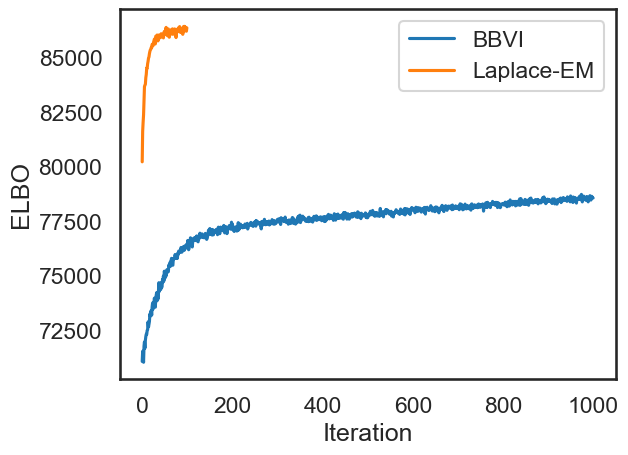

In [8]:
# Plot some results
plt.figure()
plt.plot(q_elbos_bbvi, label="BBVI")
plt.plot(q_elbos_lem[1:], label="Laplace-EM")
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("ELBO")

## 5. Visualizing True and Inferred States
We wrote some helper functions above that plot a state trajectory, with different colors corresponding to the discrete latent states. **Note**: we only can recover the true system up to an affine transformation. That's why, even though we have permuted the discrete states to match the true system, the colors don't always match up.

In the cell immediately below, we see that the estimated latent trajectories found using Laplace-EM match the ground-truth more closely. In the cell below that, we extract the dynamics matrices the $A_k$s and use them to plot the system dynamics in each state. Note that the Laplace-EM algorithm does a better job at finding the positions in state-space which trigger discrete state transitions.

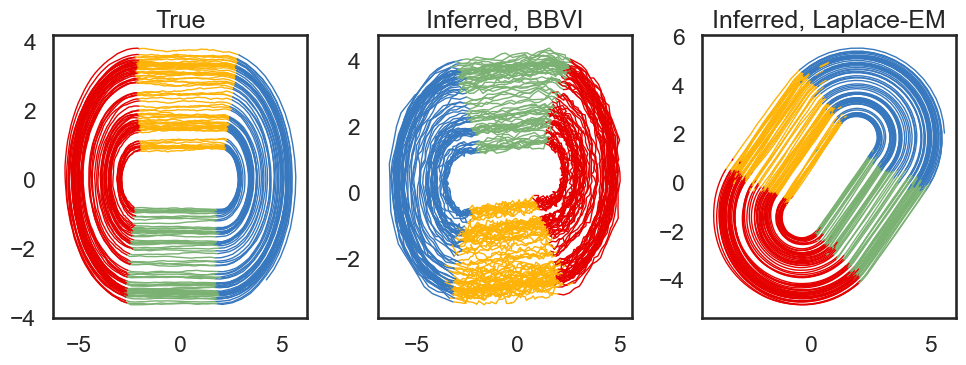

In [9]:
plt.figure(figsize=[10,4])
ax1 = plt.subplot(131)
plot_trajectory(z, x, ax=ax1)
plt.title("True")
ax2 = plt.subplot(132)
plot_trajectory(zhat_bbvi, xhat_bbvi, ax=ax2)
plt.title("Inferred, BBVI")
ax3 = plt.subplot(133)
plot_trajectory(zhat_lem, xhat_lem, ax=ax3)
plt.title("Inferred, Laplace-EM")
plt.tight_layout()

Text(0.5, 1.0, 'Inferred Dynamics, BBVI')

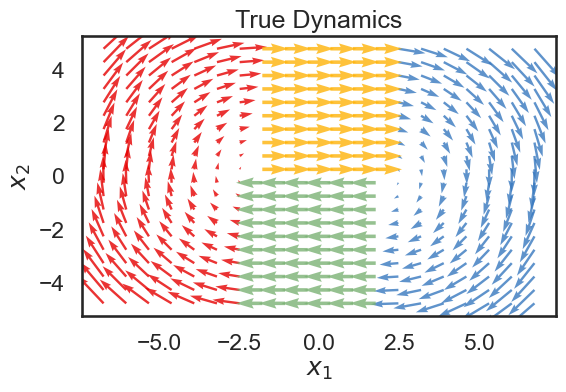

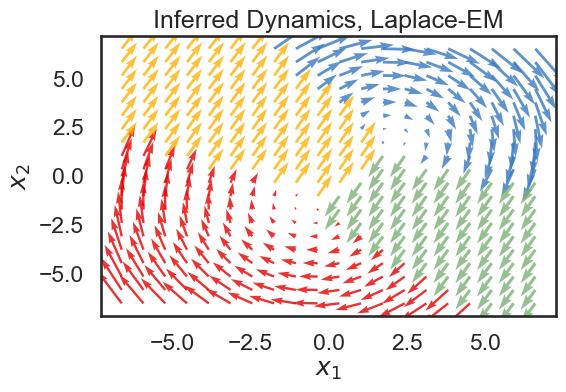

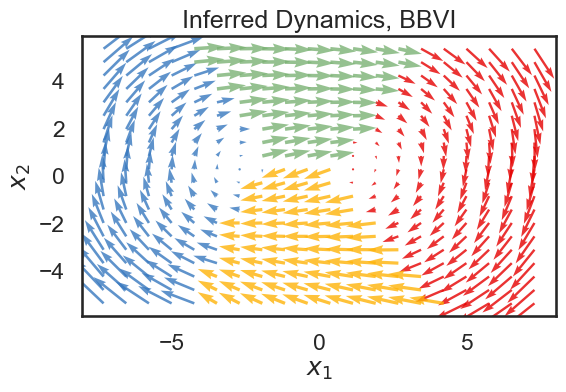

In [10]:
plt.figure(figsize=(6,4))
ax = plt.subplot(111)
lim = abs(x).max(axis=0) + 1
plot_most_likely_dynamics(true_rslds, xlim=(-lim[0], lim[0]), ylim=(-lim[1], lim[1]), ax=ax)
plt.title("True Dynamics")

plt.figure(figsize=(6,4))
ax = plt.subplot(111)
lim = abs(xhat_lem).max(axis=0) + 1
plot_most_likely_dynamics(rslds_lem, xlim=(-lim[0], lim[0]), ylim=(-lim[1], lim[1]), ax=ax)
plt.title("Inferred Dynamics, Laplace-EM")

plt.figure(figsize=(6,4))
ax = plt.subplot(111)
lim = abs(xhat_bbvi).max(axis=0) + 1
plot_most_likely_dynamics(rslds, xlim=(-lim[0], lim[0]), ylim=(-lim[1], lim[1]), ax=ax)
plt.title("Inferred Dynamics, BBVI")